In [1]:
import asyncio
import itertools
import logging
import random
import nest_asyncio
nest_asyncio.apply()# must be run at the start of every notebook to patch the event loop to allow nesting, eg. so we can run asyncio.run from within a notebook.

In [2]:
import os
from pathlib import Path
import tempfile

from shutil import rmtree
from typing import List, Optional, Union


In [3]:
# Adjust your env variables here if nescesary

%env NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
%env NUPLAN_MAPS_ROOT=../../data/nuplan/maps
%env NUPLAN_EXP_ROOT=../../data/nuplan/exp
%env NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/
%pwd

env: NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
env: NUPLAN_MAPS_ROOT=../../data/nuplan/maps
env: NUPLAN_EXP_ROOT=../../data/nuplan/exp
env: NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/


'/home/ehdykhne/nuplan-devkit/experiments'

In [4]:
import hydra
import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf

from nuplan.common.utils.s3_utils import is_s3_path
from nuplan.planning.script.builders.simulation_builder import build_simulations
from nuplan.planning.script.builders.simulation_callback_builder import (
    build_callbacks_worker,
    build_simulation_callbacks,
)
from nuplan.planning.script.utils import run_runners, set_default_path, set_up_common_builder
from nuplan.planning.simulation.planner.abstract_planner import AbstractPlanner

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# If set, use the env. variable to overwrite the default dataset and experiment paths
set_default_path()

# If set, use the env. variable to overwrite the Hydra config
CONFIG_PATH = os.getenv('NUPLAN_HYDRA_CONFIG_PATH', 'config/simulation')

if os.environ.get('NUPLAN_HYDRA_CONFIG_PATH') is not None:
    CONFIG_PATH = os.path.join('../../../../', CONFIG_PATH)

if os.path.basename(CONFIG_PATH) != 'simulation':
    CONFIG_PATH = os.path.join(CONFIG_PATH, 'simulation')
CONFIG_NAME = 'default_simulation'

In [5]:
from tutorials.utils.tutorial_utils import construct_simulation_hydra_paths

# Location of paths with all simulation configs
BASE_CONFIG_PATH = os.path.join(os.getenv('NUPLAN_TUTORIAL_PATH', ''), '../nuplan/planning/script')
simulation_hydra_paths = construct_simulation_hydra_paths(BASE_CONFIG_PATH)

# Create a temporary directory to store the simulation artifacts

DATASET_PARAMS = [
    'scenario_builder=nuplan',  # use nuplan mini database (2.5h of 8 autolabeled logs in Las Vegas)
    'scenario_filter=val14_split ',  # initially select all scenarios in the database
#     'scenario_filter.scenario_types=[near_multiple_vehicles, on_pickup_dropoff, starting_unprotected_cross_turn, high_magnitude_jerk]',  # select scenario types
#    'scenario_filter.scenario_types=[starting_unprotected_cross_turn, near_multiple_vehicles]',  # [near_multiple_vehicles, on_pickup_dropoff, starting_unprotected_cross_turn, high_magnitude_jerk]',  # select scenario types
#    'scenario_filter.num_scenarios_per_type=2',  # use 10 scenarios per scenario type
#     'scenario_filter=one_continuous_log',  # simulate only one log
#     "scenario_filter.log_names=['2021.06.14.16.48.02_veh-12_04057_04438']",
#    'scenario_filter.limit_total_scenarios=1',  # use 1 total scenarios
]
ckpt_dir = '/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/pdm_offset_checkpoint.ckpt'
#'/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt'
#'/home/ehdykhne/Repos/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt'
# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=simulation_hydra_paths.config_path)

# Compose the configuration
print(simulation_hydra_paths.config_name)
cfg = hydra.compose(config_name=simulation_hydra_paths.config_name, overrides=[
    '+simulation=closed_loop_reactive_agents',# [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents]
    #'model=gc_pgp_model',
    #'model.aggregator.pre_train=false',
    'planner=pdm_hybrid_planner',
    f"planner.pdm_hybrid_planner.checkpoint_path={ckpt_dir}" ,
    #'planner=ml_planner', 
    #'model=urban_driver_open_loop_model',
    #'ego_controller=perfect_tracking_controller',
    #'planner.ml_planner.model_config=${model}',
    #f'planner.ml_planner.checkpoint_path={ckpt_dir}',
    #f'observation=idm_agents_observation',
    #'observation.model_config=${model}',
    #f'observation.checkpoint_path={ckpt_dir}',
    'worker=ray_distributed', # [sequential, ray_distributed]
    '+occlusion=true',
    '+occlusion.manager_type=wedge', #options: [range, shadow, wedge]
    "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
    *DATASET_PARAMS,
])

output_folder = cfg.output_dir
print('output_folder = \"' + output_folder + '\"')
# output folders for runs:
# closed_loop_reactive_agents, wedge occlusions, urban_planner
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.21.59.48" 
# overall score: 0.5041, ego_at_fault_collisions: 363

# closed_loop_reactive_agents, occlusions = False, urban_planner
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.23.21.13"
# overall score: 0.5041, ego_at_fault_collisions: 357

# closed_loop_nonreactive_agents, occlusions = False, urban_planner
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.02.01.14"
#output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.07.32.41"
# overall score: , ego_at_fault_collisions: 

# closed_loop_nonreactive_agents, wedge occlusions, urban_planner
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.08.29.23"
# overall score: , ego_at_fault_collisions: 

# closed_loop_reactive_agents, wedge occlusions, gc_pgp
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.10.09.31.44"
# overall score: , ego_at_fault_collisions: 

# 'closed_loop_reactive_agents, occlusions = False, gc_pgp'
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.11.00.41.30"

# 'closed_loop_reactive_agents, occlusions = False, pdm_hybrid'
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.13.12.21.28"

# 'closed_loop_reactive_agents,  wedge occlusions, pdm_hybrid'
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.13.13.07.48"





default_simulation
output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.13.13.07.48"


# Now we can run with the following

Global seed set to 0
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback...
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback: 4...DONE!


2023-12-13 13:07:48,779 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2023-12-13 13:07:48,830 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:78}  Starting ray local!


2023-12-13 13:07:50,439	INFO worker.py:1636 -- Started a local Ray instance.


2023-12-13 13:07:51,120 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2023-12-13 13:07:51,120 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 32
Number of GPUs per node: 4
Number of threads across all nodes: 32
2023-12-13 13:07:51,121 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2023-12-13 13:07:51,121 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:32}  Building experiment folders...
2023-12-13 13:07:51,121 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:35}  

	Folder where all results are stored: ../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.13.13.07.48

2023-12-13 13:07:51,129 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_

Ray objects: 100%|██████████| 32/32 [00:01<00:00, 21.06it/s]


2023-12-13 13:07:52,799 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:76}  Building metric engines...
2023-12-13 13:07:53,176 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:78}  Building metric engines...DONE
2023-12-13 13:07:53,176 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:82}  Building simulations from 1118 scenarios...
2023-12-13 13:12:33,114 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:142}  Building simulations...DONE!
2023-12-13 13:12:33,114 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/run_simulation.py:114}  Running simulation...
2023-12-13 13:12:33,114 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:138}  Executing runners...
2023-12-13 13:12:33,114 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:82}  Starting 1118 simulations using RayDistr

Converting detections to smart agents:  17%|█▋        | 2/12 [00:00<00:01,  8.99it/s]
                                                                                     
                                                                                      
Ray objects:   0%|          | 0/1118 [00:00<?, ?it/s]

(wrapped_fn pid=18977) false
(wrapped_fn pid=18982) numrel agents 1
(wrapped_fn pid=18982) scenario 005c7b67ab8c5eb7
(wrapped_fn pid=18982) time elapsed false 0.017958641052246094


Converting detections to smart agents:   0%|          | 0/11 [00:00<?, ?it/s] [repeated 32x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
                                                                                       [repeated 62x across cluster]
                                                                                       [repeated 12x across cluster]
Ray objects:   0%|          | 2/1118 [00:25<3:24:51, 11.01s/it]

(wrapped_fn pid=18983) false [repeated 2x across cluster]


Ray objects:   0%|          | 4/1118 [00:28<1:19:08,  4.26s/it]

(wrapped_fn pid=18993) numrel agents 2 [repeated 2x across cluster]
(wrapped_fn pid=18963) numrel agents 2
(wrapped_fn pid=18963) numrel agents 2
(wrapped_fn pid=18993) scenario 04dbabe93cdf5835
(wrapped_fn pid=18993) time elapsed false 0.05844545364379883


Converting detections to smart agents:   2%|▏         | 1/50 [00:00<00:48,  1.02it/s] [repeated 5x across cluster]
                                                                                       [repeated 2x across cluster]
Ray objects:   1%|          | 6/1118 [00:31<55:06,  2.97s/it]

(wrapped_fn pid=18987) false [repeated 2x across cluster]


Converting detections to smart agents:  70%|███████   | 31/44 [00:01<00:00, 41.22it/s] [repeated 6x across cluster]
                                                                                       [repeated 2x across cluster]
Ray objects:   1%|          | 8/1118 [00:35<43:18,  2.34s/it]

(wrapped_fn pid=18984) time elapsed true 0.02723383903503418
(wrapped_fn pid=18984) numrel agents 10 [repeated 2x across cluster]
(wrapped_fn pid=18985) time elapsed true 0.02723383903503418
(wrapped_fn pid=18985) time elapsed true 0.02723383903503418
(wrapped_fn pid=18973) scenario 0338779ea8ba5128
(wrapped_fn pid=18973) time elapsed false 0.13227057456970215


Converting detections to smart agents:  59%|█████▉    | 13/22 [00:01<00:00, 15.75it/s] [repeated 4x across cluster]
                                                                                       [repeated 2x across cluster]
                                                                                       18985) 


(wrapped_fn pid=18975) numrel agents 1 [repeated 2x across cluster]
(wrapped_fn pid=18975) scenario 03ef717aff06535f
(wrapped_fn pid=18975) time elapsed false 0.041613101959228516
(wrapped_fn pid=18991) time elapsed false 0.0694575309753418
(wrapped_fn pid=18991) time elapsed false 0.0694575309753418
(wrapped_fn pid=18991) time elapsed false 0.0694575309753418
(wrapped_fn pid=18988) false


Converting detections to smart agents:  45%|████▍     | 13/29 [00:01<00:01, 15.69it/s] [repeated 5x across cluster]
                                                                                       [repeated 2x across cluster]


(wrapped_fn pid=18964) numrel agents 9
(wrapped_fn pid=18964) scenario 022fcc82f6d55f46
(wrapped_fn pid=18964) time elapsed false 0.25633668899536133


Converting detections to smart agents:  82%|████████▏ | 31/38 [00:01<00:00, 36.79it/s] [repeated 3x across cluster]
                                                                                       [repeated 2x across cluster]


(wrapped_fn pid=18966) numrel agents 2 [repeated 2x across cluster]
(wrapped_fn pid=18969) numrel agents 2
(wrapped_fn pid=18969) numrel agents 2
(wrapped_fn pid=18966) scenario 029fa42dc2b050b0
(wrapped_fn pid=18966) time elapsed false 0.08152198791503906
(wrapped_fn pid=18982) numrel agents 2 [repeated 5x across cluster]
(wrapped_fn pid=18992) scenario 0617d2b7c3c956e0 [repeated 4x across cluster]
(wrapped_fn pid=18992) time elapsed false 0.10098099708557129 [repeated 4x across cluster]


Converting detections to smart agents:  93%|█████████▎| 39/42 [00:00<00:00, 190.52it/s]
                                                                                       
Ray objects:   2%|▏         | 18/1118 [01:09<52:15,  2.85s/it]  

(wrapped_fn pid=18963) false
(wrapped_fn pid=18970) numrel agents 4 [repeated 3x across cluster]
(wrapped_fn pid=18976) scenario 049dada6c5635d20 [repeated 3x across cluster]
(wrapped_fn pid=18976) time elapsed false 0.11379790306091309 [repeated 3x across cluster]


Converting detections to smart agents:  75%|███████▌  | 24/32 [00:00<00:00, 227.81it/s] [repeated 5x across cluster]
                                                                                      
Converting detections to smart agents:   0%|          | 0/54 [00:00<?, ?it/s] [repeated 5x across cluster]


(wrapped_fn pid=18968) numrel agents 3 [repeated 6x across cluster]
(wrapped_fn pid=18981) scenario 05f93c480c1d5984 [repeated 6x across cluster]
(wrapped_fn pid=18981) time elapsed false 0.11666727066040039 [repeated 6x across cluster]


                                                                                        [repeated 5x across cluster]
                                                                                       18971) 
Converting detections to smart agents:   0%|          | 0/33 [00:00<?, ?it/s] [repeated 4x across cluster]
                                                                                     
Converting detections to smart agents:  48%|████▊     | 22/46 [00:00<00:00, 216.85it/s] [repeated 5x across cluster]
                                                                                       18967) 


(wrapped_fn pid=18980) numrel agents 3 [repeated 2x across cluster]
(wrapped_fn pid=18979) scenario 04f7fbf12de65cbb [repeated 2x across cluster]
(wrapped_fn pid=18979) time elapsed false 0.17267823219299316 [repeated 2x across cluster]
(wrapped_fn pid=18988) false


Converting detections to smart agents:   2%|▏         | 1/42 [00:01<00:42,  1.04s/it] [repeated 5x across cluster]
                                                                                      =18988) 
Ray objects:   3%|▎         | 33/1118 [01:31<27:18,  1.51s/it]

(wrapped_fn pid=18989) numrel agents 4 [repeated 2x across cluster]
(wrapped_fn pid=18990) scenario 014633279fde5c6b [repeated 2x across cluster]
(wrapped_fn pid=18990) time elapsed false 0.14457368850708008 [repeated 2x across cluster]


Converting detections to smart agents:  61%|██████    | 33/54 [00:00<00:00, 325.96it/s]
                                                                                       


(wrapped_fn pid=18985) numrel agents 4 [repeated 2x across cluster]
(wrapped_fn pid=18975) scenario 09387c1b42aa5288 [repeated 2x across cluster]
(wrapped_fn pid=18975) time elapsed false 0.11915802955627441 [repeated 2x across cluster]


Converting detections to smart agents:  51%|█████▏    | 19/37 [00:00<00:00, 180.78it/s]
                                                                                       
Ray objects:   3%|▎         | 38/1118 [01:42<29:39,  1.65s/it]

(wrapped_fn pid=18974) numrel agents 3
(wrapped_fn pid=18985) numrel agents 3
(wrapped_fn pid=18985) numrel agents 3
(wrapped_fn pid=18974) scenario 077f90163e83515a
(wrapped_fn pid=18974) time elapsed false 0.11200833320617676
(wrapped_fn pid=18983) numrel agents 6
(wrapped_fn pid=18983) time elapsed true 0.09158968925476074


                                                                                      [repeated 2x across cluster]
Converting detections to smart agents:   0%|          | 0/32 [00:00<?, ?it/s] [repeated 3x across cluster]
                                                                                       [repeated 2x across cluster]
Converting detections to smart agents:   0%|          | 0/35 [00:00<?, ?it/s]
                                                                                       


(wrapped_fn pid=18981) false
(wrapped_fn pid=18976) numrel agents 2
(wrapped_fn pid=18976) scenario 0bd3ee0c8e1357b2
(wrapped_fn pid=18976) time elapsed false 0.05526018142700195


Ray objects:   4%|▍         | 43/1118 [02:01<48:46,  2.72s/it]  

(wrapped_fn pid=18992) numrel agents 3 [repeated 2x across cluster]
(wrapped_fn pid=18973) numrel agents 3
(wrapped_fn pid=18973) numrel agents 3
(wrapped_fn pid=18992) scenario 0b23f003881e5a2f
(wrapped_fn pid=18992) time elapsed false 0.09309554100036621
(wrapped_fn pid=18964) time elapsed true 0.242844820022583


Converting detections to smart agents:   0%|          | 0/19 [00:00<?, ?it/s] [repeated 3x across cluster]
                                                                                        [repeated 3x across cluster]
                                                                             


(wrapped_fn pid=18979) false
(wrapped_fn pid=18982) numrel agents 2 [repeated 3x across cluster]
(wrapped_fn pid=18982) scenario 0adcd0e658d359a7 [repeated 2x across cluster]
(wrapped_fn pid=18982) time elapsed false 0.07434415817260742 [repeated 2x across cluster]


Converting detections to smart agents:   0%|          | 0/27 [00:00<?, ?it/s]pped_fn pid=18979) 
                                                                                       


(wrapped_fn pid=18977) numrel agents 4 [repeated 5x across cluster]
(wrapped_fn pid=18977) scenario 0c87850fe06e516c [repeated 5x across cluster]
(wrapped_fn pid=18977) time elapsed false 0.10890674591064453 [repeated 5x across cluster]


Ray objects:   4%|▍         | 47/1118 [02:16<51:57,  2.91s/it]  

(wrapped_fn pid=18965) false


                                                                                       18977) 
                                                                                       
Converting detections to smart agents:   0%|          | 0/67 [00:00<?, ?it/s]ed_fn pid=18991) 
                                                                                        [repeated 2x across cluster]
                                                                                       18965) 


(wrapped_fn pid=18990) numrel agents 1 [repeated 2x across cluster]
(wrapped_fn pid=18990) scenario 0e97991aaf6858ae [repeated 2x across cluster]
(wrapped_fn pid=18990) time elapsed false 0.036843061447143555 [repeated 2x across cluster]
(wrapped_fn pid=18988) 0d306053f89552cc
(wrapped_fn pid=18989) numrel agents 5 [repeated 2x across cluster]
(wrapped_fn pid=18988) numrel agents 5
(wrapped_fn pid=18988) numrel agents 5
(wrapped_fn pid=18989) scenario 0e80579390285813
(wrapped_fn pid=18989) time elapsed false 0.13251852989196777


Converting detections to smart agents:   0%|          | 0/41 [00:00<?, ?it/s] [repeated 6x across cluster]
                                                                                        [repeated 2x across cluster]
Ray objects:   5%|▌         | 59/1118 [02:38<45:40,  2.59s/it]

(wrapped_fn pid=18962) numrel agents 1 [repeated 5x across cluster]
(wrapped_fn pid=18962) scenario 0ba3bc329f625a87 [repeated 5x across cluster]
(wrapped_fn pid=18962) time elapsed false 0.10295891761779785 [repeated 5x across cluster]


                                                                                        [repeated 3x across cluster]
Ray objects:   6%|▌         | 62/1118 [02:47<45:01,  2.56s/it]

(wrapped_fn pid=18970) numrel agents 4 [repeated 2x across cluster]
(wrapped_fn pid=18968) numrel agents 4
(wrapped_fn pid=18968) numrel agents 4
(wrapped_fn pid=18970) scenario 0cd0bb95c83751e2
(wrapped_fn pid=18970) time elapsed false 0.1399524211883545


Ray objects:   6%|▌         | 63/1118 [02:48<34:24,  1.96s/it]

(wrapped_fn pid=18963) false


                                                                                     
Converting detections to smart agents:   0%|          | 0/28 [00:00<?, ?it/s] [repeated 4x across cluster]


(wrapped_fn pid=18985) false
(wrapped_fn pid=18985) false
(wrapped_fn pid=18985) false
(wrapped_fn pid=18986) false


Ray objects:   6%|▌         | 66/1118 [02:57<39:57,  2.28s/it]  

(wrapped_fn pid=18973) numrel agents 2
(wrapped_fn pid=18973) scenario 1001304290285954
(wrapped_fn pid=18973) time elapsed false 0.06795620918273926


                                                                                     
Converting detections to smart agents:  94%|█████████▍| 62/66 [00:00<00:00, 189.74it/s]


(wrapped_fn pid=18980) numrel agents 3 [repeated 3x across cluster]
(wrapped_fn pid=18980) scenario 0e3ebea8bc015a83 [repeated 3x across cluster]
(wrapped_fn pid=18980) time elapsed false 0.11722826957702637 [repeated 3x across cluster]


Converting detections to smart agents:   0%|          | 0/28 [00:00<?, ?it/s]
                                                                                       
Ray objects:   6%|▋         | 71/1118 [03:09<36:41,  2.10s/it]

(wrapped_fn pid=18974) numrel agents 3 [repeated 2x across cluster]
(wrapped_fn pid=18975) numrel agents 3
(wrapped_fn pid=18975) numrel agents 3
(wrapped_fn pid=18974) scenario 0ec11905be6357bf
(wrapped_fn pid=18974) time elapsed false 0.11496877670288086


                                                                                      [repeated 2x across cluster]
Ray objects:   7%|▋         | 73/1118 [03:16<46:11,  2.65s/it]

(wrapped_fn pid=18977) numrel agents 3 [repeated 2x across cluster]
(wrapped_fn pid=18964) numrel agents 3
(wrapped_fn pid=18964) numrel agents 3
(wrapped_fn pid=18977) scenario 11ac0cd68d2b52be
(wrapped_fn pid=18977) time elapsed false 0.10139107704162598


                                                                                        [repeated 2x across cluster]
Converting detections to smart agents:   0%|          | 0/17 [00:00<?, ?it/s] [repeated 2x across cluster]
                                                                             


(wrapped_fn pid=18987) false


                                                                                      =18975) 


(wrapped_fn pid=18976) numrel agents 3 [repeated 2x across cluster]
(wrapped_fn pid=18979) numrel agents 3
(wrapped_fn pid=18979) numrel agents 3
(wrapped_fn pid=18976) scenario 0f218605b46855a3
(wrapped_fn pid=18976) time elapsed false 0.13882017135620117


                                                                                        [repeated 2x across cluster]
Converting detections to smart agents:   0%|          | 0/24 [00:00<?, ?it/s] [repeated 3x across cluster]
                                                                                       
Converting detections to smart agents:  45%|████▌     | 23/51 [00:00<00:00, 226.57it/s]
                                                                                     pid=18971) 
                                                                                       
                                                                                       


(wrapped_fn pid=18965) numrel agents 2 [repeated 6x across cluster]
(wrapped_fn pid=18991) scenario 12384a61bce55dfd [repeated 5x across cluster]
(wrapped_fn pid=18991) time elapsed false 0.11890935897827148 [repeated 5x across cluster]


Converting detections to smart agents:   0%|          | 0/4 [00:00<?, ?it/s] [repeated 2x across cluster]
                                                                                     [repeated 2x across cluster]
                                                                                       18981) 
                                                                                       


(wrapped_fn pid=18983) numrel agents 2 [repeated 3x across cluster]
(wrapped_fn pid=18983) scenario 16966427ad615141 [repeated 4x across cluster]
(wrapped_fn pid=18983) time elapsed false 0.05710792541503906 [repeated 4x across cluster]
(wrapped_fn pid=18968) false


Converting detections to smart agents:   0%|          | 0/70 [00:00<?, ?it/s]
                                                                                       18983) 


(wrapped_fn pid=18969) numrel agents 3 [repeated 2x across cluster]
(wrapped_fn pid=18969) scenario 133baa14fb5457ac [repeated 2x across cluster]
(wrapped_fn pid=18969) time elapsed false 0.1302480697631836 [repeated 2x across cluster]


Ray objects:   8%|▊         | 89/1118 [03:50<28:08,  1.64s/it]

(wrapped_fn pid=18982) numrel agents 2


Converting detections to smart agents:   0%|          | 0/28 [00:00<?, ?it/s] [repeated 4x across cluster]
                                                                                       [repeated 8x across cluster]
                                                                             
                                                                                    id=18982) 
                                                         s/it](wrapped_fn pid=18972) 


(wrapped_fn pid=18966) false
(wrapped_fn pid=18989) false
(wrapped_fn pid=18989) false
(wrapped_fn pid=18989) false


Converting detections to smart agents:  52%|█████▏    | 17/33 [00:00<00:00, 162.54it/s]
                                                                                       


(wrapped_fn pid=18986) numrel agents 2
(wrapped_fn pid=18986) scenario 15990b4dfd035da3
(wrapped_fn pid=18986) time elapsed false 0.0720815658569336


Converting detections to smart agents:  50%|█████     | 18/36 [00:00<00:00, 178.57it/s]
                                                                                       


(wrapped_fn pid=18970) numrel agents 2 [repeated 2x across cluster]
(wrapped_fn pid=18970) scenario 157d4bcf09955c0f [repeated 2x across cluster]
(wrapped_fn pid=18970) time elapsed false 0.07332634925842285 [repeated 2x across cluster]


Converting detections to smart agents:   0%|          | 0/31 [00:00<?, ?it/s]ed_fn pid=18966) 
                                                                                       
                                                                             ed_fn pid=18971) 
Ray objects:   9%|▊         | 97/1118 [04:12<40:53,  2.40s/it]

(wrapped_fn pid=18985) numrel agents 3 [repeated 2x across cluster]
(wrapped_fn pid=18985) scenario 15455c755f3d5f8e [repeated 2x across cluster]
(wrapped_fn pid=18985) time elapsed false 0.11420893669128418 [repeated 2x across cluster]


Converting detections to smart agents:  20%|█▉        | 10/51 [00:00<00:00, 49.54it/s]
                                                                                      =18962) 


(wrapped_fn pid=18974) numrel agents 3 [repeated 4x across cluster]
(wrapped_fn pid=18979) false


                                                                              [repeated 2x across cluster]
Converting detections to smart agents:  40%|████      | 17/42 [00:00<00:00, 168.32it/s]
                                                                                       


(wrapped_fn pid=18974) scenario 174934676f935862 [repeated 4x across cluster]
(wrapped_fn pid=18974) time elapsed false 0.08322477340698242 [repeated 4x across cluster]


                                                                                       =18973) 
Ray objects:   9%|▉         | 103/1118 [04:26<33:43,  1.99s/it]

(wrapped_fn pid=18964) numrel agents 4
(wrapped_fn pid=18975) false [repeated 2x across cluster]


Ray objects:   9%|▉         | 104/1118 [04:26<27:08,  1.61s/it]

(wrapped_fn pid=18990) scenario 1b9234d32b0750bb [repeated 2x across cluster]
(wrapped_fn pid=18990) time elapsed false 0.05879473686218262 [repeated 2x across cluster]


                                                                                       =18979) 
Converting detections to smart agents:  44%|████▍     | 15/34 [00:00<00:00, 144.67it/s] [repeated 4x across cluster]


(wrapped_fn pid=18980) numrel agents 2 [repeated 3x across cluster]
(wrapped_fn pid=18967) numrel agents 2
(wrapped_fn pid=18967) numrel agents 2
(wrapped_fn pid=18980) scenario 1729f89fec425d59
(wrapped_fn pid=18980) time elapsed false 0.06605744361877441


                                                                                       
                                                                                       
Ray objects:  10%|▉         | 109/1118 [04:36<38:31,  2.29s/it]

(wrapped_fn pid=18992) numrel agents 3
(wrapped_fn pid=18992) scenario 16b29545f7355276
(wrapped_fn pid=18992) time elapsed false 0.12369394302368164
(wrapped_fn pid=18991) numrel agents 4


                                                                              [repeated 2x across cluster]
                                                                                        [repeated 4x across cluster]


(wrapped_fn pid=18972) false


Ray objects:  10%|▉         | 111/1118 [04:42<43:01,  2.56s/it]

(wrapped_fn pid=18988) time elapsed true 0.028877735137939453


(wrapped_fn pid=18977) scenario 181412fd9fc453bd [repeated 2x across cluster]
(wrapped_fn pid=18977) time elapsed false 0.11065244674682617 [repeated 2x across cluster]
(wrapped_fn pid=18977) numrel agents 3 [repeated 2x across cluster]


Converting detections to smart agents:  72%|███████▏  | 36/50 [00:00<00:00, 159.09it/s]
                                                                                       
Ray objects:  10%|█         | 115/1118 [04:50<33:26,  2.00s/it]

(wrapped_fn pid=18962) time elapsed false 0.13926291465759277


Converting detections to smart agents:   0%|          | 0/27 [00:00<?, ?it/s] [repeated 4x across cluster]
                                                                                        [repeated 5x across cluster]


(wrapped_fn pid=18963) numrel agents 3
(wrapped_fn pid=18963) numrel agents 3
(wrapped_fn pid=18984) numrel agents 3 [repeated 2x across cluster]
(wrapped_fn pid=18984) scenario 1a66a7c3545d5323
(wrapped_fn pid=18984) time elapsed false 0.13771462440490723


                                                                                       =18977) 


(wrapped_fn pid=18969) numrel agents 6 [repeated 2x across cluster]
(wrapped_fn pid=18976) numrel agents 6
(wrapped_fn pid=18976) numrel agents 6
(wrapped_fn pid=18969) time elapsed true 0.193864107131958
(wrapped_fn pid=18970) scenario 1e5876a1d8045e46
(wrapped_fn pid=18970) time elapsed false 0.04049181938171387


Converting detections to smart agents:  78%|███████▊  | 59/76 [00:00<00:00, 192.65it/s] [repeated 4x across cluster]
                                                                                       


(wrapped_fn pid=18986) false


Ray objects:  11%|█         | 119/1118 [05:06<1:03:08,  3.79s/it]

(wrapped_fn pid=18982) numrel agents 3 [repeated 3x across cluster]
(wrapped_fn pid=18981) numrel agents 3
(wrapped_fn pid=18981) numrel agents 3
(wrapped_fn pid=18982) scenario 1f8b1a546a215f1d
(wrapped_fn pid=18982) time elapsed false 0.08042597770690918
(wrapped_fn pid=18968) numrel agents 2
(wrapped_fn pid=18965) false


Converting detections to smart agents:  71%|███████   | 47/66 [00:00<00:00, 230.87it/s]
                                                                                       id=18970) 
                                                                                       =18969) 


(wrapped_fn pid=18985) numrel agents 2 [repeated 4x across cluster]
(wrapped_fn pid=18985) scenario 1efdeee099b2567b [repeated 4x across cluster]
(wrapped_fn pid=18985) time elapsed false 0.058634281158447266 [repeated 4x across cluster]


Converting detections to smart agents:   0%|          | 0/34 [00:00<?, ?it/s] [repeated 4x across cluster]
                                                                                        [repeated 4x across cluster]
Converting detections to smart agents:   8%|▊         | 1/13 [00:00<00:04,  2.86it/s]
                                                                                     
Converting detections to smart agents:   0%|          | 0/22 [00:00<?, ?it/s]ped_fn pid=18982) 
                                                                                       =18987) 
Converting detections to smart agents:   3%|▎         | 1/36 [00:00<00:10,  3.22it/s]


(wrapped_fn pid=18993) numrel agents 3 [repeated 2x across cluster]
(wrapped_fn pid=18983) numrel agents 3
(wrapped_fn pid=18983) numrel agents 3
(wrapped_fn pid=18993) scenario 1e77a04e93c75ba5
(wrapped_fn pid=18993) time elapsed false 0.12475752830505371


                                                         6s/it](wrapped_fn pid=18983) 
                                                         
                                                                                       [repeated 2x across cluster]


(wrapped_fn pid=18989) false


Ray objects:  12%|█▏        | 133/1118 [05:32<47:17,  2.88s/it]

(wrapped_fn pid=18973) numrel agents 7 [repeated 2x across cluster]
(wrapped_fn pid=18978) numrel agents 7
(wrapped_fn pid=18978) numrel agents 7


Converting detections to smart agents:   0%|          | 0/35 [00:00<?, ?it/s]


(wrapped_fn pid=18973) scenario 1f463bd4f9a85923
(wrapped_fn pid=18973) time elapsed false 0.2194211483001709


Converting detections to smart agents:  47%|████▋     | 18/38 [00:00<00:00, 178.22it/s]
                                                                                       


(wrapped_fn pid=18967) numrel agents 2 [repeated 2x across cluster]
(wrapped_fn pid=18974) numrel agents 2
(wrapped_fn pid=18974) numrel agents 2
(wrapped_fn pid=18967) scenario 220dc5aa304859b0
(wrapped_fn pid=18967) time elapsed false 0.08265066146850586


Converting detections to smart agents:   0%|          | 0/24 [00:00<?, ?it/s] [repeated 2x across cluster]
                                                                                       
                                                                                       id=18989) 


(wrapped_fn pid=18990) time elapsed true 0.08369588851928711
(wrapped_fn pid=18990) time elapsed true 0.08369588851928711
(wrapped_fn pid=18979) numrel agents 1
(wrapped_fn pid=18979) scenario 1fc135287cce5f74
(wrapped_fn pid=18979) time elapsed false 0.07734322547912598


Converting detections to smart agents:  62%|██████▎   | 20/32 [00:00<00:00, 191.46it/s]
                                                                                       


(wrapped_fn pid=18975) numrel agents 2 [repeated 2x across cluster]
(wrapped_fn pid=18980) numrel agents 2
(wrapped_fn pid=18980) numrel agents 2
(wrapped_fn pid=18975) scenario 20dd31cd90325acc
(wrapped_fn pid=18975) time elapsed false 0.11316776275634766


                                                                                       id=18990) 


(wrapped_fn pid=18983) false


Converting detections to smart agents:  36%|███▌      | 17/47 [00:00<00:00, 164.28it/s]
                                                                                       
Ray objects:  13%|█▎        | 141/1118 [06:02<53:44,  3.30s/it]  

(wrapped_fn pid=18976) numrel agents 5 [repeated 2x across cluster]
(wrapped_fn pid=18988) numrel agents 5
(wrapped_fn pid=18988) numrel agents 5


(wrapped_fn pid=18976) scenario 23cb24f7bfb95e52
(wrapped_fn pid=18976) time elapsed false 0.1609785556793213


Ray objects:  13%|█▎        | 142/1118 [06:04<45:13,  2.78s/it]

(wrapped_fn pid=18963) numrel agents 3
(wrapped_fn pid=18972) numrel agents 5 [repeated 3x across cluster]


                                                                              [repeated 3x across cluster]
                                                                                        [repeated 2x across cluster]
                                                                             ped_fn pid=18988) 
Ray objects:  13%|█▎        | 145/1118 [06:10<32:19,  1.99s/it]

(wrapped_fn pid=18972) scenario 22fbae96f7bb57e7 [repeated 3x across cluster]
(wrapped_fn pid=18972) time elapsed false 0.16028237342834473 [repeated 3x across cluster]


Converting detections to smart agents:   0%|          | 0/17 [00:00<?, ?it/s] [repeated 5x across cluster]
                                                                                        [repeated 2x across cluster]
Ray objects:  13%|█▎        | 149/1118 [06:17<25:07,  1.56s/it]

(wrapped_fn pid=18977) numrel agents 2 [repeated 2x across cluster]


                                                                                     
                                                                                       
Ray objects:  13%|█▎        | 150/1118 [06:18<22:01,  1.36s/it]

(wrapped_fn pid=18977) scenario 236f917924b6546a [repeated 2x across cluster]
(wrapped_fn pid=18977) time elapsed false 0.10641956329345703 [repeated 2x across cluster]
(wrapped_fn pid=18964) false


Converting detections to smart agents:  47%|████▋     | 23/49 [00:00<00:00, 222.52it/s] [repeated 2x across cluster]
                                                                                       


(wrapped_fn pid=18986) numrel agents 1 [repeated 4x across cluster]
(wrapped_fn pid=18986) scenario 252dc073498258c7 [repeated 4x across cluster]
(wrapped_fn pid=18986) time elapsed false 0.06242966651916504 [repeated 4x across cluster]
(wrapped_fn pid=18965) time elapsed true 0.1162118911743164
(wrapped_fn pid=18974) numrel agents 5


Converting detections to smart agents:   0%|          | 0/20 [00:00<?, ?it/s]
                                                                                       


(wrapped_fn pid=18970) false
(wrapped_fn pid=18969) numrel agents 5 [repeated 3x across cluster]


Converting detections to smart agents:   0%|          | 0/25 [00:00<?, ?it/s]ped_fn pid=18965) 
                                                                                       
Ray objects:  14%|█▍        | 154/1118 [06:30<34:32,  2.15s/it]

(wrapped_fn pid=18969) scenario 24574a3fa2ed576e [repeated 2x across cluster]
(wrapped_fn pid=18969) time elapsed false 0.18723726272583008 [repeated 2x across cluster]


                                                                                       =18971) 
Ray objects:  14%|█▍        | 158/1118 [06:35<23:43,  1.48s/it]

(wrapped_fn pid=18991) numrel agents 5
(wrapped_fn pid=18966) numrel agents 5
(wrapped_fn pid=18966) time elapsed false 0.17402076721191406
(wrapped_fn pid=18966) time elapsed false 0.17402076721191406


Converting detections to smart agents:   0%|          | 0/13 [00:00<?, ?it/s] [repeated 5x across cluster]
                                                                              [repeated 4x across cluster]


(wrapped_fn pid=18984) false


Converting detections to smart agents:  74%|███████▎  | 25/34 [00:00<00:00, 248.46it/s] [repeated 2x across cluster]


(wrapped_fn pid=18962) numrel agents 2
(wrapped_fn pid=18962) scenario 2315ca6fdcf65ce0
(wrapped_fn pid=18962) time elapsed false 0.13243651390075684


Converting detections to smart agents:   0%|          | 0/6 [00:00<?, ?it/s] [repeated 3x across cluster]
                                                                                     [repeated 2x across cluster]
                                                                                       
Ray objects:  15%|█▍        | 163/1118 [06:47<37:48,  2.38s/it]

(wrapped_fn pid=18990) numrel agents 2
(wrapped_fn pid=18990) scenario 2965e4c9734152d9
(wrapped_fn pid=18990) time elapsed false 0.07552218437194824


Converting detections to smart agents:   0%|          | 0/5 [00:00<?, ?it/s] [repeated 2x across cluster]


(wrapped_fn pid=18978) numrel agents 2


Converting detections to smart agents:  14%|█▍        | 1/7 [00:00<00:04,  1.31it/s] [repeated 3x across cluster]
                                                                                    
Converting detections to smart agents:   0%|          | 0/37 [00:00<?, ?it/s] [repeated 2x across cluster]


(wrapped_fn pid=18978) numrel agents 4
(wrapped_fn pid=18978) numrel agents 4
(wrapped_fn pid=18989) numrel agents 4
(wrapped_fn pid=18989) scenario 28a7494f82395273
(wrapped_fn pid=18989) time elapsed false 0.12788128852844238
(wrapped_fn pid=18993) numrel agents 3


Converting detections to smart agents:  45%|████▌     | 20/44 [00:00<00:00, 193.15it/s]
                                                                                       


(wrapped_fn pid=18972) false


                                                                             [repeated 2x across cluster]


(wrapped_fn pid=18963) scenario 29be0c5292695bb7 [repeated 3x across cluster]
(wrapped_fn pid=18963) time elapsed false 0.08574914932250977 [repeated 3x across cluster]
(wrapped_fn pid=18981) numrel agents 1 [repeated 4x across cluster]


                                                                             ped_fn pid=18963) 
Converting detections to smart agents:   0%|          | 0/41 [00:00<?, ?it/s] [repeated 2x across cluster]
                                                                                       
Ray objects:  15%|█▌        | 171/1118 [07:09<28:59,  1.84s/it]

(wrapped_fn pid=18976) time elapsed false 0.029037952423095703
(wrapped_fn pid=18970) scenario 2cdde2c236085d4d [repeated 3x across cluster]
(wrapped_fn pid=18970) time elapsed false 0.029037952423095703 [repeated 3x across cluster]
(wrapped_fn pid=18970) time elapsed false 0.029037952423095703


Ray objects:  15%|█▌        | 172/1118 [07:09<21:34,  1.37s/it]

(wrapped_fn pid=18987) numrel agents 3


                                                                                        [repeated 2x across cluster]


(wrapped_fn pid=18969) false


                                                                                       
Ray objects:  16%|█▌        | 176/1118 [07:13<17:51,  1.14s/it]

(wrapped_fn pid=18988) scenario 29cfa239ca925107 [repeated 2x across cluster]
(wrapped_fn pid=18988) time elapsed false 0.07090497016906738 [repeated 2x across cluster]
(wrapped_fn pid=18977) numrel agents 1 [repeated 2x across cluster]
(wrapped_fn pid=18982) false [repeated 2x across cluster]
(wrapped_fn pid=18980) 0.12318921089172363


                                                                             [repeated 2x across cluster]
Converting detections to smart agents:   0%|          | 0/4 [00:00<?, ?it/s] [repeated 3x across cluster]
                                                                                     [repeated 2x across cluster]
Converting detections to smart agents:  93%|█████████▎| 68/73 [00:00<00:00, 199.86it/s]=18988) 


(wrapped_fn pid=18980) scenario 297460a38cf85c4a [repeated 3x across cluster]
(wrapped_fn pid=18980) time elapsed false  [repeated 3x across cluster]
(wrapped_fn pid=18980) numrel agents 3 [repeated 2x across cluster]
(wrapped_fn pid=18979) false [repeated 2x across cluster]


Converting detections to smart agents:   0%|          | 0/33 [00:00<?, ?it/s] [repeated 5x across cluster]
                                                                                      [repeated 3x across cluster]
                                                                                       =18967) 


(wrapped_fn pid=18975) numrel agents 5
(wrapped_fn pid=18975) numrel agents 5
(wrapped_fn pid=18968) numrel agents 5 [repeated 2x across cluster]
(wrapped_fn pid=18966) scenario 2d4fa9eb37155845
(wrapped_fn pid=18966) time elapsed false 0.0531926155090332


                                                                                       =18979) 
Converting detections to smart agents:  48%|████▊     | 21/44 [00:00<00:00, 208.20it/s] [repeated 6x across cluster]
                                                                                        [repeated 3x across cluster]


(wrapped_fn pid=18986) numrel agents 2 [repeated 3x across cluster]
(wrapped_fn pid=18986) scenario 2b5f330cc84a58d3 [repeated 3x across cluster]
(wrapped_fn pid=18986) time elapsed false 0.09041571617126465 [repeated 3x across cluster]


Converting detections to smart agents:   0%|          | 0/26 [00:00<?, ?it/s]


(wrapped_fn pid=18971) numrel agents 5 [repeated 4x across cluster]
(wrapped_fn pid=18964) scenario 2c6685877c5c5add [repeated 3x across cluster]
(wrapped_fn pid=18964) time elapsed false 0.06763792037963867 [repeated 3x across cluster]


Converting detections to smart agents:   0%|          | 0/10 [00:00<?, ?it/s]


(wrapped_fn pid=18970) false


                                                                                     
Converting detections to smart agents:   0%|          | 0/16 [00:00<?, ?it/s]apped_fn pid=18986) 
                                                                                      


(wrapped_fn pid=18972) numrel agents 2 [repeated 2x across cluster]
(wrapped_fn pid=18974) scenario 2ba56b194be35170 [repeated 2x across cluster]
(wrapped_fn pid=18974) time elapsed false 0.08060383796691895 [repeated 2x across cluster]


                                                                                        [repeated 4x across cluster]
                                                                                       


(wrapped_fn pid=18977) false [repeated 2x across cluster]


Converting detections to smart agents:   0%|          | 0/40 [00:00<?, ?it/s] [repeated 3x across cluster]
                                                                                       =18992) 
                                                                                     [repeated 4x across cluster]
Converting detections to smart agents:   0%|          | 0/38 [00:00<?, ?it/s]
                                                                                       
Converting detections to smart agents:   0%|          | 0/29 [00:00<?, ?it/s] [repeated 6x across cluster]


(wrapped_fn pid=18963) false
(wrapped_fn pid=18963) scenario 2e35d8043dfc57ac [repeated 2x across cluster]
(wrapped_fn pid=18963) time elapsed false 0.11214208602905273 [repeated 2x across cluster]
(wrapped_fn pid=18969) false
(wrapped_fn pid=18965) numrel agents 1


Converting detections to smart agents:   0%|          | 0/17 [00:00<?, ?it/s]
                                                                                       


(wrapped_fn pid=18991) time elapsed true 0.07189297676086426
(wrapped_fn pid=18973) scenario 2ee2a0bbeef25e75 [repeated 3x across cluster]
(wrapped_fn pid=18973) time elapsed false 0.0694732666015625 [repeated 3x across cluster]
(wrapped_fn pid=18991) numrel agents 4 [repeated 3x across cluster]


                                                                             ped_fn pid=18969) 
Converting detections to smart agents:  46%|████▌     | 18/39 [00:00<00:00, 173.41it/s]=18993) 
                                                                                       


(wrapped_fn pid=18990) time elapsed false 0.07654500007629395
(wrapped_fn pid=18990) time elapsed false 0.07654500007629395
(wrapped_fn pid=18990) time elapsed false 0.07654500007629395


Ray objects:  18%|█▊        | 205/1118 [08:14<37:37,  2.47s/it]

(wrapped_fn pid=18981) false


Converting detections to smart agents:   0%|          | 0/36 [00:00<?, ?it/s] [repeated 3x across cluster]


(wrapped_fn pid=18982) numrel agents 3
(wrapped_fn pid=18982) scenario 30bd4a80c1f45c5d
(wrapped_fn pid=18982) time elapsed false 0.0816202163696289


(wrapped_fn pid=18983) false
(wrapped_fn pid=18976) numrel agents 4
(wrapped_fn pid=18976) scenario 30195f6787f757e5
(wrapped_fn pid=18976) time elapsed false 0.1421959400177002


Converting detections to smart agents:   0%|          | 0/25 [00:00<?, ?it/s]
                                                                             
                                                                                       id=18990) 
Ray objects:  19%|█▉        | 210/1118 [08:29<40:02,  2.65s/it]

(wrapped_fn pid=18989) false
(wrapped_fn pid=18963) false
(wrapped_fn pid=18963) false
(wrapped_fn pid=18963) false


Converting detections to smart agents:   0%|          | 0/31 [00:00<?, ?it/s]


(wrapped_fn pid=18967) numrel agents 2
(wrapped_fn pid=18967) scenario 317878d8107a57e4
(wrapped_fn pid=18967) time elapsed false 0.07742118835449219


                                                                             ped_fn pid=18976) 
Ray objects:  19%|█▉        | 213/1118 [08:39<48:29,  3.21s/it]

(wrapped_fn pid=18985) numrel agents 4 [repeated 5x across cluster]
(wrapped_fn pid=18984) scenario 322b2169ba325227 [repeated 4x across cluster]
(wrapped_fn pid=18984) time elapsed false 0.06446623802185059 [repeated 4x across cluster]


Converting detections to smart agents:  46%|████▋     | 19/41 [00:00<00:00, 185.02it/s]
                                                                                       


(wrapped_fn pid=18962) false


                                                                                     id=18986) 
                                                                              [repeated 4x across cluster]
Converting detections to smart agents:  71%|███████   | 46/65 [00:00<00:00, 208.08it/s] [repeated 3x across cluster]


(wrapped_fn pid=18980) numrel agents 2 [repeated 3x across cluster]
(wrapped_fn pid=18988) scenario 30aa28efb1a45959 [repeated 3x across cluster]
(wrapped_fn pid=18988) time elapsed false 0.15822863578796387 [repeated 3x across cluster]


Converting detections to smart agents:   0%|          | 0/63 [00:00<?, ?it/s]ped_fn pid=18967) 
                                                                                       
                                                                                       =18992) 
Converting detections to smart agents:  65%|██████▌   | 41/63 [00:00<00:00, 200.80it/s] [repeated 2x across cluster]


(wrapped_fn pid=18979) numrel agents 4 [repeated 3x across cluster]
(wrapped_fn pid=18966) scenario 3196c324c82c553c [repeated 3x across cluster]
(wrapped_fn pid=18966) time elapsed false 0.1270427703857422 [repeated 3x across cluster]


Converting detections to smart agents:   0%|          | 0/26 [00:00<?, ?it/s] [repeated 2x across cluster]
                                                                                        [repeated 2x across cluster]
                                                                                      d=18980) 


(wrapped_fn pid=18968) numrel agents 3 [repeated 2x across cluster]
(wrapped_fn pid=18968) scenario 3260e05e584d5fe8 [repeated 3x across cluster]
(wrapped_fn pid=18968) time elapsed false 0.10261797904968262 [repeated 3x across cluster]


Ray objects:  20%|██        | 226/1118 [09:01<24:40,  1.66s/it]

(wrapped_fn pid=18973) false
(wrapped_fn pid=18970) numrel agents 2 [repeated 2x across cluster]
(wrapped_fn pid=18977) numrel agents 2
(wrapped_fn pid=18977) numrel agents 2
(wrapped_fn pid=18970) scenario 33d291fdc9ec5f29
(wrapped_fn pid=18970) time elapsed false 0.08425378799438477


Converting detections to smart agents:   0%|          | 0/37 [00:00<?, ?it/s] [repeated 4x across cluster]
                                                                                        [repeated 4x across cluster]
                                                                                       
Ray objects:  20%|██        | 228/1118 [09:10<41:27,  2.79s/it]

(wrapped_fn pid=18972) false
(wrapped_fn pid=18964) numrel agents 1 [repeated 2x across cluster]
(wrapped_fn pid=18964) scenario 341f2720ef215146 [repeated 2x across cluster]
(wrapped_fn pid=18964) time elapsed false 0.06460952758789062 [repeated 2x across cluster]


Converting detections to smart agents:  72%|███████▏  | 23/32 [00:00<00:00, 226.53it/s]
                                                                                       
Ray objects:  21%|██        | 231/1118 [09:17<33:49,  2.29s/it]

(wrapped_fn pid=18993) numrel agents 2
(wrapped_fn pid=18993) scenario 3639112fbe5354b8
(wrapped_fn pid=18993) time elapsed false 0.11407351493835449
(wrapped_fn pid=18982) numrel agents 1
(wrapped_fn pid=18976) false


Converting detections to smart agents:   0%|          | 0/30 [00:00<?, ?it/s]
                                                                                       
                                                                             ped_fn pid=18972) 
Converting detections to smart agents:   0%|          | 0/55 [00:00<?, ?it/s] [repeated 3x across cluster]
                                                                                        [repeated 2x across cluster]
                                                                                       
Ray objects:  21%|██        | 236/1118 [09:28<34:21,  2.34s/it]

(wrapped_fn pid=18986) scenario 383b3d0dc4b955bf [repeated 3x across cluster]
(wrapped_fn pid=18986) time elapsed false 0.05853128433227539 [repeated 3x across cluster]
(wrapped_fn pid=18990) numrel agents 4 [repeated 3x across cluster]


Converting detections to smart agents:   0%|          | 0/44 [00:00<?, ?it/s] [repeated 3x across cluster]
                                                                                        [repeated 4x across cluster]
                                                                                     id=18993) 


(wrapped_fn pid=18971) scenario 34eb025310055085 [repeated 3x across cluster]
(wrapped_fn pid=18971) time elapsed false 0.08970046043395996 [repeated 3x across cluster]
(wrapped_fn pid=18971) numrel agents 2 [repeated 2x across cluster]
(wrapped_fn pid=18989) false


Converting detections to smart agents:   3%|▎         | 1/34 [00:00<00:11,  2.79it/s] [repeated 3x across cluster]
                                                                                       


(wrapped_fn pid=18974) scenario 3b882e9cddd75b23 [repeated 2x across cluster]
(wrapped_fn pid=18974) time elapsed false 0.09052872657775879 [repeated 2x across cluster]
(wrapped_fn pid=18974) numrel agents 3 [repeated 2x across cluster]
(wrapped_fn pid=18992) false [repeated 2x across cluster]


Converting detections to smart agents:  67%|██████▋   | 20/30 [00:00<00:00, 194.16it/s] [repeated 3x across cluster]


(wrapped_fn pid=18981) scenario 36516922212f5065 [repeated 2x across cluster]
(wrapped_fn pid=18981) time elapsed false 0.1254570484161377 [repeated 2x across cluster]
(wrapped_fn pid=18981) numrel agents 4 [repeated 2x across cluster]


                                                                                        [repeated 2x across cluster]
                                                         


(wrapped_fn pid=18980) false


Converting detections to smart agents:  67%|██████▋   | 20/30 [00:00<00:00, 195.74it/s] [repeated 4x across cluster]


(wrapped_fn pid=18975) scenario 390e7453b78a5e61 [repeated 4x across cluster]
(wrapped_fn pid=18975) time elapsed false 0.10989546775817871 [repeated 4x across cluster]
(wrapped_fn pid=18975) numrel agents 3 [repeated 4x across cluster]


                                                                              [repeated 2x across cluster]
Ray objects:  22%|██▏       | 249/1118 [09:59<26:11,  1.81s/it]

(wrapped_fn pid=18964) numrel agents 7
(wrapped_fn pid=18964) numrel agents 7
(wrapped_fn pid=18988) numrel agents 7 [repeated 2x across cluster]
(wrapped_fn pid=18988) scenario 3ad61242db035638
(wrapped_fn pid=18988) time elapsed false 0.19806981086730957


Converting detections to smart agents:  49%|████▉     | 21/43 [00:00<00:00, 209.13it/s]
                                                                                       
                                                                                       =18964) 
                                                                              [repeated 5x across cluster]
Converting detections to smart agents:  64%|██████▍   | 52/81 [00:00<00:00, 175.76it/s] [repeated 4x across cluster]
                                                                             
                                                         


(wrapped_fn pid=18970) false
(wrapped_fn pid=18984) numrel agents 2 [repeated 2x across cluster]
(wrapped_fn pid=18984) scenario 391243623ee2507d [repeated 2x across cluster]
(wrapped_fn pid=18984) time elapsed false 0.09396004676818848 [repeated 2x across cluster]


                                                                              [repeated 2x across cluster]
Ray objects:  23%|██▎       | 258/1118 [10:14<26:37,  1.86s/it]

(wrapped_fn pid=18972) numrel agents 1 [repeated 3x across cluster]
(wrapped_fn pid=18972) scenario 3c7fc272a0eb5a74 [repeated 3x across cluster]
(wrapped_fn pid=18972) time elapsed false 0.04999589920043945 [repeated 3x across cluster]


Converting detections to smart agents:   0%|          | 0/49 [00:00<?, ?it/s]
                                                                                        [repeated 3x across cluster]
Converting detections to smart agents:   0%|          | 0/20 [00:00<?, ?it/s] [repeated 2x across cluster]


(wrapped_fn pid=18991) false
(wrapped_fn pid=18993) numrel agents 2
(wrapped_fn pid=18993) scenario 3dfcf6c1de425df5
(wrapped_fn pid=18993) time elapsed false 0.06560683250427246


Converting detections to smart agents:  83%|████████▎ | 20/24 [00:00<00:00, 188.13it/s]=18993) 
                                                                                       =18993) 


(wrapped_fn pid=18980) false
(wrapped_fn pid=18983) false
(wrapped_fn pid=18983) false
(wrapped_fn pid=18983) false


Converting detections to smart agents:  86%|████████▋ | 44/51 [00:00<00:00, 206.09it/s] [repeated 5x across cluster]
                                                                                        [repeated 2x across cluster]


(wrapped_fn pid=18975) false
(wrapped_fn pid=18987) numrel agents 3
(wrapped_fn pid=18987) scenario 3c6ac27e868a5039
(wrapped_fn pid=18987) time elapsed false 0.12935256958007812
(wrapped_fn pid=18978) numrel agents 4 [repeated 3x across cluster]
(wrapped_fn pid=18977) scenario 3c52b858ed005198 [repeated 2x across cluster]
(wrapped_fn pid=18977) time elapsed false 0.11591029167175293 [repeated 2x across cluster]


Converting detections to smart agents:  96%|█████████▌| 24/25 [00:00<00:00, 231.02it/s]
                                                                                       


(wrapped_fn pid=18976) false
(wrapped_fn pid=18988) numrel agents 4 [repeated 2x across cluster]
(wrapped_fn pid=18988) scenario 4153b8d26d995fee [repeated 3x across cluster]
(wrapped_fn pid=18988) time elapsed false 0.09765291213989258 [repeated 3x across cluster]


                                                                             apped_fn pid=18987) 
                                                                             apped_fn pid=18988) 
Ray objects:  24%|██▍       | 271/1118 [10:49<34:27,  2.44s/it]

(wrapped_fn pid=18979) false [repeated 2x across cluster]
(wrapped_fn pid=18990) false
(wrapped_fn pid=18990) false
(wrapped_fn pid=18990) false


Converting detections to smart agents:  54%|█████▎    | 22/41 [00:00<00:00, 209.63it/s]


(wrapped_fn pid=18982) numrel agents 3
(wrapped_fn pid=18982) scenario 3cede85b3ad15871
(wrapped_fn pid=18982) time elapsed false 0.11455583572387695


                                                                                       
                                                                                       =18979) 
Ray objects:  25%|██▍       | 277/1118 [10:57<19:30,  1.39s/it]

(wrapped_fn pid=18972) time elapsed false 0.10348272323608398


Converting detections to smart agents:  66%|██████▌   | 21/32 [00:00<00:00, 207.67it/s] [repeated 4x across cluster]
                                                                                        [repeated 3x across cluster]
Converting detections to smart agents:   0%|          | 0/23 [00:00<?, ?it/s]
                                                                                       
                                                                                       


(wrapped_fn pid=18967) numrel agents 1 [repeated 3x across cluster]
(wrapped_fn pid=18967) scenario 40d3dea94d5a5df7 [repeated 3x across cluster]
(wrapped_fn pid=18967) time elapsed false 0.05606985092163086 [repeated 3x across cluster]


Ray objects:  25%|██▌       | 282/1118 [11:16<55:13,  3.96s/it]

(wrapped_fn pid=18966) numrel agents 1 [repeated 4x across cluster]
(wrapped_fn pid=18964) scenario 40af07e44e135d38 [repeated 3x across cluster]
(wrapped_fn pid=18964) time elapsed false 0.11202406883239746 [repeated 3x across cluster]


Converting detections to smart agents:   0%|          | 0/45 [00:00<?, ?it/s]
                                                                                       =18989) 


(wrapped_fn pid=18968) numrel agents 3 [repeated 6x across cluster]
(wrapped_fn pid=18962) scenario 428a595895755ca9 [repeated 6x across cluster]
(wrapped_fn pid=18962) time elapsed false 0.09811520576477051 [repeated 6x across cluster]


Converting detections to smart agents:   0%|          | 0/46 [00:00<?, ?it/s] [repeated 4x across cluster]
                                                                                        [repeated 5x across cluster]
                                                                                       
                                                                                       =18962) 
Ray objects:  26%|██▌       | 292/1118 [11:32<16:23,  1.19s/it]

(wrapped_fn pid=18983) false
(wrapped_fn pid=18987) numrel agents 2 [repeated 2x across cluster]
(wrapped_fn pid=18987) scenario 443bc5caadc05ea3 [repeated 3x across cluster]
(wrapped_fn pid=18987) time elapsed false 0.05376076698303223 [repeated 3x across cluster]


                                                                                        [repeated 2x across cluster]
Converting detections to smart agents:   0%|          | 0/63 [00:00<?, ?it/s] [repeated 4x across cluster]
                                                                                        [repeated 2x across cluster]


(wrapped_fn pid=18970) false
(wrapped_fn pid=18976) numrel agents 3 [repeated 2x across cluster]
(wrapped_fn pid=18976) scenario 45da1903cbb15d8e [repeated 2x across cluster]
(wrapped_fn pid=18976) time elapsed false 0.09091043472290039 [repeated 2x across cluster]


                                                                                        [repeated 2x across cluster]
Converting detections to smart agents:  79%|███████▊  | 44/56 [00:00<00:00, 215.93it/s] [repeated 4x across cluster]


(wrapped_fn pid=18988) numrel agents 1 [repeated 3x across cluster]
(wrapped_fn pid=18988) scenario 44a9f55424b0549d [repeated 3x across cluster]
(wrapped_fn pid=18988) time elapsed false 0.044730424880981445 [repeated 3x across cluster]


Converting detections to smart agents:   0%|          | 0/44 [00:00<?, ?it/s] [repeated 2x across cluster]

(wrapped_fn pid=18991) numrel agents 3 [repeated 3x across cluster]
(wrapped_fn pid=18973) scenario 457238fe173052e9 [repeated 2x across cluster]
(wrapped_fn pid=18973) time elapsed false 0.0765981674194336 [repeated 2x across cluster]



                                                                                        [repeated 3x across cluster]
                                                                                       
Converting detections to smart agents:   3%|▎         | 1/39 [00:00<00:29,  1.30it/s] [repeated 2x across cluster]
                                                                                      [repeated 2x across cluster]
Converting detections to smart agents:  94%|█████████▍| 46/49 [00:00<00:00, 224.42it/s]


(wrapped_fn pid=18978) time elapsed false 0.06203198432922363
(wrapped_fn pid=18978) scenario 4629b70d7cca561b [repeated 2x across cluster]
(wrapped_fn pid=18978) time elapsed false 0.06203198432922363 [repeated 2x across cluster]
(wrapped_fn pid=18963) numrel agents 4


Converting detections to smart agents:   0%|          | 0/50 [00:00<?, ?it/s]
                                                                                       


(wrapped_fn pid=18969) false
(wrapped_fn pid=18979) scenario 4605086c40815117 [repeated 3x across cluster]
(wrapped_fn pid=18979) time elapsed false 0.10997843742370605 [repeated 3x across cluster]
(wrapped_fn pid=18979) numrel agents 3 [repeated 2x across cluster]


Converting detections to smart agents:   0%|          | 0/31 [00:00<?, ?it/s] [repeated 2x across cluster]
                                                                                        [repeated 6x across cluster]
                                                                                       
Ray objects:  28%|██▊       | 308/1118 [12:08<21:03,  1.56s/it]

(wrapped_fn pid=18986) numrel agents 1
(wrapped_fn pid=18986) scenario 4769a4aa80eb5bfe
(wrapped_fn pid=18986) time elapsed false 0.08040452003479004


Ray objects:  28%|██▊       | 309/1118 [12:11<26:59,  2.00s/it]

(wrapped_fn pid=18965) numrel agents 5
(wrapped_fn pid=18982) scenario 470cb336d24754b4 [repeated 2x across cluster]
(wrapped_fn pid=18982) time elapsed false 0.05176186561584473 [repeated 2x across cluster]
(wrapped_fn pid=18970) false


Converting detections to smart agents:   0%|          | 0/42 [00:00<?, ?it/s] [repeated 4x across cluster]
                                                                                        [repeated 8x across cluster]
Converting detections to smart agents:   0%|          | 0/42 [00:00<?, ?it/s]
                                                                                       


(wrapped_fn pid=18982) false
(wrapped_fn pid=18990) numrel agents 3
(wrapped_fn pid=18990) scenario 4665f922e9f658df
(wrapped_fn pid=18990) time elapsed false 0.11131119728088379


                                                                             ped_fn pid=18970) 


(wrapped_fn pid=18964) numrel agents 3


                                                                              [repeated 2x across cluster]
                                                                             
Ray objects:  28%|██▊       | 313/1118 [12:26<35:57,  2.68s/it]

(wrapped_fn pid=18988) numrel agents 2 [repeated 3x across cluster]
(wrapped_fn pid=18974) scenario 47e88f1126075d8c [repeated 2x across cluster]
(wrapped_fn pid=18974) time elapsed false 0.12752366065979004 [repeated 2x across cluster]
(wrapped_fn pid=18987) false


                                                                              [repeated 2x across cluster]


(wrapped_fn pid=18985) false
(wrapped_fn pid=18985) scenario 494fe3ac4ae75c8f [repeated 2x across cluster]
(wrapped_fn pid=18985) time elapsed false 0.1028757095336914 [repeated 2x across cluster]


Converting detections to smart agents:  41%|████      | 16/39 [00:00<00:00, 156.33it/s]=18988) 
                                                                                       
                                                                                       =18974) 
Converting detections to smart agents:   0%|          | 0/42 [00:00<?, ?it/s] [repeated 5x across cluster]


(wrapped_fn pid=18971) numrel agents 3
(wrapped_fn pid=18980) numrel agents 3
(wrapped_fn pid=18971) scenario 495c616d8df45acb
(wrapped_fn pid=18971) time elapsed false 0.11146950721740723


Converting detections to smart agents:   0%|          | 0/24 [00:00<?, ?it/s]
                                                                                       
Ray objects:  29%|██▊       | 321/1118 [12:42<25:23,  1.91s/it]

(wrapped_fn pid=18968) numrel agents 2 [repeated 3x across cluster]
(wrapped_fn pid=18968) scenario 498d29a688f25631 [repeated 3x across cluster]
(wrapped_fn pid=18968) time elapsed false 0.09624791145324707 [repeated 3x across cluster]
(wrapped_fn pid=18984) false


Converting detections to smart agents:   0%|          | 0/29 [00:00<?, ?it/s] [repeated 3x across cluster]
                                                                                        [repeated 2x across cluster]


(wrapped_fn pid=18981) numrel agents 3 [repeated 2x across cluster]
(wrapped_fn pid=18962) numrel agents 3
(wrapped_fn pid=18962) numrel agents 3
(wrapped_fn pid=18981) scenario 4bb4892d273356d0
(wrapped_fn pid=18981) time elapsed false 0.11705279350280762


                                                                                       =18966) 
                                                                             ped_fn pid=18971) 
Converting detections to smart agents:  41%|████      | 21/51 [00:00<00:00, 204.22it/s]
                                                                                       
                                                                                       =18968) 
Ray objects:  29%|██▉       | 327/1118 [12:59<23:54,  1.81s/it]

(wrapped_fn pid=18993) numrel agents 3 [repeated 2x across cluster]
(wrapped_fn pid=18989) numrel agents 3
(wrapped_fn pid=18989) numrel agents 3
(wrapped_fn pid=18993) scenario 49503ce0e8f25ea7
(wrapped_fn pid=18993) time elapsed false 0.11988019943237305


Converting detections to smart agents:   0%|          | 0/15 [00:00<?, ?it/s]
                                                                             
Converting detections to smart agents:  40%|███▉      | 19/48 [00:00<00:00, 187.42it/s]=18989) 
                                                                                       
Converting detections to smart agents:  59%|█████▊    | 37/63 [00:00<00:00, 186.34it/s]
                                                                                       
                                                                             ped_fn pid=18976) 


(wrapped_fn pid=18975) numrel agents 6 [repeated 5x across cluster]
(wrapped_fn pid=18982) scenario 501383db138758ce [repeated 4x across cluster]
(wrapped_fn pid=18982) time elapsed false 0.05856037139892578 [repeated 4x across cluster]


Converting detections to smart agents:   0%|          | 0/29 [00:00<?, ?it/s]ped_fn pid=18972) 
                                                                             


(wrapped_fn pid=18988) numrel agents 1 [repeated 3x across cluster]
(wrapped_fn pid=18979) scenario 4ed00530dda15620 [repeated 3x across cluster]
(wrapped_fn pid=18979) time elapsed false 0.047791481018066406 [repeated 3x across cluster]


Converting detections to smart agents:   0%|          | 0/33 [00:00<?, ?it/s] [repeated 2x across cluster]
                                                                                       =18979) 


(wrapped_fn pid=18978) numrel agents 1 [repeated 4x across cluster]
(wrapped_fn pid=18977) scenario 4eb6d1ceffdc5ef1 [repeated 4x across cluster]
(wrapped_fn pid=18977) time elapsed false 0.12254881858825684 [repeated 4x across cluster]


Converting detections to smart agents:   0%|          | 0/24 [00:00<?, ?it/s] [repeated 2x across cluster]
                                                                                       
Converting detections to smart agents:  85%|████████▌ | 51/60 [00:00<00:00, 165.60it/s]
                                                                                       


(wrapped_fn pid=18987) numrel agents 1 [repeated 5x across cluster]
(wrapped_fn pid=18987) scenario 518293c438b45717 [repeated 6x across cluster]
(wrapped_fn pid=18987) time elapsed false 0.04338407516479492 [repeated 6x across cluster]
(wrapped_fn pid=18992) false


Converting detections to smart agents:   0%|          | 0/32 [00:00<?, ?it/s] [repeated 3x across cluster]
                                                                                      [repeated 4x across cluster]
                                                                                        [repeated 2x across cluster]
                                                                                       
Ray objects:  31%|███       | 345/1118 [13:43<16:17,  1.26s/it]

(wrapped_fn pid=18968) numrel agents 3 [repeated 4x across cluster]
(wrapped_fn pid=18969) scenario 4e84e89c03a057f4 [repeated 3x across cluster]
(wrapped_fn pid=18969) time elapsed false 0.2701232433319092 [repeated 3x across cluster]


Converting detections to smart agents:  67%|██████▋   | 46/69 [00:00<00:00, 217.74it/s] [repeated 4x across cluster]
                                                                                        [repeated 2x across cluster]
                                                                             ped_fn pid=18963) 
Converting detections to smart agents:   0%|          | 0/2 [00:00<?, ?it/s] [repeated 4x across cluster]
                                                                                     [repeated 4x across cluster]
                                                                            
                                                                             ped_fn pid=18969) 


(wrapped_fn pid=18981) numrel agents 1 [repeated 3x across cluster]
(wrapped_fn pid=18980) scenario 51e1743acbf05a62 [repeated 3x across cluster]
(wrapped_fn pid=18980) time elapsed false 0.07997488975524902 [repeated 3x across cluster]


                                                                              [repeated 3x across cluster]
Ray objects:  32%|███▏      | 354/1118 [13:58<22:15,  1.75s/it]

(wrapped_fn pid=18983) numrel agents 1 [repeated 3x across cluster]
(wrapped_fn pid=18984) scenario 52e379ab3196503b [repeated 3x across cluster]
(wrapped_fn pid=18984) time elapsed false 0.05208420753479004 [repeated 3x across cluster]


                                                                             [repeated 2x across cluster]


(wrapped_fn pid=18985) numrel agents 6 [repeated 2x across cluster]
(wrapped_fn pid=18976) scenario 5367c39160105a92 [repeated 2x across cluster]
(wrapped_fn pid=18976) time elapsed false 0.08808088302612305 [repeated 2x across cluster]


Converting detections to smart agents:  44%|████▍     | 25/57 [00:00<00:00, 243.69it/s]=18967) 
                                                                                       
Ray objects:  32%|███▏      | 359/1118 [14:11<20:44,  1.64s/it]

(wrapped_fn pid=18970) numrel agents 1 [repeated 2x across cluster]
(wrapped_fn pid=18970) scenario 5598103d55ca5cc2 [repeated 3x across cluster]
(wrapped_fn pid=18970) time elapsed false 0.026495933532714844 [repeated 3x across cluster]


                                                                                       [repeated 5x across cluster]
                                                                                       
Converting detections to smart agents:   0%|          | 0/34 [00:00<?, ?it/s] [repeated 4x across cluster]


(wrapped_fn pid=18974) time elapsed false 0.05570793151855469
(wrapped_fn pid=18974) time elapsed false 0.05570793151855469
(wrapped_fn pid=18974) time elapsed false 0.05570793151855469


                                                                                        [repeated 4x across cluster]
                                                                                       
                                                                                       


(wrapped_fn pid=18971) numrel agents 3
(wrapped_fn pid=18971) scenario 5285285e44415f24
(wrapped_fn pid=18971) time elapsed false 0.10571908950805664


Converting detections to smart agents:  74%|███████▎  | 39/53 [00:00<00:00, 191.10it/s] [repeated 2x across cluster]


(wrapped_fn pid=18980) false
(wrapped_fn pid=18975) false
(wrapped_fn pid=18975) false
(wrapped_fn pid=18975) false


Converting detections to smart agents:   0%|          | 0/2 [00:00<?, ?it/s]pped_fn pid=18974) 


(wrapped_fn pid=18986) numrel agents 2
(wrapped_fn pid=18986) scenario 558d1c44968c5319
(wrapped_fn pid=18986) time elapsed false 0.05545926094055176


Converting detections to smart agents:   0%|          | 0/4 [00:00<?, ?it/s]
                                                                                    


(wrapped_fn pid=18982) false [repeated 2x across cluster]


                                                                                       =18964) 
Ray objects:  33%|███▎      | 368/1118 [14:34<20:43,  1.66s/it]

(wrapped_fn pid=18979) numrel agents 4 [repeated 6x across cluster]
(wrapped_fn pid=18989) scenario 53348cde5f3e59e4 [repeated 5x across cluster]
(wrapped_fn pid=18989) time elapsed false 0.18770790100097656 [repeated 5x across cluster]


Converting detections to smart agents:   0%|          | 0/21 [00:00<?, ?it/s] [repeated 4x across cluster]
                                                                                        [repeated 3x across cluster]
                                                                             
Ray objects:  33%|███▎      | 370/1118 [14:40<25:34,  2.05s/it]

(wrapped_fn pid=18969) false [repeated 2x across cluster]
(wrapped_fn pid=18963) false
(wrapped_fn pid=18963) scenario 56b6c828cee7571d [repeated 2x across cluster]
(wrapped_fn pid=18963) time elapsed false 0.04262542724609375 [repeated 2x across cluster]


Ray objects:  33%|███▎      | 372/1118 [14:42<17:42,  1.42s/it]

(wrapped_fn pid=18968) numrel agents 2


                                                                                       =18993) 
                                                                              [repeated 6x across cluster]
                                                                                        [repeated 5x across cluster]
                                                                              [repeated 2x across cluster]
Ray objects:  34%|███▎      | 377/1118 [14:47<13:38,  1.10s/it]

(wrapped_fn pid=18966) numrel agents 2
(wrapped_fn pid=18968) numrel agents 2
(wrapped_fn pid=18968) numrel agents 2
(wrapped_fn pid=18992) numrel agents 2
(wrapped_fn pid=18992) scenario 55f10643a7c55642
(wrapped_fn pid=18992) time elapsed false 0.08273744583129883
(wrapped_fn pid=18988) numrel agents 4


                                                                            pped_fn pid=18968) 
Converting detections to smart agents:   0%|          | 0/49 [00:00<?, ?it/s] [repeated 5x across cluster]
                                                                                        [repeated 2x across cluster]
Converting detections to smart agents:   0%|          | 0/49 [00:00<?, ?it/s]


(wrapped_fn pid=18988) numrel agents 8
(wrapped_fn pid=18988) numrel agents 8
(wrapped_fn pid=18976) numrel agents 8
(wrapped_fn pid=18976) time elapsed true 0.03615117073059082


Converting detections to smart agents:   0%|          | 0/24 [00:00<?, ?it/s]ped_fn pid=18992) 
                                                                                        [repeated 2x across cluster]
Ray objects:  34%|███▍      | 382/1118 [15:00<30:18,  2.47s/it]

(wrapped_fn pid=18987) numrel agents 2
(wrapped_fn pid=18987) scenario 5623ca9a4b3d5764
(wrapped_fn pid=18987) time elapsed false 0.08777832984924316


Converting detections to smart agents:   0%|          | 0/21 [00:00<?, ?it/s]
                                                                             
Ray objects:  34%|███▍      | 384/1118 [15:03<25:13,  2.06s/it]

(wrapped_fn pid=18973) time elapsed true 0.29012489318847656
(wrapped_fn pid=18971) numrel agents 1 [repeated 5x across cluster]
(wrapped_fn pid=18971) scenario 5b9caa65cca55c3f [repeated 4x across cluster]
(wrapped_fn pid=18971) time elapsed false 0.032269954681396484 [repeated 4x across cluster]


Converting detections to smart agents:   0%|          | 0/15 [00:00<?, ?it/s] [repeated 3x across cluster]
                                                                              [repeated 2x across cluster]
Ray objects:  35%|███▍      | 386/1118 [15:11<32:43,  2.68s/it]

(wrapped_fn pid=18965) false


                                                                                        [repeated 3x across cluster]
Converting detections to smart agents:   0%|          | 0/36 [00:00<?, ?it/s] [repeated 5x across cluster]
                                                                              [repeated 4x across cluster]
Ray objects:  35%|███▍      | 391/1118 [15:18<18:50,  1.55s/it]

(wrapped_fn pid=18975) numrel agents 5
(wrapped_fn pid=18980) false [repeated 2x across cluster]
(wrapped_fn pid=18975) scenario 5c0d5992039c5ae5
(wrapped_fn pid=18975) time elapsed false 0.14087271690368652


Converting detections to smart agents:  58%|█████▊    | 18/31 [00:00<00:00, 179.90it/s] [repeated 2x across cluster]
                                                                              [repeated 2x across cluster]
                                                                                        [repeated 2x across cluster]


(wrapped_fn pid=18970) numrel agents 3 [repeated 2x across cluster]
(wrapped_fn pid=18981) numrel agents 3
(wrapped_fn pid=18967) numrel agents 3
(wrapped_fn pid=18967) numrel agents 3
(wrapped_fn pid=18970) scenario 59fb65ed6b6a516b
(wrapped_fn pid=18970) time elapsed false 0.11141848564147949


                                                         0s/it](wrapped_fn pid=18965) 


(wrapped_fn pid=18966) numrel agents 1 [repeated 2x across cluster]
(wrapped_fn pid=18983) numrel agents 1
(wrapped_fn pid=18983) numrel agents 1
(wrapped_fn pid=18966) scenario 5e401393da265fab
(wrapped_fn pid=18966) time elapsed false 0.03179526329040527


Converting detections to smart agents:   0%|          | 0/35 [00:00<?, ?it/s]
                                                                                       
                                                                                       =18966) 
Ray objects:  36%|███▌      | 398/1118 [15:37<18:24,  1.53s/it]

(wrapped_fn pid=18979) numrel agents 3 [repeated 2x across cluster]
(wrapped_fn pid=18985) numrel agents 3
(wrapped_fn pid=18985) numrel agents 3
(wrapped_fn pid=18979) scenario 5d91ff45ef9d568f
(wrapped_fn pid=18979) time elapsed false 0.09958124160766602


Converting detections to smart agents:  72%|███████▏  | 57/79 [00:00<00:00, 191.71it/s] [repeated 7x across cluster]
                                                                             [repeated 4x across cluster]
                                                                            
                                                                            


(wrapped_fn pid=18990) false
(wrapped_fn pid=18986) false
(wrapped_fn pid=18986) false
(wrapped_fn pid=18986) false
(wrapped_fn pid=18991) numrel agents 2
(wrapped_fn pid=18991) scenario 60111f56cdd658d8
(wrapped_fn pid=18991) time elapsed false 0.05647611618041992


Converting detections to smart agents:  54%|█████▍    | 21/39 [00:00<00:00, 201.66it/s]
                                                                                       
Ray objects:  36%|███▌      | 402/1118 [15:53<33:34,  2.81s/it]

(wrapped_fn pid=18962) numrel agents 2
(wrapped_fn pid=18984) numrel agents 2 [repeated 5x across cluster]
(wrapped_fn pid=18972) scenario 59ea7796d6bb5870 [repeated 4x across cluster]
(wrapped_fn pid=18972) time elapsed false 0.17884397506713867 [repeated 4x across cluster]
(wrapped_fn pid=18965) false


Converting detections to smart agents:   0%|          | 0/43 [00:00<?, ?it/s] [repeated 2x across cluster]
                                                                                       
                                                                                     [repeated 5x across cluster]
Converting detections to smart agents:   0%|          | 0/29 [00:00<?, ?it/s]
                                                                                       
Ray objects:  37%|███▋      | 410/1118 [16:03<15:40,  1.33s/it]

(wrapped_fn pid=18969) numrel agents 3 [repeated 3x across cluster]
(wrapped_fn pid=18969) scenario 5e9f495673d85c0a [repeated 4x across cluster]
(wrapped_fn pid=18969) time elapsed false 0.12187838554382324 [repeated 4x across cluster]
(wrapped_fn pid=18976) false


Converting detections to smart agents:   0%|          | 0/19 [00:00<?, ?it/s]
                                                                                       
                                                                             ped_fn pid=18975) 
Ray objects:  37%|███▋      | 413/1118 [16:11<23:15,  1.98s/it]

(wrapped_fn pid=18973) numrel agents 3 [repeated 5x across cluster]
(wrapped_fn pid=18973) scenario 601c7bce7ecc5b46 [repeated 5x across cluster]
(wrapped_fn pid=18973) time elapsed false 0.10846328735351562 [repeated 5x across cluster]


Converting detections to smart agents:   0%|          | 0/25 [00:00<?, ?it/s] [repeated 3x across cluster]
                                                                             ped_fn pid=18969) 
                                                                                       =18989) 
Ray objects:  37%|███▋      | 417/1118 [16:19<18:19,  1.57s/it]

(wrapped_fn pid=18974) numrel agents 1 [repeated 2x across cluster]
(wrapped_fn pid=18974) scenario 5fa18e89e8b4562c [repeated 2x across cluster]
(wrapped_fn pid=18974) time elapsed false 0.04889869689941406 [repeated 2x across cluster]


Converting detections to smart agents:  75%|███████▌  | 24/32 [00:00<00:00, 237.97it/s]
                                                                                       
Ray objects:  37%|███▋      | 419/1118 [16:23<23:33,  2.02s/it]

(wrapped_fn pid=18971) numrel agents 2 [repeated 2x across cluster]
(wrapped_fn pid=18985) numrel agents 2
(wrapped_fn pid=18985) numrel agents 2
(wrapped_fn pid=18971) scenario 5fdf486d23b65b07
(wrapped_fn pid=18971) time elapsed false 0.08257699012756348


Converting detections to smart agents:  58%|█████▊    | 21/36 [00:00<00:00, 204.91it/s]
                                                                                       
Ray objects:  38%|███▊      | 421/1118 [16:28<25:38,  2.21s/it]

(wrapped_fn pid=18977) false


Ray objects:  38%|███▊      | 422/1118 [16:28<18:34,  1.60s/it]

(wrapped_fn pid=18962) numrel agents 1 [repeated 2x across cluster]
(wrapped_fn pid=18962) scenario 6786d11321ff5a38 [repeated 2x across cluster]
(wrapped_fn pid=18962) time elapsed false 0.030005693435668945 [repeated 2x across cluster]


Converting detections to smart agents:   0%|          | 0/22 [00:00<?, ?it/s]
                                                                                       
                                                                                       
Converting detections to smart agents:   0%|          | 0/15 [00:00<?, ?it/s] [repeated 3x across cluster]
                                                                                        [repeated 3x across cluster]
                                                                             
Ray objects:  38%|███▊      | 427/1118 [16:43<25:28,  2.21s/it]

(wrapped_fn pid=18990) numrel agents 2 [repeated 2x across cluster]
(wrapped_fn pid=18990) scenario 6591919b5db45646 [repeated 2x across cluster]
(wrapped_fn pid=18990) time elapsed false 0.07332611083984375 [repeated 2x across cluster]
(wrapped_fn pid=18970) false


Converting detections to smart agents:  55%|█████▌    | 21/38 [00:00<00:00, 208.60it/s]
                                                                                       


(wrapped_fn pid=18968) numrel agents 1 [repeated 4x across cluster]
(wrapped_fn pid=18968) scenario 6537b89771ad56c6 [repeated 4x across cluster]
(wrapped_fn pid=18968) time elapsed false 0.038587331771850586 [repeated 4x across cluster]


Ray objects:  38%|███▊      | 429/1118 [16:52<38:25,  3.35s/it]

(wrapped_fn pid=18979) numrel agents 3 [repeated 2x across cluster]
(wrapped_fn pid=18967) numrel agents 3
(wrapped_fn pid=18967) numrel agents 3
(wrapped_fn pid=18979) scenario 63ef5aab300c5f09
(wrapped_fn pid=18979) time elapsed false 0.11185812950134277
(wrapped_fn pid=18965) false


Converting detections to smart agents:   0%|          | 0/31 [00:00<?, ?it/s] [repeated 2x across cluster]
                                                                                       
                                                                             ped_fn pid=18968) 
Ray objects:  39%|███▊      | 433/1118 [17:03<24:30,  2.15s/it]

(wrapped_fn pid=18973) numrel agents 2 [repeated 4x across cluster]
(wrapped_fn pid=18983) scenario 62f1226f09135822 [repeated 3x across cluster]
(wrapped_fn pid=18983) time elapsed false 0.16811275482177734 [repeated 3x across cluster]


Converting detections to smart agents:   0%|          | 0/26 [00:00<?, ?it/s]
                                                                              [repeated 3x across cluster]
                                                                                       =18967) 
Ray objects:  39%|███▉      | 440/1118 [17:10<11:09,  1.01it/s]

(wrapped_fn pid=18982) false
(wrapped_fn pid=18993) numrel agents 1 [repeated 3x across cluster]
(wrapped_fn pid=18986) scenario 653add19767a5aaf [repeated 4x across cluster]
(wrapped_fn pid=18986) time elapsed false 0.18233084678649902 [repeated 4x across cluster]


                                                                              [repeated 6x across cluster]
                                                                             
                                                                                        [repeated 4x across cluster]
                                                                                       =18993) 


(wrapped_fn pid=18984) numrel agents 3
(wrapped_fn pid=18975) numrel agents 3 [repeated 4x across cluster]
(wrapped_fn pid=18969) scenario 691bc6f41d6456ea [repeated 3x across cluster]
(wrapped_fn pid=18969) time elapsed false 0.05503964424133301 [repeated 3x across cluster]


Converting detections to smart agents:   0%|          | 0/36 [00:00<?, ?it/s]
                                                                                       =18969) 
Converting detections to smart agents:  47%|████▋     | 17/36 [00:00<00:00, 163.95it/s] [repeated 5x across cluster]
                                                                             
Ray objects:  40%|████      | 449/1118 [17:27<14:02,  1.26s/it]

(wrapped_fn pid=18988) numrel agents 2 [repeated 2x across cluster]
(wrapped_fn pid=18989) scenario 69aa212a73e658a9 [repeated 2x across cluster]
(wrapped_fn pid=18989) time elapsed false 0.08761429786682129 [repeated 2x across cluster]


Converting detections to smart agents:   0%|          | 0/21 [00:00<?, ?it/s]
                                                                             [repeated 2x across cluster]


(wrapped_fn pid=18964) numrel agents 4 [repeated 3x across cluster]
(wrapped_fn pid=18974) scenario 6b08669963f850e2 [repeated 3x across cluster]
(wrapped_fn pid=18974) time elapsed false 0.07020878791809082 [repeated 3x across cluster]


Converting detections to smart agents:  70%|███████   | 40/57 [00:00<00:00, 187.38it/s]
                                                                                       
                                                                                       
Ray objects:  41%|████      | 454/1118 [17:45<29:32,  2.67s/it]

(wrapped_fn pid=18985) numrel agents 2 [repeated 3x across cluster]
(wrapped_fn pid=18971) scenario 6b833c4f6ba85107 [repeated 3x across cluster]
(wrapped_fn pid=18971) time elapsed false 0.07923531532287598 [repeated 3x across cluster]
(wrapped_fn pid=18973) false


Converting detections to smart agents:   0%|          | 0/39 [00:00<?, ?it/s]
                                                                                       
                                                         1s/it](wrapped_fn pid=18971) 
                                                                             ped_fn pid=18978) 
                                                                              [repeated 2x across cluster]
Ray objects:  41%|████      | 459/1118 [17:58<24:07,  2.20s/it]

(wrapped_fn pid=18962) numrel agents 2 [repeated 3x across cluster]
(wrapped_fn pid=18981) scenario 6c3c40f8dd8e5f5e [repeated 3x across cluster]
(wrapped_fn pid=18981) time elapsed false 0.03626227378845215 [repeated 3x across cluster]
(wrapped_fn pid=18965) numrel agents 2


Ray objects:  41%|████      | 460/1118 [18:00<23:08,  2.11s/it]

(wrapped_fn pid=18993) false
(wrapped_fn pid=18977) numrel agents 1 [repeated 3x across cluster]
(wrapped_fn pid=18977) scenario 6ba25ebff18154fc [repeated 4x across cluster]
(wrapped_fn pid=18977) time elapsed false 0.0979611873626709 [repeated 4x across cluster]


Converting detections to smart agents:   0%|          | 0/30 [00:00<?, ?it/s] [repeated 3x across cluster]
                                                                                       
                                                                             ped_fn pid=18965) 
Converting detections to smart agents:  94%|█████████▎| 44/47 [00:00<00:00, 196.66it/s]


(wrapped_fn pid=18992) numrel agents 4 [repeated 4x across cluster]
(wrapped_fn pid=18983) scenario 6e25d4267f1f56cc [repeated 3x across cluster]
(wrapped_fn pid=18983) time elapsed false 0.08251523971557617 [repeated 3x across cluster]


Ray objects:  42%|████▏     | 464/1118 [18:14<32:59,  3.03s/it]

(wrapped_fn pid=18976) false


Converting detections to smart agents:   0%|          | 0/11 [00:00<?, ?it/s]
                                                                             
Converting detections to smart agents:  48%|████▊     | 22/46 [00:00<00:00, 217.28it/s]
                                                                                       
Ray objects:  42%|████▏     | 468/1118 [18:17<13:57,  1.29s/it]

(wrapped_fn pid=18967) numrel agents 2 [repeated 2x across cluster]
(wrapped_fn pid=18984) scenario 6f247bc70fe3555e [repeated 2x across cluster]
(wrapped_fn pid=18984) time elapsed false 0.06534218788146973 [repeated 2x across cluster]


Converting detections to smart agents:   0%|          | 0/24 [00:00<?, ?it/s]ped_fn pid=18968) 


(wrapped_fn pid=18971) false [repeated 3x across cluster]


Converting detections to smart agents:   0%|          | 0/27 [00:00<?, ?it/s] [repeated 4x across cluster]
                                                                                        [repeated 3x across cluster]
                                                                                       =18984) 
                                                                                       
Ray objects:  42%|████▏     | 474/1118 [18:24<09:57,  1.08it/s]

(wrapped_fn pid=18966) false
(wrapped_fn pid=18966) scenario 6bf2ff95192d5cfb [repeated 2x across cluster]
(wrapped_fn pid=18966) time elapsed false 0.08369565010070801 [repeated 2x across cluster]
(wrapped_fn pid=18981) false


Ray objects:  42%|████▏     | 475/1118 [18:29<20:50,  1.95s/it]

(wrapped_fn pid=18975) false


Converting detections to smart agents:   0%|          | 0/34 [00:00<?, ?it/s] [repeated 5x across cluster]
                                                                                        [repeated 3x across cluster]
Converting detections to smart agents:   0%|          | 0/34 [00:00<?, ?it/s]
                                                                                       
Ray objects:  43%|████▎     | 476/1118 [18:29<16:06,  1.50s/it]

(wrapped_fn pid=18980) numrel agents 2


Converting detections to smart agents:   0%|          | 0/62 [00:00<?, ?it/s] [repeated 4x across cluster]
                                                                                        [repeated 3x across cluster]
Converting detections to smart agents:   0%|          | 0/62 [00:00<?, ?it/s]
                                                                                       


(wrapped_fn pid=18980) numrel agents 3
(wrapped_fn pid=18980) numrel agents 3
(wrapped_fn pid=18985) numrel agents 3
(wrapped_fn pid=18969) numrel agents 3
(wrapped_fn pid=18969) scenario 6e6b7deeec9151a4
(wrapped_fn pid=18969) time elapsed false 0.12964820861816406


Ray objects:  43%|████▎     | 481/1118 [18:38<18:56,  1.78s/it]

(wrapped_fn pid=18986) numrel agents 3
(wrapped_fn pid=18963) scenario 710f232ee6ae5933 [repeated 2x across cluster]
(wrapped_fn pid=18963) time elapsed false 0.0930016040802002 [repeated 2x across cluster]
(wrapped_fn pid=18972) numrel agents 11 [repeated 3x across cluster]
(wrapped_fn pid=18988) numrel agents 11
(wrapped_fn pid=18988) numrel agents 11
(wrapped_fn pid=18972) time elapsed true 0.23520827293395996
(wrapped_fn pid=18982) scenario 6e572a3a5268572b
(wrapped_fn pid=18982) time elapsed false 0.06885075569152832


Converting detections to smart agents:  50%|█████     | 1/2 [00:00<00:00,  1.62it/s] [repeated 5x across cluster]
                                                                                     [repeated 2x across cluster]
Ray objects:  43%|████▎     | 485/1118 [18:54<27:28,  2.60s/it]

(wrapped_fn pid=18973) numrel agents 2 [repeated 3x across cluster]
(wrapped_fn pid=18964) numrel agents 2
(wrapped_fn pid=18964) numrel agents 2
(wrapped_fn pid=18973) scenario 722bbd202c835db2
(wrapped_fn pid=18973) time elapsed false
(wrapped_fn pid=18973)  
(wrapped_fn pid=18973) 0.06345558166503906
(wrapped_fn pid=18981) false


Converting detections to smart agents:   0%|          | 0/49 [00:00<?, ?it/s]
                                                                             [repeated 3x across cluster]
Converting detections to smart agents:  86%|████████▌ | 42/49 [00:00<00:00, 198.65it/s]
                                                                                       =18981) 
Converting detections to smart agents:   0%|          | 0/1 [00:00<?, ?it/s] [repeated 4x across cluster]
                                                                                        [repeated 2x across cluster]


(wrapped_fn pid=18977) false


                                                                                        [repeated 2x across cluster]


(wrapped_fn pid=18976) numrel agents
(wrapped_fn pid=18976)  1
(wrapped_fn pid=18976) scenario 74f33e65028d5917
(wrapped_fn pid=18976) time elapsed false 0.04176640510559082


Converting detections to smart agents:   0%|          | 0/10 [00:00<?, ?it/s]ped_fn pid=18973) 


(wrapped_fn pid=18987) numrel agents 6 [repeated 2x across cluster]
(wrapped_fn pid=18974) numrel agents 6
(wrapped_fn pid=18974) numrel agents 6
(wrapped_fn pid=18987) scenario 717f8156c219581c
(wrapped_fn pid=18987) time elapsed false 0.25888586044311523
(wrapped_fn pid=18975) false


Converting detections to smart agents:   0%|          | 0/25 [00:00<?, ?it/s]
                                                                                       
                                                                                       =18975) 


(wrapped_fn pid=18978) numrel agents 4 [repeated 2x across cluster]
(wrapped_fn pid=18992) numrel agents 4
(wrapped_fn pid=18992) numrel agents 4
(wrapped_fn pid=18978) scenario 71d9e22cea3f5469
(wrapped_fn pid=18978) time elapsed false 0.16257023811340332


Converting detections to smart agents:  17%|█▋        | 1/6 [00:00<00:02,  1.68it/s]
                                                                                    


(wrapped_fn pid=18968) false


Ray objects:  44%|████▍     | 495/1118 [19:24<34:34,  3.33s/it]

(wrapped_fn pid=18989) numrel agents 1 [repeated 4x across cluster]
(wrapped_fn pid=18984) scenario 74756890e549577f [repeated 3x across cluster]
(wrapped_fn pid=18984) time elapsed false 0.0897984504699707 [repeated 3x across cluster]


                                                                             [repeated 2x across cluster]


(wrapped_fn pid=18986) numrel agents 2


Converting detections to smart agents:  52%|█████▏    | 24/46 [00:00<00:00, 226.22it/s]
                                                                                       =18987) 
Converting detections to smart agents:   0%|          | 0/4 [00:00<?, ?it/s]


(wrapped_fn pid=18991) numrel agents 7 [repeated 4x across cluster]
(wrapped_fn pid=18971) scenario 747d04c2b4c2503b [repeated 4x across cluster]
(wrapped_fn pid=18971) time elapsed false 0.13054490089416504 [repeated 4x across cluster]


Ray objects:  45%|████▍     | 500/1118 [19:34<19:55,  1.93s/it]

(wrapped_fn pid=18973) false


                                                                                        [repeated 9x across cluster]
                                                                                        [repeated 4x across cluster]
Ray objects:  45%|████▌     | 505/1118 [19:37<09:03,  1.13it/s]

(wrapped_fn pid=18962) numrel agents 2 [repeated 2x across cluster]
(wrapped_fn pid=18962) scenario 73c65f8cfa0b5f49 [repeated 3x across cluster]
(wrapped_fn pid=18962) time elapsed false 0.09695267677307129 [repeated 3x across cluster]


Converting detections to smart agents:  63%|██████▎   | 24/38 [00:00<00:00, 236.33it/s] [repeated 6x across cluster]
                                                                                        [repeated 2x across cluster]
Converting detections to smart agents:   0%|          | 0/18 [00:00<?, ?it/s] [repeated 5x across cluster]


(wrapped_fn pid=18985) numrel agents 3 [repeated 3x across cluster]
(wrapped_fn pid=18970) scenario 756942237cdf5a95 [repeated 2x across cluster]
(wrapped_fn pid=18970) time elapsed false 0.12366318702697754 [repeated 2x across cluster]


Converting detections to smart agents:   0%|          | 0/7 [00:00<?, ?it/s]
                                                                            
Converting detections to smart agents:   0%|          | 0/27 [00:00<?, ?it/s]ped_fn pid=18962) 
                                                                                       


(wrapped_fn pid=18969) numrel agents 2 [repeated 2x across cluster]
(wrapped_fn pid=18969) scenario 771297a09a50590e [repeated 3x across cluster]
(wrapped_fn pid=18969) time elapsed false 0.0694572925567627 [repeated 3x across cluster]


Ray objects:  46%|████▌     | 513/1118 [19:57<28:09,  2.79s/it]

(wrapped_fn pid=18992) false


Converting detections to smart agents:  49%|████▊     | 18/37 [00:00<00:00, 179.97it/s]
                                                                                       
Ray objects:  46%|████▌     | 514/1118 [19:58<24:10,  2.40s/it]

(wrapped_fn pid=18988) numrel agents 5 [repeated 3x across cluster]
(wrapped_fn pid=18967) scenario 75900dd01f025b22 [repeated 2x across cluster]
(wrapped_fn pid=18967) time elapsed false 0.11417293548583984 [repeated 2x across cluster]


Ray objects:  46%|████▌     | 516/1118 [20:03<23:43,  2.36s/it]

(wrapped_fn pid=18986) time elapsed false 0.055081844329833984


                                                                              [repeated 3x across cluster]
                                                                             
                                                                                        [repeated 2x across cluster]
Converting detections to smart agents:  48%|████▊     | 24/50 [00:00<00:00, 235.63it/s]=18969) 
                                                                                       
Converting detections to smart agents:   0%|          | 0/29 [00:00<?, ?it/s] [repeated 3x across cluster]
                                                                                        [repeated 2x across cluster]


(wrapped_fn pid=18964) numrel agents 1 [repeated 4x across cluster]
(wrapped_fn pid=18990) scenario 7ab2527d43b55c00 [repeated 4x across cluster]
(wrapped_fn pid=18990) time elapsed false 0.055081844329833984 [repeated 4x across cluster]


Converting detections to smart agents:   0%|          | 0/11 [00:00<?, ?it/s]ped_fn pid=18967) 
                                                                              [repeated 4x across cluster]
                                                                              [repeated 2x across cluster]
                                                                            pped_fn pid=18975) 
Converting detections to smart agents:   0%|          | 0/30 [00:00<?, ?it/s]ped_fn pid=18972) 
                                                                                       


(wrapped_fn pid=18980) numrel agents 4 [repeated 3x across cluster]
(wrapped_fn pid=18975) scenario 79765415cff753ec [repeated 3x across cluster]
(wrapped_fn pid=18975) time elapsed false 0.04265189170837402 [repeated 3x across cluster]


                                                                                       =18964) 


(wrapped_fn pid=18963) numrel agents 1 [repeated 3x across cluster]
(wrapped_fn pid=18963) scenario 7e4d2e8aba825cdd [repeated 4x across cluster]
(wrapped_fn pid=18963) time elapsed false 0.0456240177154541 [repeated 4x across cluster]


Converting detections to smart agents:  46%|████▌     | 22/48 [00:00<00:00, 214.39it/s]
                                                                                       
                                                                                     id=18980) 


(wrapped_fn pid=18976) numrel agents 4 [repeated 2x across cluster]
(wrapped_fn pid=18976) scenario 80767ab1136e5ef1 [repeated 2x across cluster]
(wrapped_fn pid=18976) time elapsed false 0.10222077369689941 [repeated 2x across cluster]
(wrapped_fn pid=18965) false


Converting detections to smart agents:   5%|▍         | 1/22 [00:00<00:16,  1.30it/s] [repeated 3x across cluster]
                                                                              [repeated 2x across cluster]
Ray objects:  48%|████▊     | 534/1118 [20:45<12:30,  1.28s/it]

(wrapped_fn pid=18984) numrel agents 7 [repeated 3x across cluster]
(wrapped_fn pid=18988) scenario 81dfdbd451ce5b05 [repeated 2x across cluster]
(wrapped_fn pid=18988) time elapsed false 0.05672740936279297 [repeated 2x across cluster]
(wrapped_fn pid=18973) false [repeated 2x across cluster]


Converting detections to smart agents:   0%|          | 0/27 [00:00<?, ?it/s] [repeated 4x across cluster]
                                                                                        [repeated 2x across cluster]
Converting detections to smart agents:   0%|          | 0/27 [00:00<?, ?it/s]
                                                                             ped_fn pid=18973) 


(wrapped_fn pid=18990) numrel agents 4 [repeated 2x across cluster]
(wrapped_fn pid=18991) scenario 7f52eb0df56b536d [repeated 2x across cluster]
(wrapped_fn pid=18991) time elapsed false 0.14353418350219727 [repeated 2x across cluster]


Converting detections to smart agents:   0%|          | 0/43 [00:00<?, ?it/s] [repeated 3x across cluster]
                                                                                        [repeated 2x across cluster]


(wrapped_fn pid=18993) numrel agents 5 [repeated 4x across cluster]
(wrapped_fn pid=18987) scenario 7a578b7981a1532c [repeated 4x across cluster]
(wrapped_fn pid=18987) time elapsed false 0.13015389442443848 [repeated 4x across cluster]


                                                                                        [repeated 2x across cluster]
Converting detections to smart agents:  63%|██████▎   | 39/62 [00:00<00:00, 193.98it/s] [repeated 4x across cluster]


(wrapped_fn pid=18968) time elapsed true 0.0729672908782959
(wrapped_fn pid=18968) numrel agents 6 [repeated 3x across cluster]
(wrapped_fn pid=18983) scenario 7c59b23242215b68 [repeated 3x across cluster]
(wrapped_fn pid=18983) time elapsed false 0.20067405700683594 [repeated 3x across cluster]


                                                                                        [repeated 3x across cluster]
                                                                            
                                                                            
Converting detections to smart agents:   0%|          | 0/27 [00:00<?, ?it/s]
                                                                                       
Ray objects:  49%|████▊     | 545/1118 [21:09<17:40,  1.85s/it]

(wrapped_fn pid=18971) numrel agents 2 [repeated 2x across cluster]
(wrapped_fn pid=18979) numrel agents 2
(wrapped_fn pid=18979) numrel agents 2
(wrapped_fn pid=18971) scenario 7f16af19af0f555c
(wrapped_fn pid=18971) time elapsed false 0.08239245414733887


Converting detections to smart agents:   0%|          | 0/42 [00:00<?, ?it/s] [repeated 3x across cluster]
                                                                                       
Ray objects:  49%|████▉     | 548/1118 [21:16<19:18,  2.03s/it]

(wrapped_fn pid=18978) false


(wrapped_fn pid=18989) numrel agents 6 [repeated 2x across cluster]
(wrapped_fn pid=18992) numrel agents 6
(wrapped_fn pid=18992) numrel agents 6
(wrapped_fn pid=18989) time elapsed true 0.1436929702758789
(wrapped_fn pid=18980) scenario 834d5f5b024d5b4f
(wrapped_fn pid=18980) time elapsed false 0.08265042304992676


                                                                              [repeated 2x across cluster]
                                                                             
Ray objects:  49%|████▉     | 550/1118 [21:22<22:13,  2.35s/it]

(wrapped_fn pid=18963) numrel agents 6 [repeated 2x across cluster]
(wrapped_fn pid=18963) time elapsed true 0.03013777732849121


Converting detections to smart agents:  81%|████████▏ | 22/27 [00:00<00:00, 219.79it/s]
                                                                                       


(wrapped_fn pid=18981) false
(wrapped_fn pid=18973) scenario 858b576bf1f25127 [repeated 4x across cluster]
(wrapped_fn pid=18973) time elapsed false 0.054367780685424805 [repeated 4x across cluster]


Ray objects:  50%|████▉     | 554/1118 [21:27<12:42,  1.35s/it]

(wrapped_fn pid=18972) numrel agents 4 [repeated 6x across cluster]


Converting detections to smart agents:   0%|          | 0/25 [00:00<?, ?it/s]
                                                                              [repeated 6x across cluster]
                                                                                        [repeated 4x across cluster]


(wrapped_fn pid=18967) numrel agents 2
(wrapped_fn pid=18972) scenario 82d44a9b699e5a87 [repeated 2x across cluster]
(wrapped_fn pid=18972) time elapsed false 0.12479472160339355 [repeated 2x across cluster]
(wrapped_fn pid=18969) numrel agents 2


Converting detections to smart agents:   0%|          | 0/22 [00:00<?, ?it/s] [repeated 3x across cluster]
                                                                             
                                                                                       =18985) 


(wrapped_fn pid=18987) numrel agents 3
(wrapped_fn pid=18969) numrel agents 3
(wrapped_fn pid=18969) numrel agents 3
(wrapped_fn pid=18987) scenario 87674f483b1e5419
(wrapped_fn pid=18987) time elapsed false 0.0830984115600586


Converting detections to smart agents:   0%|          | 0/37 [00:00<?, ?it/s] [repeated 2x across cluster]
                                                                                       


(wrapped_fn pid=18977) numrel agents 2
(wrapped_fn pid=18977) scenario 834cf71739e65997
(wrapped_fn pid=18977) time elapsed false 0.08835124969482422
(wrapped_fn pid=18965) numrel agents 8


Converting detections to smart agents:  65%|██████▍   | 22/34 [00:00<00:00, 211.14it/s]=18969) 
                                                                                       
Converting detections to smart agents:   0%|          | 0/42 [00:00<?, ?it/s] [repeated 2x across cluster]
                                                                                       
Ray objects:  51%|█████     | 566/1118 [21:55<23:36,  2.57s/it]

(wrapped_fn pid=18988) scenario 8454b2b637175956 [repeated 3x across cluster]
(wrapped_fn pid=18988) time elapsed false 0.11063194274902344 [repeated 3x across cluster]
(wrapped_fn pid=18988) numrel agents 3 [repeated 2x across cluster]
(wrapped_fn pid=18978) false


                                                         6s/it](wrapped_fn pid=18977) 
                                                         
                                                         
                                                         


(wrapped_fn pid=18970) scenario 848e7b87675454a7 [repeated 3x across cluster]
(wrapped_fn pid=18970) time elapsed false 0.06474757194519043 [repeated 3x across cluster]
(wrapped_fn pid=18972) numrel agents 2 [repeated 4x across cluster]


                                                                             ped_fn pid=18988) 
Converting detections to smart agents:  57%|█████▋    | 42/74 [00:00<00:00, 201.08it/s]
                                                                                       
Ray objects:  51%|█████     | 572/1118 [22:10<13:51,  1.52s/it]

(wrapped_fn pid=18962) false


                                                                              [repeated 5x across cluster]


(wrapped_fn pid=18981) scenario 8a5fc1cdb6645f19 [repeated 4x across cluster]
(wrapped_fn pid=18981) time elapsed false 0.06824564933776855 [repeated 4x across cluster]
(wrapped_fn pid=18975) numrel agents 3 [repeated 4x across cluster]


Converting detections to smart agents:  38%|███▊      | 16/42 [00:00<00:00, 158.43it/s]
                                                                                       
                                                                              [repeated 2x across cluster]
Converting detections to smart agents:  58%|█████▊    | 22/38 [00:00<00:00, 215.22it/s]
                                                                                       
Ray objects:  52%|█████▏    | 578/1118 [22:24<18:41,  2.08s/it]

(wrapped_fn pid=18967) false
(wrapped_fn pid=18966) scenario 8766f0a66c795245 [repeated 2x across cluster]
(wrapped_fn pid=18966) time elapsed false 0.16183090209960938 [repeated 2x across cluster]
(wrapped_fn pid=18966) false
(wrapped_fn pid=18993) numrel agents 2


Converting detections to smart agents:   0%|          | 0/9 [00:00<?, ?it/s] [repeated 4x across cluster]
                                                                                        [repeated 3x across cluster]
                                                                            


(wrapped_fn pid=18977) time elapsed false 0.048429012298583984
(wrapped_fn pid=18964) scenario 8ac5e0919877529a [repeated 2x across cluster]
(wrapped_fn pid=18964) time elapsed false 0.048429012298583984 [repeated 2x across cluster]
(wrapped_fn pid=18980) numrel agents 1 [repeated 3x across cluster]


Converting detections to smart agents:   0%|          | 0/8 [00:00<?, ?it/s]pped_fn pid=18977) 
                                                                            
Converting detections to smart agents:   0%|          | 0/27 [00:00<?, ?it/s]ped_fn pid=18967) 
                                                                                       


(wrapped_fn pid=18987) false
(wrapped_fn pid=18992) scenario 89f3b2c5f2755984 [repeated 3x across cluster]
(wrapped_fn pid=18992) time elapsed false 0.12337970733642578 [repeated 3x across cluster]
(wrapped_fn pid=18968) numrel agents 3 [repeated 2x across cluster]


Converting detections to smart agents:  14%|█▍        | 5/35 [00:00<00:01, 24.74it/s]
                                                                                     
Converting detections to smart agents:   0%|          | 0/6 [00:00<?, ?it/s]pped_fn pid=18973) 


(wrapped_fn pid=18971) scenario 89a6f0ca56e15d44 [repeated 3x across cluster]
(wrapped_fn pid=18971) time elapsed false 0.05207252502441406 [repeated 3x across cluster]
(wrapped_fn pid=18978) numrel agents 1 [repeated 4x across cluster]


                                                                                       =18980) 
Converting detections to smart agents:   0%|          | 0/30 [00:00<?, ?it/s]ped_fn pid=18993) 
                                                                                        [repeated 2x across cluster]
Ray objects:  53%|█████▎    | 590/1118 [22:49<08:35,  1.02it/s]

(wrapped_fn pid=18991) false
(wrapped_fn pid=18976) scenario 8aa5b35af763528f [repeated 4x across cluster]
(wrapped_fn pid=18976) time elapsed false 0.06821537017822266 [repeated 4x across cluster]
(wrapped_fn pid=18976) numrel agents 1 [repeated 2x across cluster]


Converting detections to smart agents:   0%|          | 0/41 [00:00<?, ?it/s]
                                                                                        [repeated 3x across cluster]
                                                                                       
Converting detections to smart agents:   0%|          | 0/43 [00:00<?, ?it/s] [repeated 5x across cluster]
                                                                                       
Converting detections to smart agents:  49%|████▉     | 21/43 [00:00<00:00, 201.54it/s] [repeated 2x across cluster]
                                                                             


(wrapped_fn pid=18974) scenario 8cc6163baa165a70 [repeated 3x across cluster]
(wrapped_fn pid=18974) time elapsed false 0.08681440353393555 [repeated 3x across cluster]
(wrapped_fn pid=18974) numrel agents 2 [repeated 3x across cluster]


Ray objects:  53%|█████▎    | 596/1118 [23:02<19:29,  2.24s/it]

(wrapped_fn pid=18983) false


Converting detections to smart agents:  92%|█████████▏| 46/50 [00:00<00:00, 152.02it/s]
                                                                                       


(wrapped_fn pid=18972) false
(wrapped_fn pid=18972) false
(wrapped_fn pid=18972) false
(wrapped_fn pid=18965) numrel agents 4
(wrapped_fn pid=18965) scenario 8bce1db07e905f11
(wrapped_fn pid=18965) time elapsed false 0.14063191413879395


Ray objects:  53%|█████▎    | 598/1118 [23:05<15:40,  1.81s/it]

(wrapped_fn pid=18985) false [repeated 2x across cluster]
(wrapped_fn pid=18988) false
(wrapped_fn pid=18988) false
(wrapped_fn pid=18988) false


Converting detections to smart agents:  56%|█████▌    | 20/36 [00:00<00:00, 190.09it/s]=18974) 
                                                                                       
                                                                                       
Ray objects:  54%|█████▍    | 601/1118 [23:14<18:59,  2.20s/it]

(wrapped_fn pid=18966) numrel agents 3
(wrapped_fn pid=18964) numrel agents 3
(wrapped_fn pid=18966) scenario 8d50a32de74a54d8
(wrapped_fn pid=18966) time elapsed false 0.08509945869445801


Converting detections to smart agents:   0%|          | 0/29 [00:00<?, ?it/s]
                                                                             
                                                         9s/it](wrapped_fn pid=18964) 
                                                                                       =18966) 
                                                                              [repeated 3x across cluster]
                                                                             


(wrapped_fn pid=18984) numrel agents 2 [repeated 3x across cluster]
(wrapped_fn pid=18984) scenario 8cf8fdc6335a5afe [repeated 3x across cluster]
(wrapped_fn pid=18984) time elapsed false 0.07066082954406738 [repeated 3x across cluster]


Converting detections to smart agents:  36%|███▌      | 15/42 [00:00<00:00, 146.89it/s]
                                                                                       


(wrapped_fn pid=18973) false
(wrapped_fn pid=18962) false
(wrapped_fn pid=18962) false
(wrapped_fn pid=18962) false


Ray objects:  54%|█████▍    | 609/1118 [23:36<36:55,  4.35s/it]

(wrapped_fn pid=18971) numrel agents 1
(wrapped_fn pid=18971) scenario 90fba04924295a4f
(wrapped_fn pid=18971) time elapsed false 0.03263044357299805


Converting detections to smart agents:   0%|          | 0/24 [00:00<?, ?it/s]
                                                                             
Ray objects:  55%|█████▍    | 610/1118 [23:41<38:18,  4.52s/it]

(wrapped_fn pid=18980) numrel agents 5 [repeated 3x across cluster]
(wrapped_fn pid=18967) scenario 8eb8410b1e385101 [repeated 2x across cluster]
(wrapped_fn pid=18967) time elapsed false 0.05914759635925293 [repeated 2x across cluster]


                                                                              [repeated 2x across cluster]
                                                                             
Ray objects:  55%|█████▍    | 612/1118 [23:45<26:25,  3.13s/it]

(wrapped_fn pid=18993) false


                                                                                       
Converting detections to smart agents:   0%|          | 0/37 [00:00<?, ?it/s] [repeated 3x across cluster]
                                                                                       


(wrapped_fn pid=18980) false
(wrapped_fn pid=18980) false


Ray objects:  55%|█████▌    | 615/1118 [23:51<21:51,  2.61s/it]

(wrapped_fn pid=18976) numrel agents 1
(wrapped_fn pid=18976) scenario 91ed1256a8515b8a
(wrapped_fn pid=18976) time elapsed false 0.05928373336791992
(wrapped_fn pid=18964) time elapsed false 0.05928373336791992
(wrapped_fn pid=18963) false


Converting detections to smart agents:   0%|          | 0/29 [00:00<?, ?it/s] [repeated 3x across cluster]
                                                                                        [repeated 3x across cluster]
                                                                             


(wrapped_fn pid=18987) numrel agents 3 [repeated 3x across cluster]
(wrapped_fn pid=18975) scenario 8d3c4c8456485f02 [repeated 2x across cluster]
(wrapped_fn pid=18975) time elapsed false 0.23949027061462402 [repeated 2x across cluster]
(wrapped_fn pid=18992) numrel agents 3


                                                                             ped_fn pid=18963) 
Converting detections to smart agents:   0%|          | 0/27 [00:00<?, ?it/s]ped_fn pid=18987) 
                                                                             
Converting detections to smart agents:  42%|████▎     | 17/40 [00:00<00:00, 158.74it/s]=18976) 
                                                                                       


(wrapped_fn pid=18978) numrel agents 4 [repeated 3x across cluster]
(wrapped_fn pid=18970) scenario 8c3e010932aa5cee [repeated 3x across cluster]
(wrapped_fn pid=18970) time elapsed false 0.13227486610412598 [repeated 3x across cluster]


Converting detections to smart agents:  89%|████████▉ | 25/28 [00:00<00:00, 45.30it/s]
                                                                                      
Ray objects:  56%|█████▌    | 625/1118 [24:10<11:29,  1.40s/it]

(wrapped_fn pid=18973) numrel agents 1 [repeated 6x across cluster]
(wrapped_fn pid=18983) scenario 9387290766565a6d [repeated 6x across cluster]
(wrapped_fn pid=18983) time elapsed false 0.08821940422058105 [repeated 6x across cluster]


Converting detections to smart agents:   0%|          | 0/36 [00:00<?, ?it/s] [repeated 3x across cluster]
                                                         7s/it](wrapped_fn pid=18989) 
Converting detections to smart agents:  83%|████████▎ | 30/36 [00:00<00:00, 295.15it/s] [repeated 2x across cluster]
                                                                                        [repeated 3x across cluster]
Ray objects:  56%|█████▋    | 630/1118 [24:19<14:02,  1.73s/it]

(wrapped_fn pid=18982) numrel agents 6 [repeated 2x across cluster]
(wrapped_fn pid=18972) scenario 93455e89334950b2 [repeated 2x across cluster]
(wrapped_fn pid=18972) time elapsed false 0.06681680679321289 [repeated 2x across cluster]


Converting detections to smart agents:   0%|          | 0/34 [00:00<?, ?it/s] [repeated 3x across cluster]


(wrapped_fn pid=18980) false


                                                                                        [repeated 2x across cluster]
                                                                             
Converting detections to smart agents:   0%|          | 0/41 [00:00<?, ?it/s] [repeated 2x across cluster]
                                                                                       
                                                                                       =18980) 


(wrapped_fn pid=18964) numrel agents 1 [repeated 3x across cluster]
(wrapped_fn pid=18966) scenario 9553e5e5324655c9 [repeated 3x across cluster]
(wrapped_fn pid=18966) time elapsed false 0.09924960136413574 [repeated 3x across cluster]


Ray objects:  57%|█████▋    | 634/1118 [24:26<12:26,  1.54s/it]

(wrapped_fn pid=18988) false


                                                                                        [repeated 3x across cluster]
Ray objects:  57%|█████▋    | 636/1118 [24:31<15:31,  1.93s/it]

(wrapped_fn pid=18979) false
(wrapped_fn pid=18979) scenario 90c1f6c5e89352be [repeated 2x across cluster]
(wrapped_fn pid=18979) time elapsed false 0.1603093147277832 [repeated 2x across cluster]
(wrapped_fn pid=18981) false
(wrapped_fn pid=18993) numrel agents 3


                                                                                       [repeated 3x across cluster]
Converting detections to smart agents:   0%|          | 0/23 [00:00<?, ?it/s] [repeated 5x across cluster]
                                                                                       =18988) 


(wrapped_fn pid=18962) scenario 96e1ab46830a5abb [repeated 4x across cluster]
(wrapped_fn pid=18962) time elapsed false 0.07630467414855957 [repeated 4x across cluster]
(wrapped_fn pid=18962) numrel agents 2 [repeated 3x across cluster]


Converting detections to smart agents:  52%|█████▏    | 16/31 [00:00<00:00, 152.89it/s]
                                                                                       


(wrapped_fn pid=18989) false
(wrapped_fn pid=18987) false
(wrapped_fn pid=18987) false
(wrapped_fn pid=18987) false


Converting detections to smart agents:   0%|          | 0/65 [00:00<?, ?it/s] [repeated 3x across cluster]


(wrapped_fn pid=18971) numrel agents 1
(wrapped_fn pid=18971) scenario 96424a88a5e5592b
(wrapped_fn pid=18971) time elapsed false 0.053243398666381836


Converting detections to smart agents:  50%|█████     | 21/42 [00:00<00:00, 200.46it/s] [repeated 4x across cluster]
                                                                                       
                                                                                       =18989) 


(wrapped_fn pid=18984) false


Converting detections to smart agents:   0%|          | 0/39 [00:00<?, ?it/s] [repeated 3x across cluster]


(wrapped_fn pid=18986) numrel agents 4 [repeated 2x across cluster]
(wrapped_fn pid=18970) numrel agents 4
(wrapped_fn pid=18970) numrel agents 4
(wrapped_fn pid=18986) scenario 9734366e17375822
(wrapped_fn pid=18986) time elapsed false 0.1444263458251953


Converting detections to smart agents:   0%|          | 0/34 [00:00<?, ?it/s]ped_fn pid=18984) 
                                                                                        [repeated 2x across cluster]
                                                                            
Ray objects:  58%|█████▊    | 652/1118 [25:08<22:32,  2.90s/it]

(wrapped_fn pid=18968) numrel agents 2 [repeated 2x across cluster]
(wrapped_fn pid=18968) scenario 9a0e3116d3f95fb0 [repeated 2x across cluster]
(wrapped_fn pid=18968) time elapsed false 0.06859374046325684 [repeated 2x across cluster]


Converting detections to smart agents:   0%|          | 0/43 [00:00<?, ?it/s]
                                                                                       
                                                                            pped_fn pid=18986) 
                                                                            


(wrapped_fn pid=18976) numrel agents 1 [repeated 5x across cluster]
(wrapped_fn pid=18976) scenario 996fc24078565ed4 [repeated 5x across cluster]
(wrapped_fn pid=18976) time elapsed false 0.06807279586791992 [repeated 5x across cluster]


                                                                            pped_fn pid=18983) 
Ray objects:  59%|█████▊    | 655/1118 [25:18<20:33,  2.67s/it]

(wrapped_fn pid=18985) false


Converting detections to smart agents:  70%|███████   | 52/74 [00:00<00:00, 246.42it/s]
                                                                                       


(wrapped_fn pid=18980) false
(wrapped_fn pid=18980) false
(wrapped_fn pid=18980) false
(wrapped_fn pid=18974) numrel agents 1
(wrapped_fn pid=18974) scenario 9d9676d91f13569d
(wrapped_fn pid=18974) time elapsed false 0.048462867736816406


Converting detections to smart agents:   0%|          | 0/3 [00:00<?, ?it/s] [repeated 2x across cluster]
                                                                             ped_fn pid=18967) 


(wrapped_fn pid=18963) false [repeated 2x across cluster]


Converting detections to smart agents:  67%|██████▋   | 29/43 [00:00<00:00, 278.89it/s]=18969) 
                                                                                       
Ray objects:  59%|█████▉    | 660/1118 [25:26<11:14,  1.47s/it]

(wrapped_fn pid=18975) numrel agents 5 [repeated 4x across cluster]
(wrapped_fn pid=18978) scenario 9a190b59608a5715 [repeated 3x across cluster]
(wrapped_fn pid=18978) time elapsed false 0.09035611152648926 [repeated 3x across cluster]


Converting detections to smart agents:   0%|          | 0/57 [00:00<?, ?it/s] [repeated 5x across cluster]
                                                                                        [repeated 2x across cluster]
                                                                                       
                                                                                       =18963) 
                                                                             [repeated 5x across cluster]
Converting detections to smart agents:  71%|███████   | 39/55 [00:00<00:00, 185.81it/s] [repeated 6x across cluster]
                                                                              [repeated 2x across cluster]


(wrapped_fn pid=18993) numrel agents 2 [repeated 3x across cluster]
(wrapped_fn pid=18993) scenario 9e345f0a2740505e [repeated 4x across cluster]
(wrapped_fn pid=18993) time elapsed false 0.08021092414855957 [repeated 4x across cluster]


Ray objects:  60%|█████▉    | 668/1118 [25:41<11:28,  1.53s/it]

(wrapped_fn pid=18966) false
(wrapped_fn pid=18990) numrel agents 5 [repeated 4x across cluster]
(wrapped_fn pid=18990) scenario 9c3754dd9d09518a [repeated 4x across cluster]
(wrapped_fn pid=18990) time elapsed false 0.1822659969329834 [repeated 4x across cluster]


Converting detections to smart agents:   0%|          | 0/6 [00:00<?, ?it/s] [repeated 4x across cluster]
                                                                                        [repeated 4x across cluster]
Converting detections to smart agents:   0%|          | 0/6 [00:00<?, ?it/s]
                                                                            
Ray objects:  60%|██████    | 672/1118 [25:50<13:43,  1.85s/it]

(wrapped_fn pid=18967) false
(wrapped_fn pid=18983) numrel agents 1 [repeated 2x across cluster]
(wrapped_fn pid=18983) scenario a3aca140c0bf5735 [repeated 2x across cluster]
(wrapped_fn pid=18983) time elapsed false 0.03190875053405762 [repeated 2x across cluster]


Converting detections to smart agents:   0%|          | 0/26 [00:00<?, ?it/s] [repeated 6x across cluster]
                                                                                        [repeated 5x across cluster]
                                                                              [repeated 3x across cluster]
                                                                                       
Ray objects:  61%|██████    | 678/1118 [25:57<10:48,  1.47s/it]

(wrapped_fn pid=18989) numrel agents 4 [repeated 2x across cluster]
(wrapped_fn pid=18964) numrel agents 4
(wrapped_fn pid=18964) numrel agents 4
(wrapped_fn pid=18989) scenario a134475021705f11
(wrapped_fn pid=18989) time elapsed false 0.14893174171447754
(wrapped_fn pid=18992) false
(wrapped_fn pid=18979) false
(wrapped_fn pid=18979) false
(wrapped_fn pid=18979) false


Converting detections to smart agents:   0%|          | 0/39 [00:00<?, ?it/s]
                                                                                       


(wrapped_fn pid=18970) numrel agents 5
(wrapped_fn pid=18970) scenario a173bab5c7b9548c
(wrapped_fn pid=18970) time elapsed false 0.17848420143127441


                                                                                       =18989) 
Converting detections to smart agents:   0%|          | 0/63 [00:00<?, ?it/s]
                                                                                       


(wrapped_fn pid=18962) false
(wrapped_fn pid=18984) numrel agents 3 [repeated 4x across cluster]
(wrapped_fn pid=18984) scenario a1f7bd32669f583f [repeated 4x across cluster]
(wrapped_fn pid=18984) time elapsed false 0.13701462745666504 [repeated 4x across cluster]


Ray objects:  61%|██████▏   | 685/1118 [26:19<18:00,  2.49s/it]

(wrapped_fn pid=18971) false [repeated 2x across cluster]
(wrapped_fn pid=18975) numrel agents 1 [repeated 2x across cluster]
(wrapped_fn pid=18986) numrel agents 1
(wrapped_fn pid=18986) numrel agents 1
(wrapped_fn pid=18975) scenario a68eddd8d64c5748
(wrapped_fn pid=18975) time elapsed false 0.03697609901428223


                                                                            
                                                                             [repeated 3x across cluster]
Ray objects:  62%|██████▏   | 688/1118 [26:22<11:41,  1.63s/it]

(wrapped_fn pid=18966) numrel agents 3
(wrapped_fn pid=18966) time elapsed false 0.08243179321289062
(wrapped_fn pid=18966) time elapsed false 0.08243179321289062


                                                                              [repeated 4x across cluster]
                                                                                        [repeated 3x across cluster]
                                                                                       =18971) 
Ray objects:  62%|██████▏   | 692/1118 [26:29<11:30,  1.62s/it]

(wrapped_fn pid=18968) numrel agents 4
(wrapped_fn pid=18968) scenario a47a238ed8be578b
(wrapped_fn pid=18968) time elapsed false 0.16345691680908203


Converting detections to smart agents:  71%|███████   | 47/66 [00:00<00:00, 227.64it/s] [repeated 3x across cluster]


(wrapped_fn pid=18969) numrel agents 3 [repeated 2x across cluster]
(wrapped_fn pid=18974) numrel agents 3
(wrapped_fn pid=18974) numrel agents 3
(wrapped_fn pid=18969) scenario a5617ebfe1ec5b2e
(wrapped_fn pid=18969) time elapsed false 0.09968733787536621


Converting detections to smart agents:  68%|██████▊   | 34/50 [00:00<00:00, 165.37it/s]
                                                                                       
Converting detections to smart agents:   0%|          | 0/21 [00:00<?, ?it/s]ped_fn pid=18969) 


(wrapped_fn pid=18991) numrel agents 6 [repeated 2x across cluster]
(wrapped_fn pid=18982) numrel agents 6
(wrapped_fn pid=18982) numrel agents 6
(wrapped_fn pid=18991) time elapsed true 0.09046077728271484
(wrapped_fn pid=18976) scenario a59dcad188095204
(wrapped_fn pid=18976) time elapsed false 0.06972908973693848


                                                                             ped_fn pid=18969) 
                                                                             


(wrapped_fn pid=18985) false


Converting detections to smart agents:   0%|          | 0/32 [00:00<?, ?it/s]ped_fn pid=18982) 
                                                                                       
                                                                             ped_fn pid=18991) 


(wrapped_fn pid=18963) numrel agents 3 [repeated 5x across cluster]
(wrapped_fn pid=18963) scenario a64188586ebc5d4b [repeated 4x across cluster]
(wrapped_fn pid=18963) time elapsed false 0.14205384254455566 [repeated 4x across cluster]


                                                                                       =18985) 
Converting detections to smart agents:   0%|          | 0/17 [00:00<?, ?it/s] [repeated 3x across cluster]
                                                                             


(wrapped_fn pid=18977) numrel agents 1 [repeated 4x across cluster]
(wrapped_fn pid=18977) scenario aa3bce96f7795abb [repeated 4x across cluster]
(wrapped_fn pid=18977) time elapsed false 0.04929471015930176 [repeated 4x across cluster]


Converting detections to smart agents:  67%|██████▋   | 44/66 [00:00<00:00, 212.84it/s]
                                                                                       


(wrapped_fn pid=18986) false


Converting detections to smart agents:   0%|          | 0/15 [00:00<?, ?it/s] [repeated 3x across cluster]
                                                                             
                                                                                        [repeated 2x across cluster]


(wrapped_fn pid=18987) numrel agents 4 [repeated 4x across cluster]
(wrapped_fn pid=18990) scenario a81d831747125494 [repeated 3x across cluster]
(wrapped_fn pid=18990) time elapsed false 0.0711061954498291 [repeated 3x across cluster]


Converting detections to smart agents:   0%|          | 0/28 [00:00<?, ?it/s] [repeated 5x across cluster]
                                                                                        [repeated 4x across cluster]
                                                                                        [repeated 5x across cluster]
Converting detections to smart agents:   0%|          | 0/16 [00:00<?, ?it/s]
                                                                             
                                                                                       =18987) 


(wrapped_fn pid=18966) numrel agents 1 [repeated 2x across cluster]
(wrapped_fn pid=18981) scenario a657d9c0c5ac5d86 [repeated 2x across cluster]
(wrapped_fn pid=18981) time elapsed false 0.18536996841430664 [repeated 2x across cluster]


                                                                                       =18993) 


(wrapped_fn pid=18978) false


Converting detections to smart agents:  85%|████████▍ | 60/71 [00:00<00:00, 190.34it/s]
                                                                                       
Ray objects:  64%|██████▍   | 715/1118 [27:29<19:25,  2.89s/it]

(wrapped_fn pid=18992) numrel agents 3 [repeated 2x across cluster]
(wrapped_fn pid=18989) scenario a9773766c9ac51b8 [repeated 2x across cluster]
(wrapped_fn pid=18989) time elapsed false 0.14735150337219238 [repeated 2x across cluster]


Ray objects:  64%|██████▍   | 716/1118 [27:32<19:16,  2.88s/it]

(wrapped_fn pid=18983) numrel agents 1 [repeated 2x across cluster]
(wrapped_fn pid=18964) scenario a96c109c569b5904 [repeated 2x across cluster]
(wrapped_fn pid=18964) time elapsed false 0.20541095733642578 [repeated 2x across cluster]


Converting detections to smart agents:  58%|█████▊    | 21/36 [00:00<00:00, 200.50it/s]
                                                                                       


(wrapped_fn pid=18984) false
(wrapped_fn pid=18972) numrel agents 1
(wrapped_fn pid=18983) numrel agents 1
(wrapped_fn pid=18983) numrel agents 1
(wrapped_fn pid=18975) numrel agents 1
(wrapped_fn pid=18972) scenario aab588ad361a5274
(wrapped_fn pid=18972) time elapsed false 0.05714130401611328


Converting detections to smart agents:  69%|██████▉   | 42/61 [00:00<00:00, 180.68it/s]
                                                                                       
                                                                            pped_fn pid=18984) 
                                                                             ped_fn pid=18992) 
Ray objects:  64%|██████▍   | 721/1118 [27:43<12:06,  1.83s/it]

(wrapped_fn pid=18965) false [repeated 2x across cluster]
(wrapped_fn pid=18975) false
(wrapped_fn pid=18975) false
(wrapped_fn pid=18974) numrel agents 3
(wrapped_fn pid=18974) scenario ae2d9cd51ebb58aa
(wrapped_fn pid=18974) time elapsed false 0.09124207496643066


Converting detections to smart agents:   0%|          | 0/25 [00:00<?, ?it/s] [repeated 3x across cluster]
                                                                                       


(wrapped_fn pid=18971) false


Ray objects:  65%|██████▍   | 723/1118 [27:53<20:32,  3.12s/it]

(wrapped_fn pid=18991) numrel agents 2 [repeated 4x across cluster]
(wrapped_fn pid=18990) scenario b145ce43a53b5d7b [repeated 3x across cluster]
(wrapped_fn pid=18990) time elapsed false 0.035886526107788086 [repeated 3x across cluster]


                                                                                       =18990) 
Converting detections to smart agents:  61%|██████    | 23/38 [00:00<00:00, 220.19it/s]
                                                                                       
Ray objects:  65%|██████▌   | 728/1118 [28:00<11:15,  1.73s/it]

(wrapped_fn pid=18962) numrel agents 4 [repeated 2x across cluster]
(wrapped_fn pid=18982) scenario ae3f307de8615b35 [repeated 2x across cluster]
(wrapped_fn pid=18982) time elapsed false 0.10335159301757812 [repeated 2x across cluster]


Converting detections to smart agents:  88%|████████▊ | 42/48 [00:00<00:00, 208.70it/s]
                                                                                       
Ray objects:  65%|██████▌   | 730/1118 [28:07<16:55,  2.62s/it]

(wrapped_fn pid=18988) numrel agents 3 [repeated 6x across cluster]
(wrapped_fn pid=18980) scenario b09528b71a5451cf [repeated 6x across cluster]
(wrapped_fn pid=18980) time elapsed false 0.10494232177734375 [repeated 6x across cluster]


Converting detections to smart agents:   0%|          | 0/45 [00:00<?, ?it/s] [repeated 2x across cluster]
                                                                                        [repeated 2x across cluster]
                                                                                       =18973) 
Ray objects:  66%|██████▌   | 734/1118 [28:11<08:15,  1.29s/it]

(wrapped_fn pid=18963) numrel agents 4 [repeated 2x across cluster]
(wrapped_fn pid=18984) scenario b2ab7d150c1f5fa4 [repeated 2x across cluster]
(wrapped_fn pid=18984) time elapsed false 0.028011083602905273 [repeated 2x across cluster]
(wrapped_fn pid=18976) false


Converting detections to smart agents:  46%|████▋     | 19/41 [00:00<00:00, 188.18it/s] [repeated 4x across cluster]
                                                                             
                                                                            pped_fn pid=18982) 
Converting detections to smart agents:   0%|          | 0/25 [00:00<?, ?it/s] [repeated 4x across cluster]
                                                                                     [repeated 3x across cluster]
Converting detections to smart agents:   0%|          | 0/25 [00:00<?, ?it/s]


(wrapped_fn pid=18978) time elapsed false 0.057589054107666016
(wrapped_fn pid=18978) scenario b20af475e6f35e7b [repeated 2x across cluster]
(wrapped_fn pid=18978) time elapsed false 0.057589054107666016 [repeated 2x across cluster]


                                                                                       =18988) 


(wrapped_fn pid=18979) numrel agents 2


                                                                                       =18978) 
Converting detections to smart agents:  63%|██████▎   | 19/30 [00:00<00:00, 187.86it/s] [repeated 3x across cluster]


(wrapped_fn pid=18975) false
(wrapped_fn pid=18986) scenario b1034855ca2b526f [repeated 2x across cluster]
(wrapped_fn pid=18986) time elapsed false 0.2235732078552246 [repeated 2x across cluster]


                                                                                       =18963) 


(wrapped_fn pid=18987) numrel agents 1 [repeated 3x across cluster]


Converting detections to smart agents:  70%|███████   | 19/27 [00:00<00:00, 186.38it/s]
                                                                                       
Ray objects:  67%|██████▋   | 745/1118 [28:34<17:16,  2.78s/it]

(wrapped_fn pid=18992) false
(wrapped_fn pid=18987) scenario b1a7fccf043a542c [repeated 2x across cluster]
(wrapped_fn pid=18987) time elapsed false 0.05407977104187012 [repeated 2x across cluster]


                                                                              [repeated 2x across cluster]
Converting detections to smart agents:  65%|██████▍   | 37/57 [00:00<00:00, 181.58it/s]
                                                                                       


(wrapped_fn pid=18969) numrel agents 2


                                                                                       =18987) 


(wrapped_fn pid=18977) scenario b567e21dec475d16 [repeated 2x across cluster]
(wrapped_fn pid=18977) time elapsed false 0.028607845306396484 [repeated 2x across cluster]


Converting detections to smart agents:   0%|          | 0/52 [00:00<?, ?it/s] [repeated 3x across cluster]
                                                                                        [repeated 2x across cluster]


(wrapped_fn pid=18967) numrel agents 2 [repeated 2x across cluster]


                                                                             ped_fn pid=18977) 


(wrapped_fn pid=18967) numrel agents 2
(wrapped_fn pid=18967) numrel agents 2
(wrapped_fn pid=18966) scenario b1fbc08053ee5840
(wrapped_fn pid=18966) time elapsed false 0.09327101707458496
(wrapped_fn pid=18968) false
(wrapped_fn pid=18983) numrel agents 3 [repeated 2x across cluster]
(wrapped_fn pid=18983) numrel agents 3
(wrapped_fn pid=18983) numrel agents 3
(wrapped_fn pid=18989) scenario b20f8849949a5781
(wrapped_fn pid=18989) time elapsed false 0.1317744255065918


Converting detections to smart agents:   0%|          | 0/19 [00:00<?, ?it/s] [repeated 3x across cluster]
                                                                                       
Ray objects:  67%|██████▋   | 753/1118 [28:56<20:12,  3.32s/it]

(wrapped_fn pid=18980) numrel agents 1 [repeated 2x across cluster]
(wrapped_fn pid=18980) numrel agents 6
(wrapped_fn pid=18980) numrel agents 6
(wrapped_fn pid=18981) scenario b1f369f514d95f4c
(wrapped_fn pid=18981) time elapsed false 0.21503901481628418


Converting detections to smart agents:  58%|█████▊    | 40/69 [00:00<00:00, 187.34it/s]
                                                                                       
Ray objects:  68%|██████▊   | 756/1118 [29:03<14:22,  2.38s/it]

(wrapped_fn pid=18984) numrel agents 2 [repeated 2x across cluster]


                                                                             
Converting detections to smart agents:  57%|█████▋    | 20/35 [00:00<00:00, 197.91it/s]


(wrapped_fn pid=18984) numrel agents 2
(wrapped_fn pid=18984) numrel agents 2
(wrapped_fn pid=18965) scenario b3f3e4c05c19502a
(wrapped_fn pid=18965) time elapsed false 0.08462309837341309


                                                                            pped_fn pid=18989) 
Converting detections to smart agents:  44%|████▍     | 19/43 [00:00<00:00, 180.04it/s]
                                                                                       


(wrapped_fn pid=18972) numrel agents 3 [repeated 2x across cluster]
(wrapped_fn pid=18972) scenario b3b0248521b35ad9
(wrapped_fn pid=18972) time elapsed false 0.1533198356628418
(wrapped_fn pid=18992) false


Converting detections to smart agents:   0%|          | 0/15 [00:00<?, ?it/s]ped_fn pid=18965) 
                                                                             


(wrapped_fn pid=18976) numrel agents 6 [repeated 4x across cluster]
(wrapped_fn pid=18974) scenario b43bd580ef6d5873 [repeated 3x across cluster]
(wrapped_fn pid=18974) time elapsed false 0.18068552017211914 [repeated 3x across cluster]


Converting detections to smart agents:   0%|          | 0/29 [00:00<?, ?it/s]ped_fn pid=18992) 
                                                                                       
Converting detections to smart agents:   0%|          | 0/12 [00:00<?, ?it/s]ped_fn pid=18979) 
                                                                             


(wrapped_fn pid=18990) numrel agents 5 [repeated 2x across cluster]
(wrapped_fn pid=18978) scenario b70085dba0765845 [repeated 2x across cluster]
(wrapped_fn pid=18978) time elapsed false 0.07385754585266113 [repeated 2x across cluster]


Converting detections to smart agents:   0%|          | 0/22 [00:00<?, ?it/s]
                                                                                       
                                                                            pped_fn pid=18977) 


(wrapped_fn pid=18963) numrel agents 4 [repeated 6x across cluster]
(wrapped_fn pid=18982) scenario b5a8d475d9ae5925 [repeated 6x across cluster]
(wrapped_fn pid=18982) time elapsed false 0.1722886562347412 [repeated 6x across cluster]


Converting detections to smart agents:   0%|          | 0/42 [00:00<?, ?it/s] [repeated 5x across cluster]


(wrapped_fn pid=18967) numrel agents 2 [repeated 3x across cluster]
(wrapped_fn pid=18967) scenario b9aa20bc06315153 [repeated 4x across cluster]
(wrapped_fn pid=18967) time elapsed false 0.051142215728759766 [repeated 4x across cluster]


Converting detections to smart agents:   0%|          | 0/27 [00:00<?, ?it/s]ped_fn pid=18974) 
                                                                                        [repeated 2x across cluster]
                                                                                       
Converting detections to smart agents:  52%|█████▏    | 23/44 [00:00<00:00, 224.65it/s] [repeated 4x across cluster]
                                                                                        [repeated 2x across cluster]
Converting detections to smart agents:   0%|          | 0/69 [00:00<?, ?it/s] [repeated 5x across cluster]
                                                                                       


(wrapped_fn pid=18975) numrel agents 3 [repeated 4x across cluster]
(wrapped_fn pid=18970) scenario b4e45738e3f85601 [repeated 3x across cluster]
(wrapped_fn pid=18970) time elapsed false 0.2010660171508789 [repeated 3x across cluster]


Ray objects:  70%|██████▉   | 779/1118 [29:49<08:03,  1.43s/it]

(wrapped_fn pid=18983) false
(wrapped_fn pid=18975) false
(wrapped_fn pid=18975) false
(wrapped_fn pid=18986) numrel agents 4
(wrapped_fn pid=18986) scenario b7ec5cdee9765f23
(wrapped_fn pid=18986) time elapsed false 0.14038777351379395


Ray objects:  70%|██████▉   | 780/1118 [29:59<18:41,  3.32s/it]

(wrapped_fn pid=18987) numrel agents 3
(wrapped_fn pid=18968) time elapsed false 0.1120610237121582


Converting detections to smart agents:   0%|          | 0/36 [00:00<?, ?it/s] [repeated 2x across cluster]
                                                                                       
Ray objects:  70%|██████▉   | 781/1118 [30:00<15:40,  2.79s/it]

(wrapped_fn pid=18965) numrel agents 1
(wrapped_fn pid=18965) scenario bbc7bb010c275ea4 [repeated 2x across cluster]
(wrapped_fn pid=18965) time elapsed false 0.03607439994812012 [repeated 2x across cluster]


Converting detections to smart agents:   0%|          | 0/39 [00:00<?, ?it/s]ped_fn pid=18983) 
                                                                                       


(wrapped_fn pid=18976) numrel agents 4 [repeated 3x across cluster]
(wrapped_fn pid=18980) scenario bac0d1b3a1ff5389 [repeated 2x across cluster]
(wrapped_fn pid=18980) time elapsed false 0.08865714073181152 [repeated 2x across cluster]


Converting detections to smart agents:   0%|          | 0/60 [00:00<?, ?it/s] [repeated 2x across cluster]
                                                                                       
                                                                             ped_fn pid=18972) 


(wrapped_fn pid=18969) false
(wrapped_fn pid=18989) numrel agents 3 [repeated 2x across cluster]
(wrapped_fn pid=18989) scenario bb316a29dda4579e [repeated 3x across cluster]
(wrapped_fn pid=18989) time elapsed false 0.1052706241607666 [repeated 3x across cluster]


Converting detections to smart agents:   0%|          | 0/9 [00:00<?, ?it/s]pped_fn pid=18991) 
                                                                            


(wrapped_fn pid=18966) numrel agents 1 [repeated 4x across cluster]
(wrapped_fn pid=18966) scenario b9ab639fd02f5199 [repeated 4x across cluster]
(wrapped_fn pid=18966) time elapsed false 0.07821798324584961 [repeated 4x across cluster]


Ray objects:  71%|███████   | 793/1118 [30:20<07:25,  1.37s/it]

(wrapped_fn pid=18992) false


Converting detections to smart agents:   0%|          | 0/10 [00:00<?, ?it/s] [repeated 4x across cluster]


(wrapped_fn pid=18978) numrel agents 2 [repeated 2x across cluster]
(wrapped_fn pid=18978) scenario bca5ce4888c0552d [repeated 2x across cluster]
(wrapped_fn pid=18978) time elapsed false 0.0708155632019043 [repeated 2x across cluster]
(wrapped_fn pid=18984) false


                                                                              [repeated 3x across cluster]
                                                                                       
                                                                              [repeated 2x across cluster]
Ray objects:  71%|███████▏  | 799/1118 [30:31<06:32,  1.23s/it]

(wrapped_fn pid=18979) time elapsed false 0.11102747917175293
(wrapped_fn pid=18979) time elapsed false 0.11102747917175293
(wrapped_fn pid=18979) time elapsed false 0.11102747917175293


                                                                              [repeated 2x across cluster]
Converting detections to smart agents:  40%|████      | 22/55 [00:00<00:00, 218.74it/s]
                                                                                       


(wrapped_fn pid=18963) numrel agents 1
(wrapped_fn pid=18963) scenario be122bb68faf5101
(wrapped_fn pid=18963) time elapsed false 0.06628608703613281
(wrapped_fn pid=18980) false


Converting detections to smart agents:   0%|          | 0/12 [00:00<?, ?it/s]ped_fn pid=18979) 
                                                                             


(wrapped_fn pid=18973) numrel agents 3
(wrapped_fn pid=18973) scenario bd9267c026a85b24
(wrapped_fn pid=18973) time elapsed false 0.1281263828277588
(wrapped_fn pid=18971) numrel agents 3


Converting detections to smart agents:  71%|███████   | 22/31 [00:00<00:00, 209.01it/s]


(wrapped_fn pid=18993) false [repeated 3x across cluster]
(wrapped_fn pid=18967) time elapsed true 0.10269999504089355
(wrapped_fn pid=18982) scenario bdbec8db87c05b88 [repeated 2x across cluster]
(wrapped_fn pid=18982) time elapsed false 0.09441995620727539 [repeated 2x across cluster]


                                                                             ped_fn pid=18980) 
                                                                             [repeated 4x across cluster]
                                                                                        [repeated 2x across cluster]
Ray objects:  72%|███████▏  | 807/1118 [30:53<09:02,  1.74s/it]

(wrapped_fn pid=18972) numrel agents 2 [repeated 4x across cluster]
(wrapped_fn pid=18972) scenario c1181b16da455fb9 [repeated 2x across cluster]
(wrapped_fn pid=18972) time elapsed false 0.05190253257751465 [repeated 2x across cluster]


                                                                                       =18973) 
Converting detections to smart agents:   0%|          | 0/45 [00:00<?, ?it/s] [repeated 2x across cluster]
                                                                                       
                                                                                       =18967) 


(wrapped_fn pid=18974) numrel agents 1 [repeated 3x across cluster]
(wrapped_fn pid=18974) scenario bd2ca3e701045cf1 [repeated 3x across cluster]
(wrapped_fn pid=18974) time elapsed false 0.06553769111633301 [repeated 3x across cluster]


                                                                              [repeated 3x across cluster]
Converting detections to smart agents:   0%|          | 0/46 [00:00<?, ?it/s] [repeated 5x across cluster]
                                                                                       
Converting detections to smart agents:   0%|          | 0/26 [00:00<?, ?it/s]ped_fn pid=18981) 
                                                                                       
                                                                             [repeated 2x across cluster]


(wrapped_fn pid=18966) numrel agents 5
(wrapped_fn pid=18966) scenario c2da91d86ee95141
(wrapped_fn pid=18966) time elapsed false 0.1380786895751953
(wrapped_fn pid=18983) numrel agents 4


Converting detections to smart agents:  88%|████████▊ | 21/24 [00:00<00:00, 203.26it/s]
                                                                                       
Converting detections to smart agents:   0%|          | 0/46 [00:00<?, ?it/s]ped_fn pid=18989) 


(wrapped_fn pid=18985) false
(wrapped_fn pid=18977) scenario c2bf8ba76a1d5439 [repeated 3x across cluster]
(wrapped_fn pid=18977) time elapsed false 0.05375242233276367 [repeated 3x across cluster]
(wrapped_fn pid=18977) numrel agents 1 [repeated 2x across cluster]


                                                                                        [repeated 2x across cluster]


(wrapped_fn pid=18969) time elapsed true 0.10948586463928223


Converting detections to smart agents:   0%|          | 0/25 [00:00<?, ?it/s] [repeated 2x across cluster]


(wrapped_fn pid=18968) false [repeated 2x across cluster]
(wrapped_fn pid=18975) scenario bf6ed5c0c14c5095 [repeated 2x across cluster]
(wrapped_fn pid=18975) time elapsed false 0.11942315101623535 [repeated 2x across cluster]
(wrapped_fn pid=18970) numrel agents 4 [repeated 4x across cluster]


                                                                                        [repeated 2x across cluster]
                                                                                       
Ray objects:  74%|███████▎  | 824/1118 [31:33<07:55,  1.62s/it]

(wrapped_fn pid=18992) false [repeated 2x across cluster]
(wrapped_fn pid=18976) scenario c0f1326b41465187 [repeated 3x across cluster]
(wrapped_fn pid=18976) time elapsed false 0.22406673431396484 [repeated 3x across cluster]
(wrapped_fn pid=18986) numrel agents 4 [repeated 3x across cluster]


Converting detections to smart agents:  62%|██████▎   | 45/72 [00:00<00:00, 223.20it/s] [repeated 5x across cluster]
                                                                                        [repeated 4x across cluster]
                                                                              [repeated 4x across cluster]
                                                                                       =18970) 
Ray objects:  74%|███████▍  | 830/1118 [31:39<03:46,  1.27it/s]

(wrapped_fn pid=18974) false
(wrapped_fn pid=18964) scenario c2f0546ea2565af3 [repeated 3x across cluster]
(wrapped_fn pid=18964) time elapsed false 0.15778136253356934 [repeated 3x across cluster]
(wrapped_fn pid=18964) numrel agents 6 [repeated 2x across cluster]


Converting detections to smart agents:  67%|██████▋   | 40/60 [00:00<00:00, 189.17it/s] [repeated 8x across cluster]
                                                                                        [repeated 2x across cluster]
                                                                              [repeated 6x across cluster]
Ray objects:  75%|███████▍  | 833/1118 [31:45<06:52,  1.45s/it]

(wrapped_fn pid=18984) false


Converting detections to smart agents:   0%|          | 0/36 [00:00<?, ?it/s]


(wrapped_fn pid=18979) scenario c32797bd505b5dd6 [repeated 2x across cluster]
(wrapped_fn pid=18979) time elapsed false 0.04559779167175293 [repeated 2x across cluster]
(wrapped_fn pid=18972) numrel agents 4 [repeated 3x across cluster]


                                                                                        [repeated 2x across cluster]
                                                                              [repeated 3x across cluster]


(wrapped_fn pid=18962) scenario c5314146ee805579 [repeated 2x across cluster]
(wrapped_fn pid=18962) time elapsed false 0.11230635643005371 [repeated 2x across cluster]
(wrapped_fn pid=18982) numrel agents 5 [repeated 2x across cluster]


                                                                                       =18979) 
                                                                                        [repeated 2x across cluster]
Converting detections to smart agents:   0%|          | 0/6 [00:00<?, ?it/s] [repeated 5x across cluster]


(wrapped_fn pid=18982) numrel agents 5
(wrapped_fn pid=18982) numrel agents 5
(wrapped_fn pid=18971) numrel agents 5
(wrapped_fn pid=18971) scenario c3e46ff35ccd5d8e
(wrapped_fn pid=18971) time elapsed false 0.15980744361877441


                                                                             [repeated 2x across cluster]
                                                                             


(wrapped_fn pid=18967) numrel agents 3
(wrapped_fn pid=18990) scenario c57a61eb33c45309 [repeated 2x across cluster]
(wrapped_fn pid=18990) time elapsed false 0.08283877372741699 [repeated 2x across cluster]
(wrapped_fn pid=18973) numrel agents 4 [repeated 2x across cluster]


Converting detections to smart agents:  48%|████▊     | 20/42 [00:00<00:00, 192.09it/s]
                                                                                       
                                                                             ped_fn pid=18990) 


(wrapped_fn pid=18980) scenario c39fc085da325b58 [repeated 2x across cluster]
(wrapped_fn pid=18980) time elapsed false 0.10708498954772949 [repeated 2x across cluster]
(wrapped_fn pid=18981) numrel agents 4 [repeated 2x across cluster]


Converting detections to smart agents:  51%|█████▏    | 20/39 [00:00<00:00, 179.33it/s]
                                                                                       


(wrapped_fn pid=18981) numrel agents 4
(wrapped_fn pid=18981) numrel agents 4
(wrapped_fn pid=18964) numrel agents 4
(wrapped_fn pid=18964) scenario c898e6b6f9e25220
(wrapped_fn pid=18964) time elapsed false 0.11181974411010742
(wrapped_fn pid=18963) false
(wrapped_fn pid=18978) numrel agents 3


Ray objects:  76%|███████▌  | 846/1118 [32:32<17:40,  3.90s/it]

(wrapped_fn pid=18993) scenario c74354e114e25a5e [repeated 2x across cluster]
(wrapped_fn pid=18993) time elapsed false 0.16136598587036133 [repeated 2x across cluster]


Converting detections to smart agents:   0%|          | 0/20 [00:00<?, ?it/s]
                                                                                       
Converting detections to smart agents:  31%|███       | 14/45 [00:00<00:00, 137.91it/s]
                                                                                       


(wrapped_fn pid=18966) time elapsed true 0.16207504272460938
(wrapped_fn pid=18976) false


Ray objects:  76%|███████▌  | 847/1118 [32:36<17:36,  3.90s/it]

(wrapped_fn pid=18987) numrel agents 2 [repeated 4x across cluster]
(wrapped_fn pid=18984) scenario caaab29c36ef5bee [repeated 3x across cluster]
(wrapped_fn pid=18984) time elapsed false 0.06033468246459961 [repeated 3x across cluster]


Converting detections to smart agents:   0%|          | 0/62 [00:00<?, ?it/s] [repeated 2x across cluster]
                                                                                        [repeated 2x across cluster]
                                                                                       =18978) 
Ray objects:  76%|███████▌  | 850/1118 [32:41<10:09,  2.28s/it]

(wrapped_fn pid=18972) time elapsed false 0.08363771438598633
(wrapped_fn pid=18977) numrel agents 1 [repeated 3x across cluster]


Ray objects:  76%|███████▋  | 853/1118 [32:45<06:31,  1.48s/it]

(wrapped_fn pid=18977) scenario c711b58fe110530d [repeated 2x across cluster]
(wrapped_fn pid=18977) time elapsed false 0.08363771438598633 [repeated 2x across cluster]


Converting detections to smart agents:  75%|███████▌  | 24/32 [00:00<00:00, 226.38it/s] [repeated 5x across cluster]
                                                                                        [repeated 3x across cluster]
                                                                                       


(wrapped_fn pid=18982) false


                                                                              [repeated 4x across cluster]
                                                                             
                                                                              [repeated 2x across cluster]


(wrapped_fn pid=18988) numrel agents 2 [repeated 2x across cluster]
(wrapped_fn pid=18988) scenario c8281e1e1ad454b3 [repeated 2x across cluster]
(wrapped_fn pid=18988) time elapsed false 0.09098505973815918 [repeated 2x across cluster]
(wrapped_fn pid=18967) time elapsed false 0.09098505973815918


Ray objects:  77%|███████▋  | 858/1118 [32:52<06:42,  1.55s/it]

(wrapped_fn pid=18969) false


                                                                                       
Ray objects:  77%|███████▋  | 860/1118 [32:55<06:34,  1.53s/it]

(wrapped_fn pid=18968) numrel agents 4 [repeated 4x across cluster]
(wrapped_fn pid=18970) scenario c80486444a075315 [repeated 3x across cluster]
(wrapped_fn pid=18970) time elapsed false 0.09238886833190918 [repeated 3x across cluster]


Converting detections to smart agents:  57%|█████▋    | 21/37 [00:00<00:00, 199.37it/s]
                                                                                       
Ray objects:  77%|███████▋  | 864/1118 [33:04<06:41,  1.58s/it]

(wrapped_fn pid=18979) numrel agents 4 [repeated 4x across cluster]
(wrapped_fn pid=18965) scenario ca910aba9f01522a [repeated 4x across cluster]
(wrapped_fn pid=18965) time elapsed false 0.1115109920501709 [repeated 4x across cluster]


Ray objects:  77%|███████▋  | 866/1118 [33:06<04:44,  1.13s/it]

(wrapped_fn pid=18971) false


Converting detections to smart agents:   0%|          | 0/26 [00:00<?, ?it/s] [repeated 6x across cluster]
                                                                                        [repeated 6x across cluster]
                                                                                        [repeated 2x across cluster]
Ray objects:  78%|███████▊  | 870/1118 [33:13<05:33,  1.34s/it]

(wrapped_fn pid=18991) false
(wrapped_fn pid=18991) scenario c7468120b03a56e7 [repeated 2x across cluster]
(wrapped_fn pid=18991) time elapsed false 0.1406865119934082 [repeated 2x across cluster]
(wrapped_fn pid=18985) false


Ray objects:  78%|███████▊  | 871/1118 [33:18<10:40,  2.59s/it]

(wrapped_fn pid=18976) false


                                                                             [repeated 4x across cluster]
Converting detections to smart agents:  70%|███████   | 26/37 [00:00<00:00, 250.70it/s] [repeated 5x across cluster]
                                                                                        [repeated 3x across cluster]


(wrapped_fn pid=18990) numrel agents 1
(wrapped_fn pid=18990) scenario cb468419f191575a
(wrapped_fn pid=18990) time elapsed false 0.06881475448608398


                                                                                       =18971) 
Converting detections to smart agents:  73%|███████▎  | 22/30 [00:00<00:00, 218.45it/s]
                                                                                       
                                                                              [repeated 3x across cluster]


(wrapped_fn pid=18963) numrel agents 1 [repeated 3x across cluster]
(wrapped_fn pid=18963) scenario cd63e5191fb854c4 [repeated 3x across cluster]
(wrapped_fn pid=18963) time elapsed false 0.057558298110961914 [repeated 3x across cluster]


Ray objects:  79%|███████▊  | 878/1118 [33:34<09:11,  2.30s/it]

(wrapped_fn pid=18970) numrel agents 1 [repeated 2x across cluster]
(wrapped_fn pid=18970) scenario cf57e14fb0e3549f [repeated 2x across cluster]
(wrapped_fn pid=18970) time elapsed false 0.035416364669799805 [repeated 2x across cluster]
(wrapped_fn pid=18987) false


Converting detections to smart agents:  88%|████████▊ | 38/43 [00:00<00:00, 177.55it/s]
                                                                                       
Converting detections to smart agents:   0%|          | 0/36 [00:00<?, ?it/s]


(wrapped_fn pid=18984) numrel agents 1 [repeated 3x across cluster]
(wrapped_fn pid=18973) scenario cb7015da2f625aa2 [repeated 2x across cluster]
(wrapped_fn pid=18973) time elapsed false 0.09688329696655273 [repeated 2x across cluster]


                                                                                       
Ray objects:  79%|███████▉  | 885/1118 [33:55<08:44,  2.25s/it]

(wrapped_fn pid=18974) numrel agents 4 [repeated 4x across cluster]
(wrapped_fn pid=18967) scenario cea6d0cc7fae5b64 [repeated 4x across cluster]
(wrapped_fn pid=18967) time elapsed false 0.09647846221923828 [repeated 4x across cluster]
(wrapped_fn pid=18974) time elapsed true 0.08051443099975586
(wrapped_fn pid=18972) false
(wrapped_fn pid=18980) numrel agents 3 [repeated 3x across cluster]
(wrapped_fn pid=18965) scenario d11127b28e035c06 [repeated 2x across cluster]
(wrapped_fn pid=18965) time elapsed false 0.04407691955566406 [repeated 2x across cluster]
(wrapped_fn pid=18978) numrel agents 3


Converting detections to smart agents:   0%|          | 0/21 [00:00<?, ?it/s] [repeated 4x across cluster]
                                                                                        [repeated 2x across cluster]
Converting detections to smart agents:   0%|          | 0/21 [00:00<?, ?it/s]
                                                                                       
                                                                                       =18967) 
Ray objects:  80%|███████▉  | 891/1118 [34:09<04:31,  1.20s/it]

(wrapped_fn pid=18975) numrel agents 2
(wrapped_fn pid=18980) numrel agents 2
(wrapped_fn pid=18980) numrel agents 2
(wrapped_fn pid=18975) scenario cf1b27fc3ed658b2
(wrapped_fn pid=18975) time elapsed false 0.08009982109069824
(wrapped_fn pid=18989) false
(wrapped_fn pid=18985) numrel agents 2


Converting detections to smart agents:   0%|          | 0/32 [00:00<?, ?it/s] [repeated 6x across cluster]
                                                                                        [repeated 3x across cluster]
Converting detections to smart agents:  64%|██████▍   | 38/59 [00:00<00:00, 189.89it/s]=18978) 
                                                                                       =18985) 
                                                                            
Ray objects:  80%|████████  | 896/1118 [34:14<02:47,  1.33it/s]

(wrapped_fn pid=18969) scenario cedc9219a6ca5024 [repeated 4x across cluster]
(wrapped_fn pid=18969) time elapsed false 0.21203327178955078 [repeated 4x across cluster]


Ray objects:  80%|████████  | 897/1118 [34:16<03:28,  1.06it/s]

(wrapped_fn pid=18982) numrel agents 3
(wrapped_fn pid=18968) numrel agents 3 [repeated 5x across cluster]


Converting detections to smart agents:  83%|████████▎ | 38/46 [00:00<00:00, 187.88it/s] [repeated 6x across cluster]
                                                                              [repeated 3x across cluster]


(wrapped_fn pid=18988) scenario cf0f121bdeed51f1 [repeated 3x across cluster]
(wrapped_fn pid=18988) time elapsed false 0.16375279426574707 [repeated 3x across cluster]


Converting detections to smart agents:   0%|          | 0/37 [00:00<?, ?it/s]
                                                                                       
Ray objects:  81%|████████  | 901/1118 [34:26<07:09,  1.98s/it]

(wrapped_fn pid=18986) numrel agents 4 [repeated 3x across cluster]
(wrapped_fn pid=18990) numrel agents 4
(wrapped_fn pid=18990) numrel agents 4
(wrapped_fn pid=18986) scenario d1233a44bda8587d
(wrapped_fn pid=18986) time elapsed false 0.14435410499572754


                                                                             
Ray objects:  81%|████████  | 905/1118 [34:28<02:58,  1.19it/s]

(wrapped_fn pid=18971) numrel agents 4 [repeated 2x across cluster]
(wrapped_fn pid=18976) numrel agents 4
(wrapped_fn pid=18976) numrel agents 4
(wrapped_fn pid=18971) scenario d19f6cd9a32d5eb9
(wrapped_fn pid=18971) time elapsed false 0.14709258079528809


Converting detections to smart agents:   0%|          | 0/35 [00:00<?, ?it/s]
                                                                              [repeated 4x across cluster]
                                                                                       


(wrapped_fn pid=18984) false
(wrapped_fn pid=18993) numrel agents 3 [repeated 2x across cluster]
(wrapped_fn pid=18992) numrel agents 3
(wrapped_fn pid=18992) numrel agents 3
(wrapped_fn pid=18993) scenario d20cdd25bddd593f
(wrapped_fn pid=18993) time elapsed false 0.11798429489135742


                                                                                       =18976) 
Converting detections to smart agents:  92%|█████████▏| 23/25 [00:00<00:00, 229.41it/s]
                                                                                       


(wrapped_fn pid=18982) time elapsed false 0.0286102294921875
(wrapped_fn pid=18982) time elapsed false 0.0286102294921875
(wrapped_fn pid=18982) time elapsed false 0.0286102294921875


                                                                                       =18984) 
Converting detections to smart agents:   0%|          | 0/12 [00:00<?, ?it/s] [repeated 2x across cluster]
                                                                             
Ray objects:  82%|████████▏ | 912/1118 [34:52<07:17,  2.12s/it]

(wrapped_fn pid=18973) numrel agents 4
(wrapped_fn pid=18973) scenario d57e14582102599d
(wrapped_fn pid=18973) time elapsed false 0.13094782829284668
(wrapped_fn pid=18987) false
(wrapped_fn pid=18966) numrel agents 2 [repeated 5x across cluster]
(wrapped_fn pid=18991) scenario d7dce1fd382b5ae4 [repeated 4x across cluster]
(wrapped_fn pid=18991) time elapsed false 0.042919158935546875 [repeated 4x across cluster]


                                                                             [repeated 3x across cluster]
                                                                            
Converting detections to smart agents:  85%|████████▌ | 23/27 [00:00<00:00, 40.75it/s]
                                                                                      
                                                                                       =18988) 
Ray objects:  82%|████████▏ | 917/1118 [35:08<06:39,  1.99s/it]

(wrapped_fn pid=18974) numrel agents 4 [repeated 4x across cluster]
(wrapped_fn pid=18980) scenario d8d3da1a03be535c [repeated 4x across cluster]
(wrapped_fn pid=18980) time elapsed false 0.05134224891662598 [repeated 4x across cluster]


Converting detections to smart agents:   0%|          | 0/20 [00:00<?, ?it/s] [repeated 4x across cluster]
                                                                              [repeated 3x across cluster]
Converting detections to smart agents:  75%|███████▌  | 42/56 [00:00<00:00, 179.37it/s] [repeated 2x across cluster]
                                                                              [repeated 3x across cluster]
                                                                              [repeated 2x across cluster]
Ray objects:  83%|████████▎ | 923/1118 [35:18<04:45,  1.46s/it]

(wrapped_fn pid=18975) numrel agents 2 [repeated 6x across cluster]
(wrapped_fn pid=18968) scenario db04a329549850c7 [repeated 6x across cluster]
(wrapped_fn pid=18968) time elapsed false 0.14479827880859375 [repeated 6x across cluster]


Ray objects:  83%|████████▎ | 927/1118 [35:22<03:43,  1.17s/it]

(wrapped_fn pid=18972) numrel agents 4 [repeated 2x across cluster]
(wrapped_fn pid=18978) scenario d77157608aad5340 [repeated 2x across cluster]
(wrapped_fn pid=18978) time elapsed false 0.1602787971496582 [repeated 2x across cluster]


                                                                                        [repeated 3x across cluster]
Converting detections to smart agents:   0%|          | 0/40 [00:00<?, ?it/s] [repeated 6x across cluster]
                                                                              [repeated 2x across cluster]
Ray objects:  83%|████████▎ | 930/1118 [35:30<04:56,  1.58s/it]

(wrapped_fn pid=18962) numrel agents 1 [repeated 2x across cluster]
(wrapped_fn pid=18962) scenario d9fd1bec7465502d [repeated 3x across cluster]
(wrapped_fn pid=18962) time elapsed false 0.04792046546936035 [repeated 3x across cluster]


Converting detections to smart agents:   0%|          | 0/17 [00:00<?, ?it/s] [repeated 4x across cluster]
                                                                              [repeated 3x across cluster]
Ray objects:  84%|████████▎ | 934/1118 [35:38<05:26,  1.77s/it]

(wrapped_fn pid=18981) numrel agents 2 [repeated 3x across cluster]
(wrapped_fn pid=18981) scenario de124fbf80c951d3 [repeated 3x across cluster]
(wrapped_fn pid=18981) time elapsed false 0.05597257614135742 [repeated 3x across cluster]
(wrapped_fn pid=18982) false


                                                                                        [repeated 3x across cluster]
Converting detections to smart agents:   0%|          | 0/31 [00:00<?, ?it/s] [repeated 3x across cluster]
                                                                                        [repeated 2x across cluster]
                                                                                       
Ray objects:  84%|████████▍ | 937/1118 [35:44<05:03,  1.68s/it]

(wrapped_fn pid=18993) numrel agents 2 [repeated 2x across cluster]
(wrapped_fn pid=18993) scenario dce0f77630e05c67 [repeated 2x across cluster]
(wrapped_fn pid=18993) time elapsed false 0.07117009162902832 [repeated 2x across cluster]


Ray objects:  84%|████████▍ | 938/1118 [35:50<09:22,  3.12s/it]

(wrapped_fn pid=18965) false
(wrapped_fn pid=18964) false
(wrapped_fn pid=18964) false
(wrapped_fn pid=18964) false


Converting detections to smart agents:   0%|          | 0/21 [00:00<?, ?it/s] [repeated 3x across cluster]
                                                                                        [repeated 2x across cluster]
Converting detections to smart agents:   0%|          | 0/21 [00:00<?, ?it/s]
                                                                                       


(wrapped_fn pid=18985) numrel agents 1
(wrapped_fn pid=18985) scenario d7d8bec6f4055a6b
(wrapped_fn pid=18985) time elapsed false 0.06756901741027832


                                                                            pped_fn pid=18993) 
                                                                             


(wrapped_fn pid=18963) false [repeated 2x across cluster]


                                                                                       =18964) 
                                                         8s/it](wrapped_fn pid=18977) 
                                                                                       =18963) 


(wrapped_fn pid=18987) numrel agents 4 [repeated 4x across cluster]
(wrapped_fn pid=18977) scenario e04d9ab64a0854f3 [repeated 3x across cluster]
(wrapped_fn pid=18977) time elapsed false 0.09197449684143066 [repeated 3x across cluster]


Converting detections to smart agents:   0%|          | 0/21 [00:00<?, ?it/s] [repeated 3x across cluster]
                                                                             
Converting detections to smart agents:   0%|          | 0/34 [00:00<?, ?it/s] [repeated 3x across cluster]
                                                                                       


(wrapped_fn pid=18968) numrel agents 1 [repeated 3x across cluster]
(wrapped_fn pid=18968) scenario e0b356c707fa5cd8 [repeated 4x across cluster]
(wrapped_fn pid=18968) time elapsed false 0.04032492637634277 [repeated 4x across cluster]


Converting detections to smart agents:  53%|█████▎    | 20/38 [00:00<00:00, 198.96it/s]=18971) 
                                                                                       


(wrapped_fn pid=18972) time elapsed false 0.055528879165649414
(wrapped_fn pid=18972) time elapsed false 0.055528879165649414
(wrapped_fn pid=18972) time elapsed false 0.055528879165649414
(wrapped_fn pid=18984) false


Converting detections to smart agents:   0%|          | 0/21 [00:00<?, ?it/s] [repeated 3x across cluster]
                                                                             ped_fn pid=18990) 
                                                                                       


(wrapped_fn pid=18973) numrel agents 6
(wrapped_fn pid=18973) scenario df14e7a74f035385
(wrapped_fn pid=18973) time elapsed false 0.22693228721618652
(wrapped_fn pid=18993) false
(wrapped_fn pid=18983) false
(wrapped_fn pid=18983) false
(wrapped_fn pid=18983) false
(wrapped_fn pid=18962) numrel agents 1
(wrapped_fn pid=18962) scenario e32452537a3d559c
(wrapped_fn pid=18962) time elapsed false 0.04431772232055664


Converting detections to smart agents:   0%|          | 0/25 [00:00<?, ?it/s]
                                                                                       
                                                                                       


(wrapped_fn pid=18980) numrel agents 4
(wrapped_fn pid=18979) numrel agents 4 [repeated 2x across cluster]
(wrapped_fn pid=18988) numrel agents 4
(wrapped_fn pid=18988) numrel agents 4
(wrapped_fn pid=18979) scenario e1ee5cc0316a5b9d
(wrapped_fn pid=18979) time elapsed false 0.1334059238433838


Ray objects:  85%|████████▌ | 955/1118 [36:32<09:08,  3.36s/it]

(wrapped_fn pid=18977) false


Converting detections to smart agents:   0%|          | 0/8 [00:00<?, ?it/s]
                                                                             [repeated 2x across cluster]
Ray objects:  86%|████████▌ | 959/1118 [36:36<04:13,  1.59s/it]

(wrapped_fn pid=18978) numrel agents 2 [repeated 2x across cluster]
(wrapped_fn pid=18978) scenario e2c9d4f7a6ca5df7 [repeated 2x across cluster]
(wrapped_fn pid=18978) time elapsed false 0.09740328788757324 [repeated 2x across cluster]
(wrapped_fn pid=18965) false [repeated 2x across cluster]


Converting detections to smart agents:   0%|          | 0/26 [00:00<?, ?it/s]
                                                                             
Ray objects:  86%|████████▌ | 964/1118 [36:45<03:11,  1.24s/it]

(wrapped_fn pid=18974) numrel agents 2 [repeated 3x across cluster]
(wrapped_fn pid=18974) scenario e72fb7eca4b857a6 [repeated 3x across cluster]
(wrapped_fn pid=18974) time elapsed false 0.05453824996948242 [repeated 3x across cluster]


Converting detections to smart agents:   0%|          | 0/33 [00:00<?, ?it/s] [repeated 5x across cluster]
                                                                                        [repeated 2x across cluster]
Converting detections to smart agents:  61%|██████    | 20/33 [00:00<00:00, 198.83it/s] [repeated 2x across cluster]


(wrapped_fn pid=18969) false


                                                                                       =18975) 


(wrapped_fn pid=18982) numrel agents 2
(wrapped_fn pid=18982) scenario e42b7a4f6bef538a
(wrapped_fn pid=18982) time elapsed false 0.08718061447143555
(wrapped_fn pid=18987) numrel agents 3 [repeated 3x across cluster]
(wrapped_fn pid=18986) scenario e3456b82bcf8583b [repeated 2x across cluster]
(wrapped_fn pid=18986) time elapsed false 0.08018255233764648 [repeated 2x across cluster]


Converting detections to smart agents:   0%|          | 0/46 [00:00<?, ?it/s] [repeated 4x across cluster]
                                                                              [repeated 2x across cluster]
Converting detections to smart agents:  64%|██████▎   | 42/66 [00:00<00:00, 200.23it/s] [repeated 3x across cluster]
                                                                                       
Ray objects:  87%|████████▋ | 971/1118 [37:06<06:50,  2.79s/it]

(wrapped_fn pid=18962) false
(wrapped_fn pid=18991) numrel agents 4 [repeated 3x across cluster]
(wrapped_fn pid=18991) scenario e40809aa767b5dae [repeated 4x across cluster]
(wrapped_fn pid=18991) time elapsed false 0.1504664421081543 [repeated 4x across cluster]


Converting detections to smart agents:   0%|          | 0/19 [00:00<?, ?it/s] [repeated 5x across cluster]
                                                                                        [repeated 2x across cluster]
Ray objects:  87%|████████▋ | 975/1118 [37:09<03:19,  1.39s/it]

(wrapped_fn pid=18992) numrel agents 4
(wrapped_fn pid=18992) scenario e70f19d46048540a
(wrapped_fn pid=18992) time elapsed false 0.12194657325744629


Ray objects:  87%|████████▋ | 976/1118 [37:12<04:21,  1.84s/it]

(wrapped_fn pid=18963) numrel agents 4


                                                                              [repeated 3x across cluster]
                                                                                        [repeated 2x across cluster]
                                                                             


(wrapped_fn pid=18963) numrel agents 3
(wrapped_fn pid=18963) numrel agents 3
(wrapped_fn pid=18983) scenario e93d10f1942956a1
(wrapped_fn pid=18983) time elapsed false 0.08766555786132812
(wrapped_fn pid=18970) false
(wrapped_fn pid=18967) numrel agents 5 [repeated 2x across cluster]


Converting detections to smart agents:  62%|██████▎   | 20/32 [00:00<00:00, 197.22it/s]=18992) 


(wrapped_fn pid=18973) scenario e8f7ada1d5e35559 [repeated 3x across cluster]
(wrapped_fn pid=18973) time elapsed false 0.05670666694641113 [repeated 3x across cluster]
(wrapped_fn pid=18973) numrel agents 1 [repeated 2x across cluster]
(wrapped_fn pid=18980) false


Converting detections to smart agents:   0%|          | 0/22 [00:00<?, ?it/s]
                                                                                       
                                                                             ped_fn pid=18984) 
Ray objects:  88%|████████▊ | 983/1118 [37:30<03:58,  1.77s/it]

(wrapped_fn pid=18968) scenario e8929dd8178a595f [repeated 2x across cluster]
(wrapped_fn pid=18968) time elapsed false 0.0553591251373291 [repeated 2x across cluster]
(wrapped_fn pid=18968) numrel agents 1 [repeated 2x across cluster]


Converting detections to smart agents:   0%|          | 0/17 [00:00<?, ?it/s]
                                                                             
Converting detections to smart agents:  59%|█████▉    | 19/32 [00:00<00:00, 183.88it/s]=18973) 


(wrapped_fn pid=18979) scenario ea34b66a5b9052e3 [repeated 2x across cluster]
(wrapped_fn pid=18979) time elapsed false 0.06515669822692871 [repeated 2x across cluster]
(wrapped_fn pid=18965) numrel agents 8 [repeated 3x across cluster]
(wrapped_fn pid=18971) false


Converting detections to smart agents:   0%|          | 0/21 [00:00<?, ?it/s]
                                                                                       
Ray objects:  88%|████████▊ | 987/1118 [37:42<05:40,  2.60s/it]

(wrapped_fn pid=18993) time elapsed true 0.06740021705627441


                                                                             
Ray objects:  89%|████████▊ | 990/1118 [37:44<02:59,  1.40s/it]

(wrapped_fn pid=18976) scenario ea3ba48c466e55db [repeated 2x across cluster]
(wrapped_fn pid=18976) time elapsed false 0.11495089530944824 [repeated 2x across cluster]
(wrapped_fn pid=18962) numrel agents 2 [repeated 3x across cluster]


                                                                             [repeated 5x across cluster]
                                                                            
                                                                            
Converting detections to smart agents:  49%|████▉     | 20/41 [00:00<00:00, 195.92it/s]=18962) 
                                                                                       
Ray objects:  89%|████████▉ | 993/1118 [37:50<03:07,  1.50s/it]

(wrapped_fn pid=18977) scenario e9b30fc73b785460 [repeated 2x across cluster]
(wrapped_fn pid=18977) time elapsed false 0.052037954330444336 [repeated 2x across cluster]
(wrapped_fn pid=18977) time elapsed false 0.052037954330444336


                                                                              [repeated 3x across cluster]


(wrapped_fn pid=18969) numrel agents 3


Converting detections to smart agents:  91%|█████████ | 20/22 [00:00<00:00, 195.89it/s]=18981) 
                                                                                       


(wrapped_fn pid=18984) scenario edeab17e9e495644 [repeated 6x across cluster]
(wrapped_fn pid=18984) time elapsed false 0.030485868453979492 [repeated 6x across cluster]
(wrapped_fn pid=18966) numrel agents 3 [repeated 6x across cluster]


Converting detections to smart agents:  67%|██████▋   | 18/27 [00:00<00:00, 177.13it/s]
                                                                                       
                                                                                       d=18984) 
Ray objects:  90%|████████▉ | 1001/1118 [38:10<04:44,  2.43s/it]

(wrapped_fn pid=18989) scenario eca32130c66755c1 [repeated 3x across cluster]
(wrapped_fn pid=18989) time elapsed false 0.06598424911499023 [repeated 3x across cluster]
(wrapped_fn pid=18985) numrel agents 5 [repeated 3x across cluster]


Converting detections to smart agents:  83%|████████▎ | 44/53 [00:00<00:00, 179.40it/s]
                                                                                       
Ray objects:  90%|████████▉ | 1002/1118 [38:11<03:49,  1.98s/it]

(wrapped_fn pid=18968) false


Converting detections to smart agents:  46%|████▌     | 23/50 [00:00<00:00, 227.02it/s]
                                                                                       
                                                                                       
Ray objects:  90%|████████▉ | 1004/1118 [38:16<04:02,  2.13s/it]

(wrapped_fn pid=18987) scenario eb93ad568896524c [repeated 3x across cluster]
(wrapped_fn pid=18987) time elapsed false 0.08583736419677734 [repeated 3x across cluster]
(wrapped_fn pid=18987) numrel agents 2 [repeated 2x across cluster]


                                                                             pped_fn pid=18968) 


(wrapped_fn pid=18967) time elapsed false 0.039731740951538086
(wrapped_fn pid=18971) false
(wrapped_fn pid=18980) scenario edee67dc6b665bfb [repeated 2x across cluster]
(wrapped_fn pid=18980) time elapsed false 0.039731740951538086 [repeated 2x across cluster]
(wrapped_fn pid=18980) numrel agents 1 [repeated 2x across cluster]


Ray objects:  90%|█████████ | 1007/1118 [38:23<04:03,  2.19s/it]

(wrapped_fn pid=18993) time elapsed false 0.05552244186401367


                                                                             [repeated 2x across cluster]
                                                         10it/s](wrapped_fn pid=18993) 


(wrapped_fn pid=18975) false
(wrapped_fn pid=18991) scenario ed8c0ae24032517e [repeated 2x across cluster]
(wrapped_fn pid=18991) time elapsed false 0.05552244186401367 [repeated 2x across cluster]
(wrapped_fn pid=18991) numrel agents 1 [repeated 2x across cluster]


                                                                              [repeated 6x across cluster]
Converting detections to smart agents:  78%|███████▊  | 25/32 [00:00<00:00, 246.90it/s] [repeated 3x across cluster]
                                                                                        [repeated 3x across cluster]
Ray objects:  91%|█████████ | 1016/1118 [38:34<02:10,  1.28s/it]

(wrapped_fn pid=18982) false [repeated 3x across cluster]
(wrapped_fn pid=18976) scenario efddae2657e95e70 [repeated 3x across cluster]
(wrapped_fn pid=18976) time elapsed false 0.07681846618652344 [repeated 3x across cluster]
(wrapped_fn pid=18976) numrel agents 3 [repeated 3x across cluster]


Converting detections to smart agents:   0%|          | 0/34 [00:00<?, ?it/s] [repeated 4x across cluster]
                                                                                        [repeated 4x across cluster]
Converting detections to smart agents:   0%|          | 0/34 [00:00<?, ?it/s]
                                                                                       d=18990) 
Converting detections to smart agents:  53%|█████▎    | 17/32 [00:00<00:00, 169.60it/s] [repeated 4x across cluster]
                                                                                        [repeated 3x across cluster]


(wrapped_fn pid=18993) false
(wrapped_fn pid=18972) false
(wrapped_fn pid=18972) false
(wrapped_fn pid=18972) false
(wrapped_fn pid=18987) false


Converting detections to smart agents:   0%|          | 0/31 [00:00<?, ?it/s]pped_fn pid=18993) 
                                                                                        [repeated 2x across cluster]
Converting detections to smart agents:   0%|          | 0/74 [00:00<?, ?it/s]pped_fn pid=18987) 
                                                                                       


(wrapped_fn pid=18986) false
(wrapped_fn pid=18979) numrel agents 4
(wrapped_fn pid=18979) scenario efdc9b3c63b4521d
(wrapped_fn pid=18979) time elapsed false 0.16212129592895508


Converting detections to smart agents:   0%|          | 0/20 [00:00<?, ?it/s]
                                                                             


(wrapped_fn pid=18965) numrel agents 3 [repeated 4x across cluster]
(wrapped_fn pid=18962) scenario efe0e8c737105303 [repeated 3x across cluster]
(wrapped_fn pid=18962) time elapsed false 0.1767902374267578 [repeated 3x across cluster]
(wrapped_fn pid=18989) false


Converting detections to smart agents:   0%|          | 0/21 [00:00<?, ?it/s]pped_fn pid=18977) 
                                                                                       
                                                                             pped_fn pid=18962) 
Converting detections to smart agents:  63%|██████▎   | 19/30 [00:00<00:00, 182.05it/s]
                                                                             [repeated 4x across cluster]
                                                                                        [repeated 2x across cluster]
Converting detections to smart agents:  86%|████████▌ | 42/49 [00:00<00:00, 196.12it/s] [repeated 2x across cluster]


(wrapped_fn pid=18980) numrel agents 1 [repeated 4x across cluster]
(wrapped_fn pid=18980) scenario f216b1453e5352e4 [repeated 5x across cluster]
(wrapped_fn pid=18980) time elapsed false 0.06168651580810547 [repeated 5x across cluster]


Ray objects:  93%|█████████▎| 1035/1118 [39:24<01:54,  1.38s/it]

(wrapped_fn pid=18988) false


Converting detections to smart agents:   0%|          | 0/23 [00:00<?, ?it/s] [repeated 5x across cluster]
                                                                                        [repeated 2x across cluster]
Converting detections to smart agents:   0%|          | 0/23 [00:00<?, ?it/s]
                                                                                       


(wrapped_fn pid=18975) numrel agents 1 [repeated 6x across cluster]
(wrapped_fn pid=18967) scenario f1f8af6bf7685fa3 [repeated 5x across cluster]
(wrapped_fn pid=18967) time elapsed false 0.07830429077148438 [repeated 5x across cluster]


Ray objects:  93%|█████████▎| 1040/1118 [39:35<01:41,  1.30s/it]

(wrapped_fn pid=18971) false


Converting detections to smart agents:   0%|          | 0/43 [00:00<?, ?it/s] [repeated 5x across cluster]
                                                                              [repeated 2x across cluster]
Converting detections to smart agents:  51%|█████     | 22/43 [00:00<00:00, 213.16it/s]


(wrapped_fn pid=18992) numrel agents 2
(wrapped_fn pid=18975) numrel agents 2
(wrapped_fn pid=18975) numrel agents 2
(wrapped_fn pid=18992) scenario f40b8ada03b151e3
(wrapped_fn pid=18992) time elapsed false 0.08809614181518555
(wrapped_fn pid=18966) numrel agents 4


Converting detections to smart agents:   0%|          | 0/29 [00:00<?, ?it/s]
                                                                                       


(wrapped_fn pid=18983) false [repeated 2x across cluster]
(wrapped_fn pid=18985) scenario f1c0b066cfca5c81 [repeated 2x across cluster]
(wrapped_fn pid=18985) time elapsed false 0.15274834632873535 [repeated 2x across cluster]
(wrapped_fn pid=18991) numrel agents 2 [repeated 2x across cluster]


                                                                            apped_fn pid=18971) 
Converting detections to smart agents:  54%|█████▍    | 19/35 [00:00<00:00, 182.10it/s]


(wrapped_fn pid=18968) false
(wrapped_fn pid=18991) false
(wrapped_fn pid=18991) false


Ray objects:  94%|█████████▎| 1048/1118 [39:51<01:25,  1.22s/it]

(wrapped_fn pid=18964) false
(wrapped_fn pid=18965) numrel agents 1
(wrapped_fn pid=18965) scenario f56a86ca7c8459ba
(wrapped_fn pid=18965) time elapsed false 0.029950380325317383


                                                                              [repeated 3x across cluster]
                                                         08s/it](wrapped_fn pid=18974) 
Converting detections to smart agents:   0%|          | 0/45 [00:00<?, ?it/s] [repeated 4x across cluster]
                                                                             pped_fn pid=18991) 
Ray objects:  94%|█████████▍| 1053/1118 [39:58<01:22,  1.28s/it]

(wrapped_fn pid=18970) numrel agents [repeated 2x across cluster]
(wrapped_fn pid=18989) numrel agents
(wrapped_fn pid=18989) numrel agents
(wrapped_fn pid=18970)  2
(wrapped_fn pid=18970) scenario f2cf311bbe715643
(wrapped_fn pid=18970) time elapsed false 0.11174631118774414


Converting detections to smart agents:  50%|█████     | 19/38 [00:00<00:00, 188.25it/s]
                                                                                       


(wrapped_fn pid=18969) numrel agents 1 [repeated 3x across cluster]
(wrapped_fn pid=18976) scenario f303c375c15055f9 [repeated 2x across cluster]
(wrapped_fn pid=18976) time elapsed false 0.10280466079711914 [repeated 2x across cluster]
(wrapped_fn pid=18990) false
(wrapped_fn pid=18984) numrel agents 4 [repeated 4x across cluster]
(wrapped_fn pid=18984) scenario f56e788506ca570f [repeated 5x across cluster]
(wrapped_fn pid=18984) time elapsed false 0.1187889575958252 [repeated 5x across cluster]


Converting detections to smart agents:  39%|███▉      | 18/46 [00:00<00:00, 174.82it/s]
                                                                                       
Ray objects:  95%|█████████▍| 1057/1118 [40:14<02:57,  2.91s/it]

(wrapped_fn pid=18963) numrel agents 2
(wrapped_fn pid=18963) scenario f6bcde0e79bf5f7a
(wrapped_fn pid=18963) time elapsed false 0.06870102882385254


                                                                             [repeated 2x across cluster]
                                                                                        [repeated 4x across cluster]
                                                                            


(wrapped_fn pid=18971) false


                                                                                       d=18976) 
Ray objects:  95%|█████████▍| 1062/1118 [40:22<01:32,  1.66s/it]

(wrapped_fn pid=18974) false [repeated 2x across cluster]


Converting detections to smart agents:   0%|          | 0/22 [00:00<?, ?it/s] [repeated 6x across cluster]
                                                                                        [repeated 6x across cluster]
Converting detections to smart agents:   0%|          | 0/22 [00:00<?, ?it/s]
                                                                             
Ray objects:  95%|█████████▌| 1066/1118 [40:26<00:57,  1.10s/it]

(wrapped_fn pid=18978) numrel agents 3
(wrapped_fn pid=18978) scenario f6cc37b600355f8d
(wrapped_fn pid=18978) time elapsed false 0.0846717357635498


Converting detections to smart agents:   0%|          | 0/36 [00:00<?, ?it/s] [repeated 4x across cluster]
                                                                                        [repeated 2x across cluster]
                                                                              [repeated 2x across cluster]
Ray objects:  96%|█████████▌| 1069/1118 [40:32<01:17,  1.58s/it]

(wrapped_fn pid=18979) numrel agents 2 [repeated 5x across cluster]
(wrapped_fn pid=18987) scenario f46984fbdd745dca [repeated 4x across cluster]
(wrapped_fn pid=18987) time elapsed false 0.22130346298217773 [repeated 4x across cluster]
(wrapped_fn pid=18973) false


Converting detections to smart agents:   0%|          | 0/53 [00:00<?, ?it/s]
                                                                                       


(wrapped_fn pid=18983) numrel agents 3
(wrapped_fn pid=18979) numrel agents 3
(wrapped_fn pid=18979) numrel agents 3
(wrapped_fn pid=18983) scenario f7f0989080295b75
(wrapped_fn pid=18983) time elapsed false 0.07668519020080566
(wrapped_fn pid=18989) numrel agents 1


                                                                             [repeated 4x across cluster]
Converting detections to smart agents:  54%|█████▍    | 20/37 [00:00<00:00, 191.07it/s] [repeated 3x across cluster]
                                                                              [repeated 2x across cluster]
                                                                                       d=18981) 
Ray objects:  96%|█████████▌| 1076/1118 [40:46<00:53,  1.27s/it]

(wrapped_fn pid=18968) scenario f9cdf3dd4bcd54d8 [repeated 3x across cluster]
(wrapped_fn pid=18968) time elapsed false 0.043187618255615234 [repeated 3x across cluster]
(wrapped_fn pid=18968) numrel agents 1 [repeated 2x across cluster]


Converting detections to smart agents:   0%|          | 0/53 [00:00<?, ?it/s]
                                                                                       


(wrapped_fn pid=18965) scenario f958ec121f5a5287 [repeated 2x across cluster]
(wrapped_fn pid=18965) time elapsed false 0.04642462730407715 [repeated 2x across cluster]
(wrapped_fn pid=18988) numrel agents 2 [repeated 3x across cluster]


Converting detections to smart agents:  79%|███████▉  | 42/53 [00:00<00:00, 202.78it/s] [repeated 2x across cluster]
                                                                                       
Ray objects:  97%|█████████▋| 1080/1118 [41:03<01:55,  3.05s/it]

(wrapped_fn pid=18975) false
(wrapped_fn pid=18992) scenario f80c33f8b5f2519e [repeated 3x across cluster]
(wrapped_fn pid=18992) time elapsed false 0.13807082176208496 [repeated 3x across cluster]
(wrapped_fn pid=18992) numrel agents 4 [repeated 2x across cluster]


                                                                             [repeated 2x across cluster]
                                                                            
                                                                             pped_fn pid=18988) 
                                                                                       d=18992) 


(wrapped_fn pid=18963) false
(wrapped_fn pid=18982) scenario f75ab608bc2d53c0 [repeated 2x across cluster]
(wrapped_fn pid=18982) time elapsed false 0.09131741523742676 [repeated 2x across cluster]
(wrapped_fn pid=18982) numrel agents 1 [repeated 2x across cluster]
(wrapped_fn pid=18964) time elapsed false 0.13692498207092285
(wrapped_fn pid=18964) time elapsed false 0.13692498207092285
(wrapped_fn pid=18964) time elapsed false 0.13692498207092285


Converting detections to smart agents:   0%|          | 0/30 [00:00<?, ?it/s] [repeated 3x across cluster]
                                                                                       
                                                                             pped_fn pid=18991) 


(wrapped_fn pid=18978) numrel agents 1
(wrapped_fn pid=18978) scenario fc61fe4f440255ed
(wrapped_fn pid=18978) time elapsed false 0.06051945686340332


Ray objects:  97%|█████████▋| 1087/1118 [41:22<01:21,  2.62s/it]

(wrapped_fn pid=18983) false
(wrapped_fn pid=18990) numrel agents 1 [repeated 3x across cluster]
(wrapped_fn pid=18990) scenario fbfa092b46705d05 [repeated 3x across cluster]
(wrapped_fn pid=18990) time elapsed false 0.06032752990722656 [repeated 3x across cluster]


Ray objects:  98%|█████████▊| 1095/1118 [41:33<00:27,  1.18s/it]

(wrapped_fn pid=18984) false [repeated 2x across cluster]
(wrapped_fn pid=18993) numrel agents 6 [repeated 2x across cluster]
(wrapped_fn pid=18970) numrel agents 6
(wrapped_fn pid=18970) numrel agents 6
(wrapped_fn pid=18993) scenario fb7742eb940853b5
(wrapped_fn pid=18993) time elapsed false 0.16480731964111328


Ray objects:  98%|█████████▊| 1098/1118 [41:41<00:45,  2.30s/it]

(wrapped_fn pid=18971) false [repeated 2x across cluster]
(wrapped_fn pid=18979) numrel agents 2 [repeated 4x across cluster]
(wrapped_fn pid=18979) scenario fd58ebc254395f3c [repeated 4x across cluster]
(wrapped_fn pid=18979) time elapsed false 0.07722306251525879 [repeated 4x across cluster]


Ray objects:  99%|█████████▊| 1103/1118 [41:46<00:14,  1.01it/s]

(wrapped_fn pid=18988) numrel agents 1 [repeated 4x across cluster]
(wrapped_fn pid=18988) scenario ff3e4f2876045591 [repeated 4x across cluster]
(wrapped_fn pid=18988) time elapsed false 0.028708696365356445 [repeated 4x across cluster]


Ray objects:  99%|█████████▉| 1106/1118 [41:54<00:26,  2.21s/it]

(wrapped_fn pid=18989) numrel agents 3 [repeated 5x across cluster]
(wrapped_fn pid=18989) scenario fd3bfa7e0a3858cd [repeated 5x across cluster]
(wrapped_fn pid=18989) time elapsed false 0.0783395767211914 [repeated 5x across cluster]


Ray objects:  99%|█████████▉| 1110/1118 [41:59<00:12,  1.52s/it]

(wrapped_fn pid=18966) false


Ray objects:  99%|█████████▉| 1112/1118 [42:05<00:13,  2.19s/it]

(wrapped_fn pid=18991) numrel agents 3
(wrapped_fn pid=18991) scenario ffaf0595e6b15a1d
(wrapped_fn pid=18991) time elapsed false 0.06987905502319336


Ray objects: 100%|█████████▉| 1113/1118 [42:07<00:10,  2.02s/it]

(wrapped_fn pid=18968) numrel agents 2 [repeated 4x across cluster]
(wrapped_fn pid=18968) scenario fed1da9b14af5392 [repeated 4x across cluster]
(wrapped_fn pid=18968) time elapsed false 0.049479007720947266 [repeated 4x across cluster]


Ray objects: 100%|██████████| 1118/1118 [42:17<00:00,  2.27s/it]


2023-12-13 13:55:01,073 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:127}  Number of successful simulations: 1118
2023-12-13 13:55:01,073 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:128}  Number of failed simulations: 0
2023-12-13 13:55:01,074 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:147}  Finished executing runners!
2023-12-13 13:55:01,160 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:74}  Saved runner reports to ../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.13.13.07.48/runner_report.parquet
2023-12-13 13:55:01,160 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/time_callback.py:27}  Simulation duration: 00:47:12 [HH:MM:SS]
2023-12-13 13:55:15,742 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_file_callback.py:79}  Metric files integration: 00:00:14 [HH:MM:SS]
2023-12-13 13:55:

Rendering histograms:   5%|▍         | 1/21 [00:00<00:04,  4.87it/s]

2023-12-13 13:55:17,524 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-12-13 13:55:17,525 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Rendering histograms:   5%|▍         | 1/21 [00:00<00:04,  4.87it/s]

2023-12-13 13:55:17,800 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-12-13 13:55:17,802 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-12-13 13:55:17,807 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-12-13 13:55:17,809 INFO {/home/ehdykhne/miniconda3

Rendering histograms: 100%|██████████| 21/21 [00:03<00:00,  6.30it/s]


2023-12-13 13:55:24,221 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_summary_callback.py:344}  Metric summary: 00:00:06 [HH:MM:SS]
2023-12-13 13:55:24,224 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/run_simulation.py:116}  Finished running simulation!


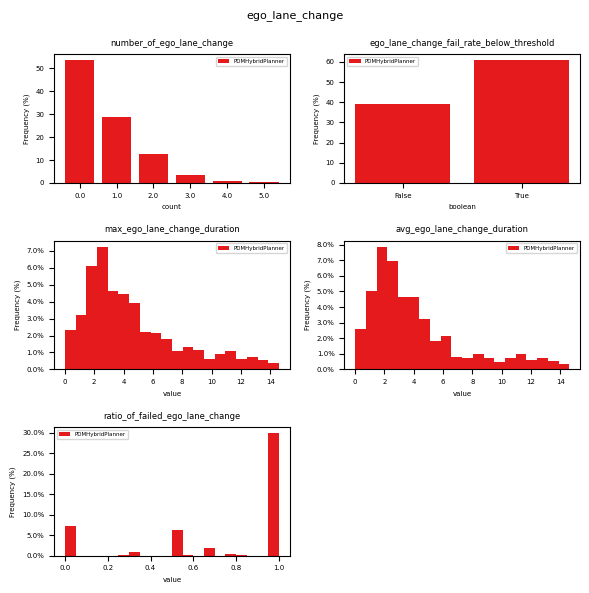

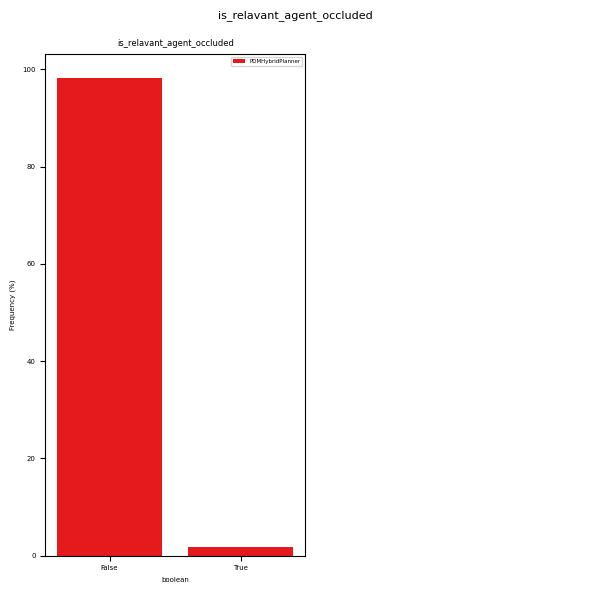

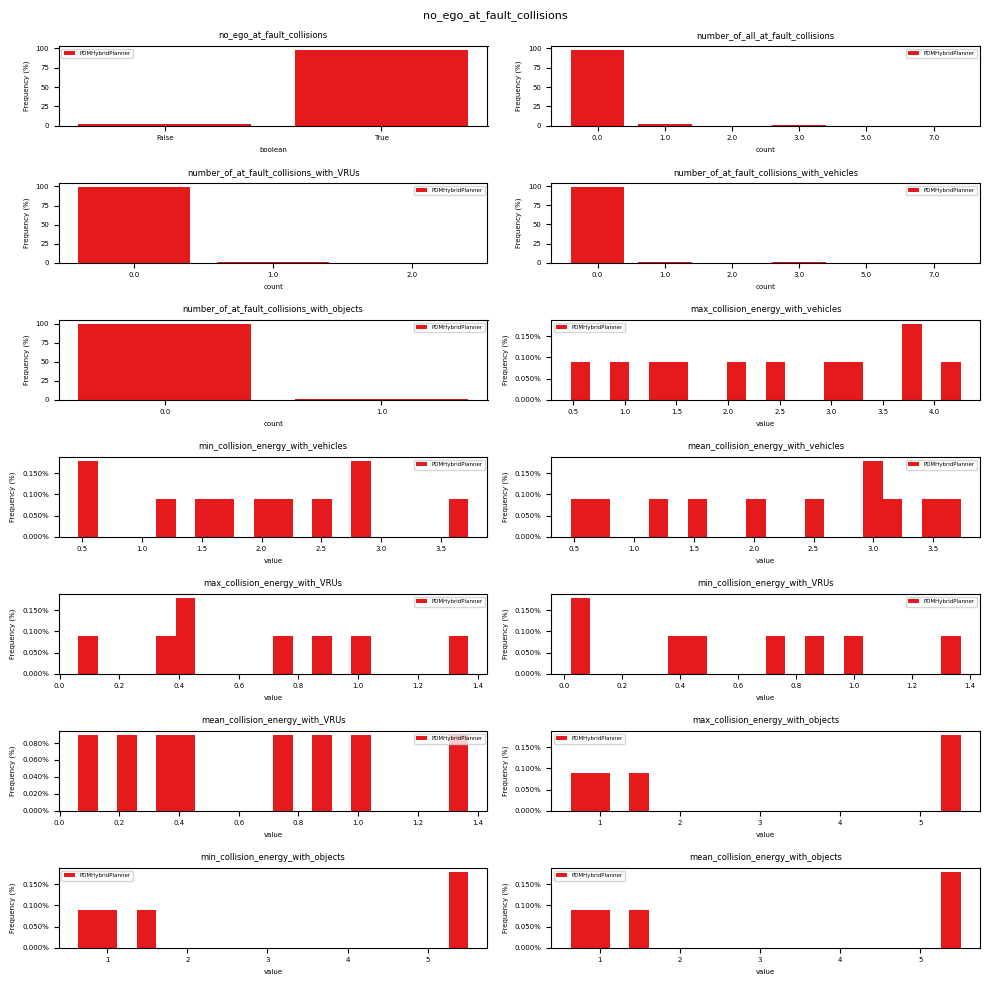

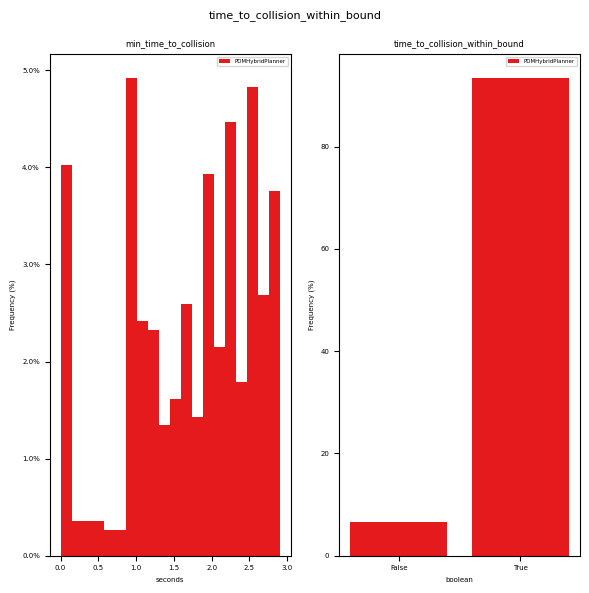

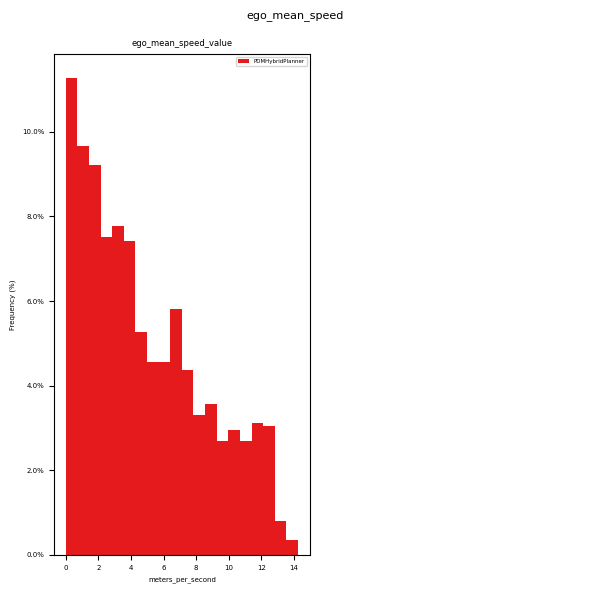

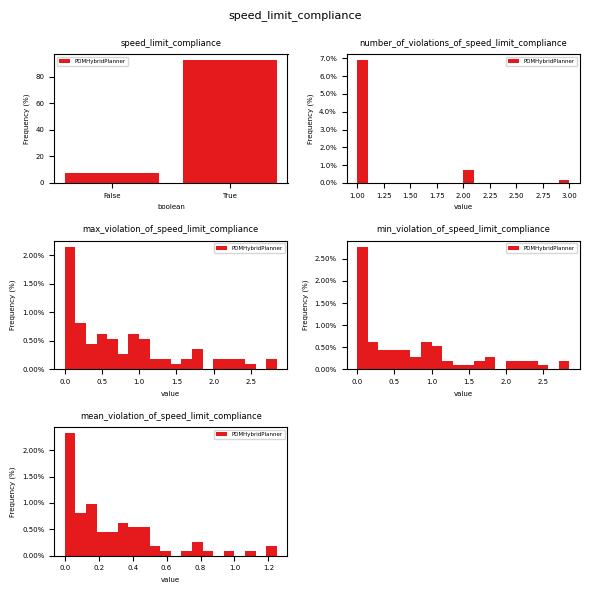

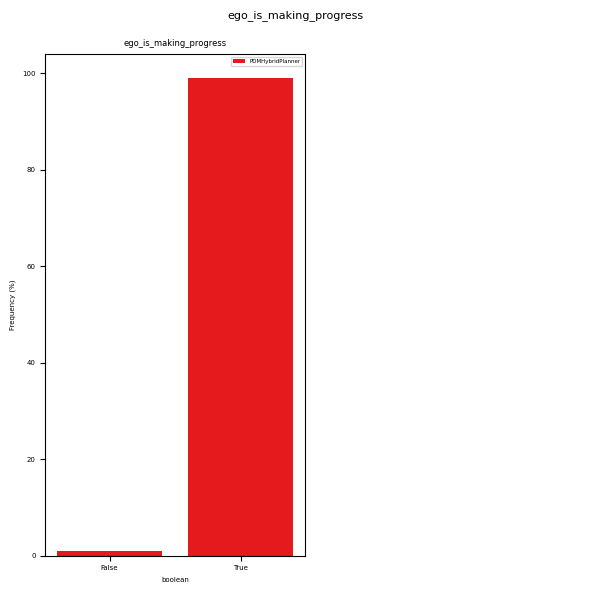

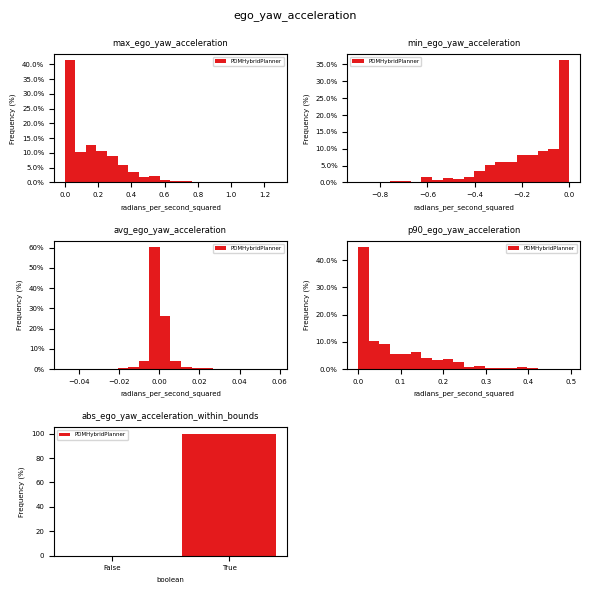

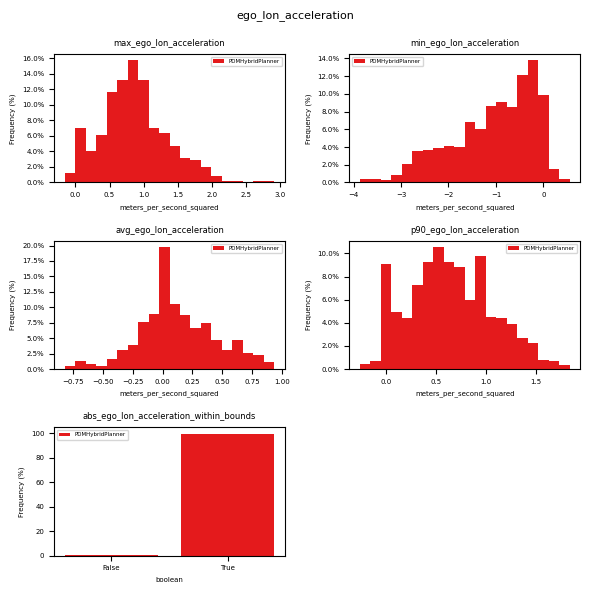

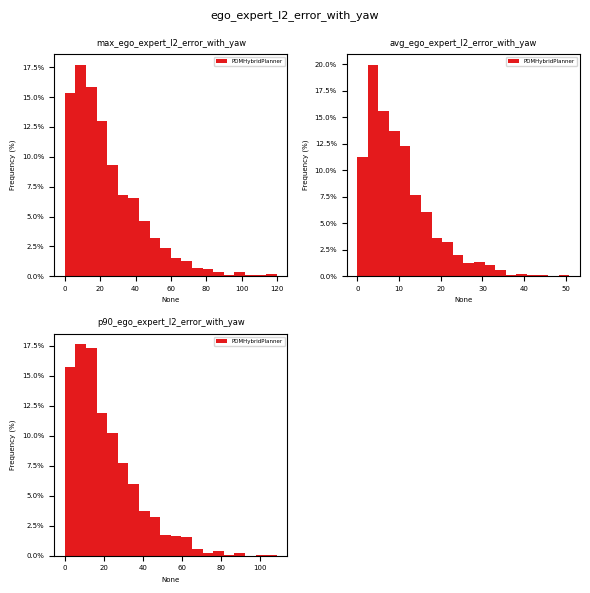

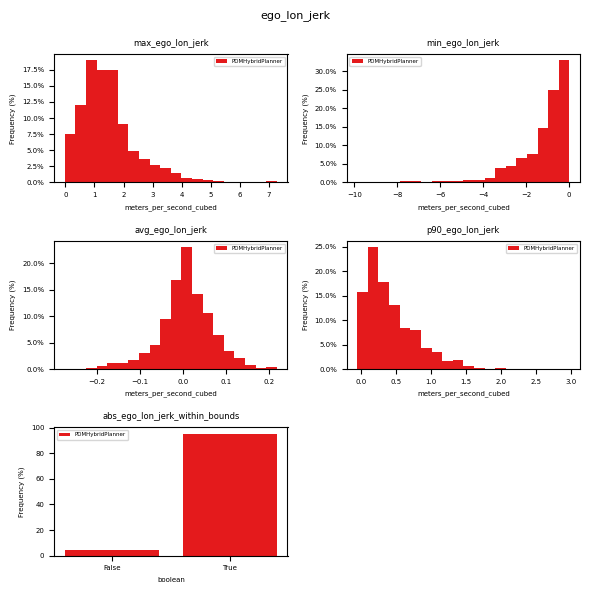

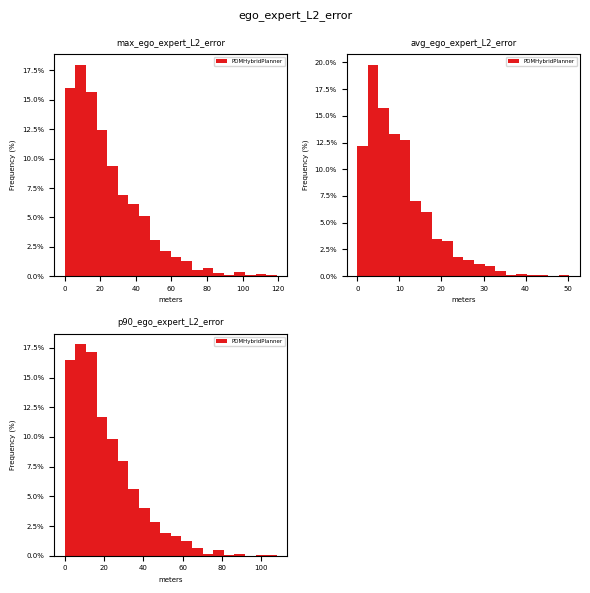

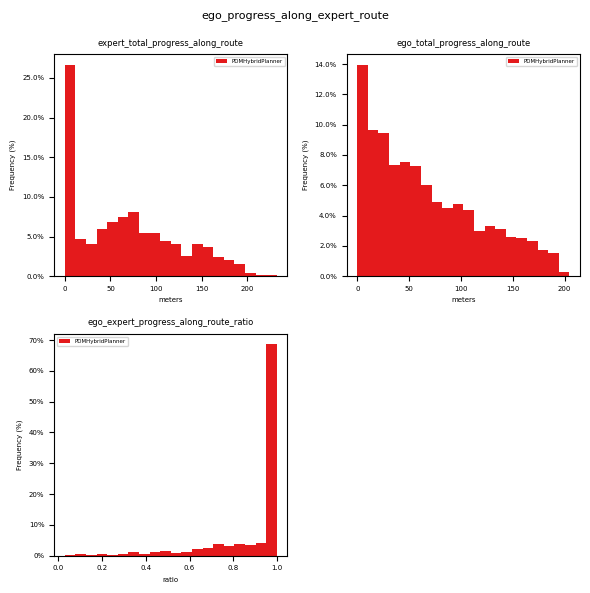

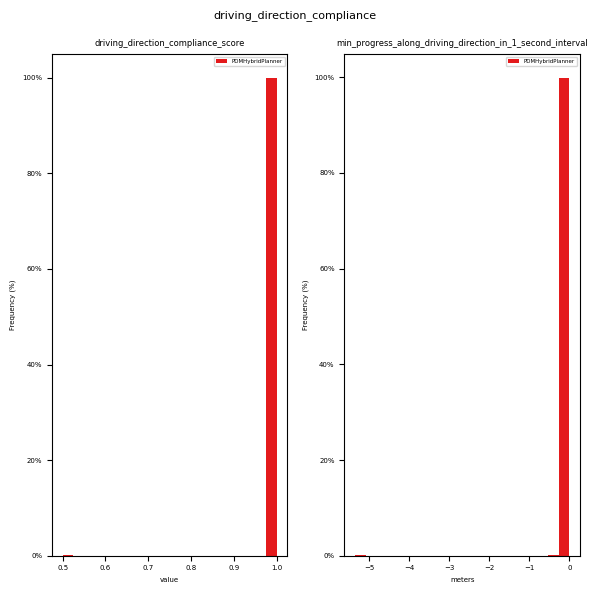

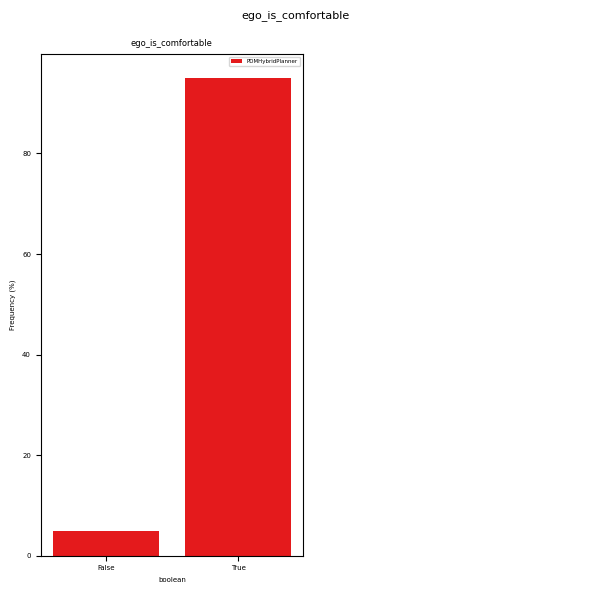

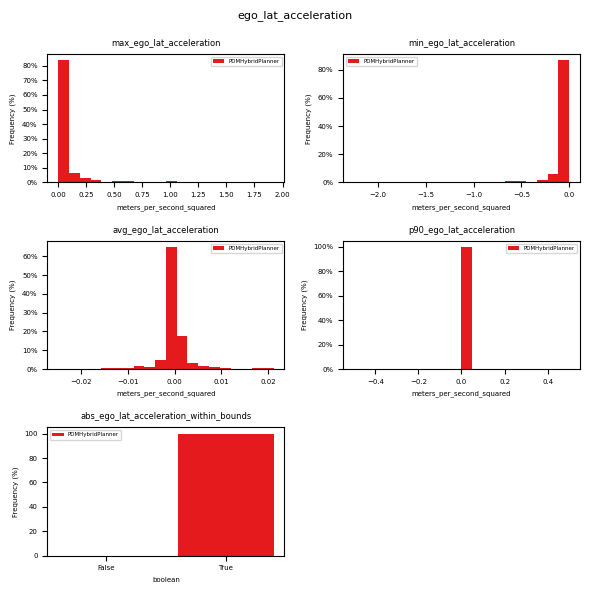

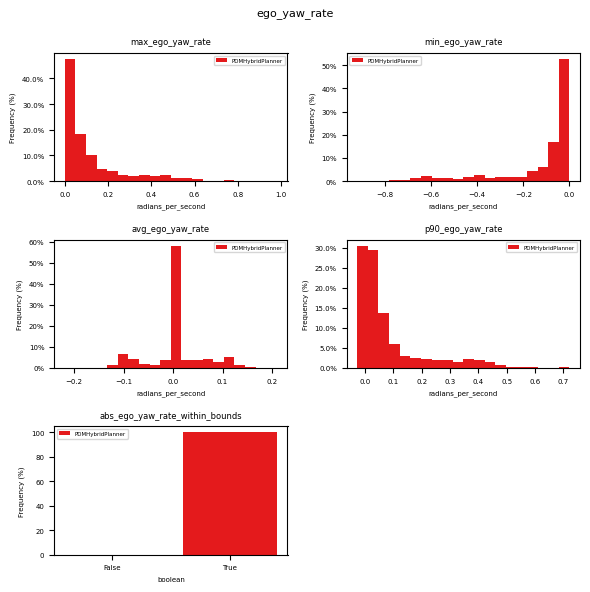

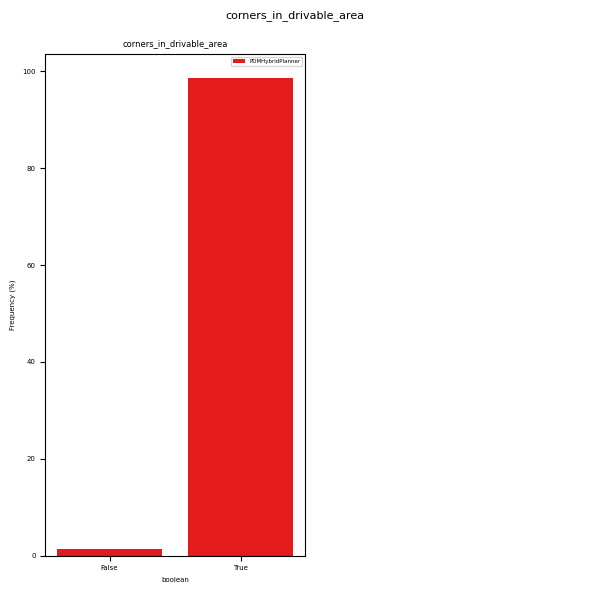

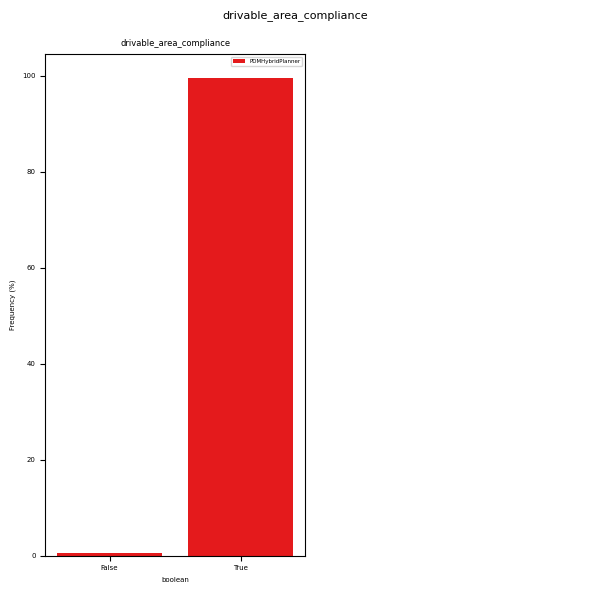

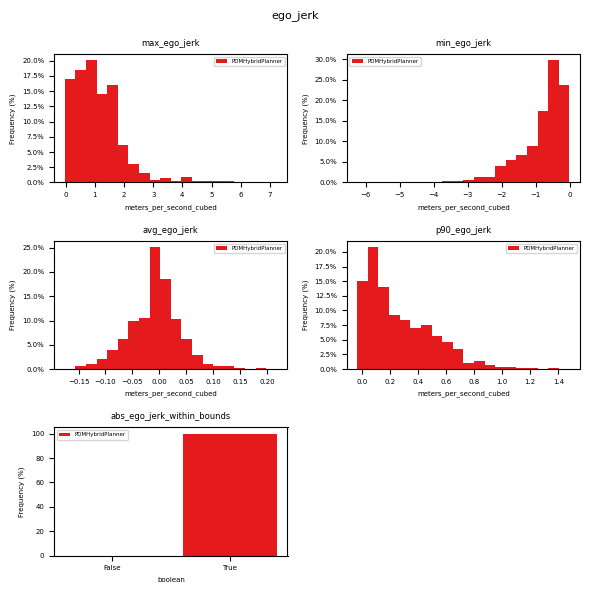

In [6]:
from nuplan.planning.script.run_simulation import main as main_simulation

# Run the simulation loop (real-time visualization not yet supported, see next section for visualization)
main_simulation(cfg)

## Prepare the nuBoard config

In [5]:
output_folder_alt = []
output_folder_alt.append("../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.21.59.48" )
output_folder_alt.append("../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.23.21.13" )
output_folder_alt.append("../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.07.32.41")
output_folder_alt.append("../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.08.29.23")
output_folder_alt.append("../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.11.00.41.30")
output_folder_alt.append("../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.10.09.31.44")
output_folder_alt.append("../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.13.12.21.28")
output_folder_alt.append("../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.13.13.07.48")



In [6]:
#output_folder = '../../data/nuplan/exp/exp/simulation/open_loop_boxes/2023.12.09.21.19.06'
#output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.21.59.48"
# Location of path with all nuBoard configs
CONFIG_PATH = '../nuplan/planning/script/config/nuboard'
CONFIG_NAME = 'default_nuboard'

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(config_name=CONFIG_NAME, overrides=[
    'scenario_builder=nuplan',  # set the database (same as simulation) used to fetch data for visualization
    f'simulation_path={output_folder_alt}',  # nuboard file path(s), if left empty the user can open the file inside nuBoard
])


## Launch nuBoard (open in new tab - recommended)

In [7]:
from nuplan.planning.script.run_nuboard import main as main_nuboard

# Run nuBoard
main_nuboard(cfg)

INFO:nuplan.planning.script.builders.scenario_building_builder:Building AbstractScenarioBuilder...
INFO:nuplan.planning.script.builders.scenario_building_builder:Building AbstractScenarioBuilder...DONE!
INFO:nuplan.planning.nuboard.nuboard:Opening Bokeh application on http://localhost:5006/
INFO:nuplan.planning.nuboard.nuboard:Async rendering is set to: True
INFO:bokeh.server.server:Starting Bokeh server version 2.4.3 (running on Tornado 6.3.3)
INFO:bokeh.server.tornado:User authentication hooks NOT provided (default user enabled)
INFO:nuplan.planning.nuboard.base.simulation_tile:Minimum frame time=0.017 s
INFO:nuplan.planning.nuboard.tabs.scenario_tab:Rending scenario plot takes 0.0484 seconds.
INFO:tornado.access:200 GET / (127.0.0.1) 4772.75ms
INFO:tornado.access:200 GET / (127.0.0.1) 4772.75ms
INFO:tornado.access:304 GET /resource/spectre.min.css (127.0.0.1) 2.54ms
INFO:tornado.access:304 GET /resource/spectre.min.css (127.0.0.1) 2.54ms
INFO:tornado.access:304 GET /resource/spectre